# Prediction of risk of mortality one year after pulmonary transplantation
The goal of this project is to  build a model to predict the risk of mortality one year after a pulmonary transplantation.
Our dataset come's from  Bichat's hospital in Paris. It contains information on 252 patients.
Class distribution: 189 Alive, 63 Dead.

44 contains null values
There is no duplicated data
208 not null values

In this version, to remplace null values, I used the median for each group of target variable

In [1]:
#!pip install -U giotto-tda

In [2]:
#pip install PrettyTable

In [3]:
#!pip install openml

# Import Libraries

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from prettytable import PrettyTable

from sklearn.preprocessing import RobustScaler, StandardScaler,LabelEncoder
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.cluster import DBSCAN

#multiinterpolation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.cluster import KMeans

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
import torch
from torch import nn
from torch.utils.data import DataLoader
from gtda.diagrams import Amplitude
import sklearn
from gtda.homology import VietorisRipsPersistence

from sklearn.metrics import mean_squared_error
from sklearn.manifold import trustworthiness
from scipy.spatial import distance
from sklearn.metrics.pairwise import euclidean_distances
from sklearn import preprocessing
import math
from sklearn.pipeline import make_pipeline

plt.rc('figure', max_open_warning = 0)

import warnings
warnings.filterwarnings("ignore")

In [6]:
classifiers = [LogisticRegression,KNeighborsClassifier,SVC,
               MLPClassifier,GaussianNB,DecisionTreeClassifier,
              RandomForestClassifier]

# Classes and functions

In [7]:
def classification_results(x_dat,y_true,y_pred,mod,title=None,results_out= False):

#   print("Results for {}:".format(method.__name__))
    if title != None:
        print("Results for:",title)
    print(classification_report(y_true, y_pred))
    print("Training Accuracy:",
          round(classification_report(y_true, y_pred, output_dict=True)['accuracy'],4))
    print("Training Recall:",
          round(classification_report(y_true, y_pred, output_dict=True)['1']['recall'],4))


    #print confusion matrix
    sns.set_palette("Paired")
    y_pred_rf = y_pred
    y_true_rf = y_true
    cm = confusion_matrix(y_true_rf, y_pred_rf)
    f, ax = plt.subplots(figsize =(5,5))
    sns.heatmap(cm,annot = True,linewidths=0.5,linecolor="black",
                cmap="RdBu_r",fmt = ".0f",ax=ax)
    plt.xlabel("y_pred_rf")
    plt.ylabel("y_true_rf")
    plt.title('Training Data Confusion Matrix')
    plt.show()

    if results_out== True:
        return classification_report(y_true, y_pred, output_dict=True)

In [8]:
def classification(method, x_dat, y_dat, model_out=False,
                   feature_importance=False, results=True,
                   test=False, resultOnly=False,
                   **params):

    #fit model
    mod = Pipeline([('classify', method(**params))])
    mod.fit(x_dat, y_dat)
    y_pred = mod.predict(x_dat)
    if (resultOnly == True) and (test == False):
        return round(classification_report(y_dat, y_pred, output_dict=True)['accuracy'],4)
    
    
    if (results == True) and (test == False):
        t = classification_results(x_dat,y_dat,y_pred,mod,title=method.__name__,results_out=results)

        if feature_importance == True:
            # Calculate permutation feature importance
            # (n_jobs=-1 means using all processors)
            try:
                imp = permutation_importance(mod, x_dat, y_dat, n_jobs=-1)

                #Generate feature importance plot
                plt.figure(figsize=(12,8))
                importance_data = pd.DataFrame({'feature':x_dat.columns, 'importance':imp.importances_mean})
                sns.barplot(x='importance', y='feature', data=importance_data)
                plt.title('Permutation Feature Importance')
                plt.xlabel('Mean Decrease in F1 Score')
                plt.ylabel('')
                plt.show()
                
                
            except:
                print('No Feature Importance Available')
        return round(t['accuracy'],4)  


    if test != False:
        x_test, y_test = test[0], test[1]
        y_pred_test = mod.predict(x_test)
        
        if (resultOnly == True):
            return round(classification_report(y_test, y_pred_test, output_dict=True)['accuracy'],4)
        else:
            print("Results for {}:".format(method.__name__))
            print(classification_report(y_test, y_pred_test))
            print("Test Accuracy: {}%".format(round(mod.score(x_test, y_test)*100,2)))

            #print confusion matrix
            y_pred_rf = y_pred_test
            y_true_rf = y_test
            cm = confusion_matrix(y_test, y_pred_test)
            f, ax = plt.subplots(figsize =(5,5))
            sns.heatmap(cm,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
            plt.xlabel("y_pred_rf")
            plt.ylabel("y_true_rf")
            plt.title('Test Data Confusion Matrix')
            plt.show()
            return round(classification_report(y_test, y_pred_test, output_dict=True)['accuracy'],4)


    if model_out == True:
        return mod
    
    

In [9]:
def matrice_distance(data):
    d=euclidean_distances(data,data)
    d=preprocessing.normalize(d)
    return d

In [10]:
def estimateur(data,d,sigma):
    f=[]
    for i in range(40):
        s=0
        for j in range(40):
            s=s+math.exp(- (d[i][j]**2)*(sigma**(-1)))
        f.append(s)
    return f

In [11]:
def KL(a, b):
    a = np.asarray(a, dtype=np.float64)
    b = np.asarray(b, dtype=np.float64)

    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

In [12]:
def showResult(classifiers,x_train,y_train,test=False,resultOnly=False):
    
    result = []
    classifiers_columns = []
    for cls in classifiers:
        print('_' * 50)
        print('-' * 50)
        classifiers_columns.append(cls.__name__)
        ans = classification(cls,x_train,y_train,test=test)
        result.append(ans)
    return pd.DataFrame([result], columns=classifiers_columns)

In [288]:
def topologicalFeatures(classifiers,x,y,test=False,results=True,resultOnly=True,model_out=True,
                        random_state = 7):
    x = x.to_numpy().reshape(x.shape[0],x.shape[1],1)
    homology_dimensions = [0, 1, 2]
    result = []
    column_labels = ["bottleneck", "wasserstein", "landscape", "betti", "heat", "silhouette", "persistence_image"]
    
    for metric in column_labels:
        steps = [
            ("persistence", VietorisRipsPersistence(metric="euclidean", homology_dimensions=homology_dimensions, n_jobs=6)),
            ("amplitude",Amplitude(metric, n_jobs=-1)),
        ]

        pipeline = Pipeline(steps)
        data = pipeline.fit_transform(x)
        res = []
        classifiers_columns = []
        if test!=False:
            test_data = test[0].to_numpy().reshape(test[0].shape[0],test[0].shape[1],1)
            test_data = pipeline.fit_transform(test_data)
            for cls in classifiers:
                classifiers_columns.append(cls.__name__)
                print("*"*40)
                res.append(classification(cls,data,y,test=[test_data,test[1]],results=result,resultOnly=result,model_out=model_out))
                print("+"*40)
        else:
            for cls in classifiers:
                classifiers_columns.append(cls.__name__)
                res.append(classification(cls,data,y,results=result,resultOnly=result,model_out=model_out,random_state=random_state))
        result.append(res)
        
    column_labels.append("entropy")
    steps = [
        ("persistence", VietorisRipsPersistence(metric="euclidean", homology_dimensions=homology_dimensions, n_jobs=6)),
        ("entropy",PersistenceEntropy(normalize=True)),
    ]
    pipeline = Pipeline(steps)
    res = []
    data = pipeline.fit_transform(x)
    
    
    if test!=False:
        test_data = test[0].to_numpy().reshape(test[0].shape[0],test[0].shape[1],1)
        test_data = pipeline.fit_transform(test_data)
        classifiers_columns = []
        for cls in classifiers:
            classifiers_columns.append(cls.__name__)
            res.append(classification(cls,data,y,test=[test_data,test[1]],results=result,resultOnly=result,model_out=model_out))
    else:
        for cls in classifiers:
            classifiers_columns.append(cls.__name__)
            res.append(classification(cls,data,y,results=result,resultOnly=result,model_out=model_out,random_state=random_state))
    result.append(res)
    
    
    return pd.DataFrame(result, index=column_labels,columns=classifiers_columns)

In [340]:
def topologicalFeaturesComplete(x,y,test=False):
    x = x.to_numpy().reshape(x.shape[0],x.shape[1],1)
    homology_dimensions = [0, 1, 2]
    result = []
    column_labels = ["bottleneck", "wasserstein", "landscape", "betti", "heat", "silhouette", "persistence_image"]
    classifiers_columns = ["LogisticRegression","KNeighborsClassifier","SVC",
               "MLPClassifier","GaussianNB","DecisionTreeClassifier",
              "RandomForestClassifier"]
    for metric in column_labels:
        steps = [
            ("persistence", VietorisRipsPersistence(metric="euclidean", homology_dimensions=homology_dimensions, n_jobs=6)),
            ("amplitude",Amplitude(metric, n_jobs=-1)),
        ]

        pipeline = Pipeline(steps)
        data = pipeline.fit_transform(x)
        res = []
        if test!=False:
            test_data = test[0].to_numpy().reshape(test[0].shape[0],test[0].shape[1],1)
            test_data = pipeline.fit_transform(test_data)
            for cls in classifiers:
                res.append(classification(cls,data,y,test=[test_data,test[1]],results=True,resultOnly=True))
        else:
            for cls in classifiers:
                res.append(classification(cls,data,y,results=True,resultOnly=True))
        result.append(res)
        
    column_labels.append("entropy")
    steps = [
        ("persistence", VietorisRipsPersistence(metric="euclidean", homology_dimensions=homology_dimensions, n_jobs=6)),
        ("entropy",PersistenceEntropy(normalize=True)),
    ]
    pipeline = Pipeline(steps)
    res = []
    data = pipeline.fit_transform(x)
    
    
    if test!=False:
        test_data = test[0].to_numpy().reshape(test[0].shape[0],test[0].shape[1],1)
        test_data = pipeline.fit_transform(test_data)
        for cls in classifiers:
            res.append(classification(cls,data,y,test=[test_data,test[1]],results=True,resultOnly=True))
    else:
        for cls in classifiers:
            res.append(classification(cls,data,y,results=True,resultOnly=True))
    result.append(res)
    
    
    return pd.DataFrame(result, index=column_labels,columns=classifiers_columns)

# Data Exploration

In [26]:
pulmonary_imp = pd.read_excel("Base de donnees greffe pulmonaire_Ian.xlsx",sheet_name='Sheet1',usecols = "B:AU")

In [27]:
pulmonary_imp.head(25)

NIP (identifiant) date de TP  Age  Sexe (0=F, 1=M)  BMI (body mass index)  \
0          8005805551 2015-03-31   52                0                   26.0   
1          8009205234 2017-12-28   63                1                   18.0   
2          8004902968 2019-11-29   45                1                   31.0   
3          8009284788 2018-11-27   56                0                   28.0   
4          8004982944 2017-08-13   63                0                   20.0   
5          8005052740 2020-03-04   64                1                   24.0   
6          8007248277 2017-05-18   65                1                   25.0   
7          8005011089 2016-09-11   54                1                   23.0   
8          8004760186 2019-11-21   66                1                   24.0   
9          8011572076 2019-01-15   71                1                   24.0   
10         8009721788 2019-12-28   59                1                   30.0   
11         8004992222 2016-04-03   60                1                   30.0   
12         8010357769 2018-07-21   62                1                   31.1   
13         8010486580 2018-08-23   63                0                   17.3   
14         8006290174 2016-12-05   65                1                   28.0   
15         8005079343 2015-11-13   59                1                   25.0   
16         8010354644 2018-12-07   63                1                   25.0   
17         8004761746 2019-04-11   59                1                   25.0   
18         8012271403 2020-01-04   64                1                   31.0   
19         8008372826 2018-02-01   65                1                   28.0   
20         8011480645 2020-02-26   66                0                   27.0   
21         8008108560 2017-04-24   56                1                   21.0   
22         8006046547 2017-06-19   66                1                   24.0   
23         8003113092 2019-02-21   58                0                   25.0   
24         8003305268 2019-07-11   24                1                   17.0   

    BMI< ou egal 18  BMI>30  BMI>25  cardiopathie ischémique  \
0                 0       0       1                        0   
1                 1       0       0                        0   
2                 0       1       1                        0   
3                 0       0       1                        0   
4                 0       0       0                        0   
5                 0       0       0                        0   
6                 0       0       1                        1   
7                 0       0       0                        0   
8                 0       0       0                        0   
9                 0       0       0                        0   
10                0       1       1                        0   
11                0       1       1                        0   
12                0       1       1                        0   
13                1       0       0                        0   
14                0       0       1                        0   
15                0       0       1                        0   
16                0       0       1                        0   
17                0       0       1                        1   
18                0       1       1                        0   
19                0       0       1                        0   
20                0       0       1                        0   
21                0       0       0                        0   
22                0       0       0                        0   
23                0       0       1                        0   
24                1       0       0                        0   

    diabètepré-opératoire  ...  \
0                       1  ...   
1                       0  ...   
2                       0  ...   
3                       0  ...   
4                       0  ...   
5                       0  .

In [28]:
pulmonary_imp.dtypes

NIP (identifiant)                                                         int64
date de TP                                                       datetime64[ns]
Age                                                                       int64
Sexe (0=F, 1=M)                                                           int64
BMI (body mass index)                                                   float64
BMI< ou egal 18                                                           int64
BMI>30                                                                    int64
BMI>25                                                                    int64
cardiopathie ischémique                                                   int64
diabètepré-opératoire                                                     int64
PAPM (pression artérielle pulmonaire moyenne)                           float64
étiologie BPCO                                                            int64
étiologie Fibrose                       

In [29]:
pulmonary_imp.isnull().sum()

NIP (identifiant)                                                 0
date de TP                                                        0
Age                                                               0
Sexe (0=F, 1=M)                                                   0
BMI (body mass index)                                             0
BMI< ou egal 18                                                   0
BMI>30                                                            0
BMI>25                                                            0
cardiopathie ischémique                                           0
diabètepré-opératoire                                             0
PAPM (pression artérielle pulmonaire moyenne)                    23
étiologie BPCO                                                    0
étiologie Fibrose                                                 0
Autres étiologies                                                 2
Mismatch CMV (R-/D+)                            

In [30]:
#Dropping unnecessary columns
pulmonary_imp.drop(["NIP (identifiant)","date de TP"],axis=1,inplace=True)
# Defining name for feature columns
feature_cols = pulmonary_imp.columns
feature_cols

Index(['Age', 'Sexe (0=F, 1=M)', 'BMI (body mass index)', 'BMI< ou egal 18',
       'BMI>30', 'BMI>25', 'cardiopathie ischémique', 'diabètepré-opératoire',
       'PAPM (pression artérielle pulmonaire moyenne)', 'étiologie BPCO',
       'étiologie Fibrose', 'Autres étiologies', 'Mismatch CMV (R-/D+)',
       'ECMO pré-opératoire', 'Super Urgence',
       'type de TP (0=monopulmonaire, 1=bipulmonaire)', 'Ischémie Froide Max',
       'Analgésie péridurale ', 'ECMO peropératoire ',
       'Transfusion per opératoire >2 CGR', 'SOFA J0', 'IGS2 J0',
       'Nb Jours Noradrénaline ', 'Nb Jours Ventilation mécanique',
       'ECMO en Réanimation', 'Nb jours d'ECMO en réanimation',
       'Dysfonction primaire du greffon grade 3 ', 'insuffisance rénale aiguë',
       'dialyse en réanimation', 'bactériémie', 'Pneumonie (tous germes)',
       'Pneumonie à BLSE et/ou Pyo en réanimation',
       'Pneumonie acquise sous ventilation mécanique à BLSE et/ou Pyo',
       'Trachéotomie',
       'Sténose 

In [31]:
pulmonary_imp.describe()

Age  Sexe (0=F, 1=M)  BMI (body mass index)  BMI< ou egal 18  \
count  252.000000       252.000000             252.000000       252.000000   
mean    54.246032         0.638889              23.865873         0.134921   
std     11.027807         0.481279               4.651721         0.342319   
min     15.000000         0.000000              14.000000         0.000000   
25%     50.000000         0.000000              20.000000         0.000000   
50%     57.000000         1.000000              24.000000         0.000000   
75%     62.000000         1.000000              27.000000         0.000000   
max     71.000000         1.000000              35.100000         1.000000   

           BMI>30      BMI>25  cardiopathie ischémique  diabètepré-opératoire  \
count  252.000000  252.000000               252.000000             252.000000   
mean     0.119048    0.456349                 0.043651               0.107143   
std      0.324489    0.499082                 0.204724               0.309910   
min      0.000000    0.000000                 0.000000               0.000000   
25%      0.000000    0.000000                 0.000000               0.000000   
50%      0.000000    0.000000                 0.000000               0.000000   
75%      0.000000    1.000000                 0.000000               0.000000   
max      1.000000    1.000000                 1.000000               1.000000   

       PAPM (pression artérielle pulmonaire moyenne)  étiologie BPCO  ...  \
count                                     229.000000      252.000000  ...   
mean                                       25.720524        0.357143  ...   
std                                         7.723885        0.480111  ...   
min                                         8.000000        0.000000  ...   
25%                                        21.000000        0.000000  ...   
50%                                        25.000000        0.000000  ...   
75%                                        30.000000        1.000000  ...   
max                                        56.000000        1.000000  ...   

       Sténose bronchique grave dans l'année (stent ou dilatation)  \
count                                         252.000000             
mean                                            0.250000             
std                                             0.433874             
min                                             0.000000             
25%                                             0.000000             
50%                                             0.000000             
75%                                             0.250000             
max                                             1.000000             

       Fistule bronchique dans l'année  rejet humoral dans l'année  \
count                       252.000000                  252.000000   
mean                          0.150794                    0.194444   
std                           0.358560                    0.396560   
min                           0.000000                    0.000000   
25%                           0.000000                    0.000000   
50%                           0.000000                    0.000000   
75%                           0.000000                    0.000000   
max                           1.000000                    1.000000   

       rejet cellulaire dans l'année   pleurésie <1an  \
count                      251.000000      247.000000   
mean                         0.243028        0.153846   
std                          0.429769        0.361534   
min                          0.000000        0.000000   
25%                          0.000000        0.000000   
50%                          0.000000        0.000000   
75%                          0.000000        0.000000   
max                          1.000000        1.000000   

       durée de séjour en réanimation (1er séjour)  \
count                                   252.000000   
mea

In [32]:
pulmonary_imp.count()

Age                                                              252
Sexe (0=F, 1=M)                                                  252
BMI (body mass index)                                            252
BMI< ou egal 18                                                  252
BMI>30                                                           252
BMI>25                                                           252
cardiopathie ischémique                                          252
diabètepré-opératoire                                            252
PAPM (pression artérielle pulmonaire moyenne)                    229
étiologie BPCO                                                   252
étiologie Fibrose                                                252
Autres étiologies                                                250
Mismatch CMV (R-/D+)                                             251
ECMO pré-opératoire                                              252
Super Urgence                     

In [33]:
# adding a new target variable
condition1 = pulmonary_imp['mortalité à J30'] == 1
condition2 = pulmonary_imp['mortalité à 90j'] == 1
condition3 = pulmonary_imp['mortalité à un an'] == 1

output0 = 0
output1 = 1
output2 = 2
output3 = 3

# Apply multiple conditions and outputs using nested numpy.select()
pulmonary_imp['target'] = np.select(
    [condition1, ~condition1 & condition2, ~condition1 & ~condition2 & condition3],
    [output1, output2, output3],
    default= output0
)

In [34]:
pulmonary_imp.target.unique()

array([0, 1, 3, 2])

In [35]:
pulmonary_imp['mortalité à un an'].value_counts()

0    189
1     63
Name: mortalité à un an, dtype: int64

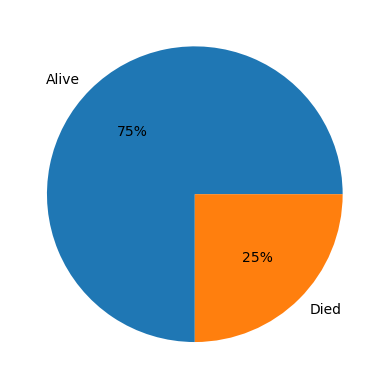

In [36]:
plt.pie(pulmonary_imp['mortalité à un an'].value_counts(), labels = ['Alive','Died'], autopct='%.0f%%', colors = sns.color_palette('tab10'))
plt.show()

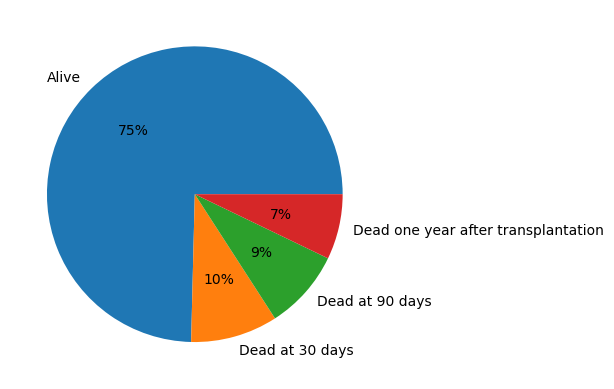

In [37]:
#There is a higher percentage of patients who died the first 30 days after transplatntation. As thethe number of days increases, the risk of dead also decreases.
plt.pie(pulmonary_imp['target'].value_counts(), labels = ['Alive','Dead at 30 days', 'Dead at 90 days','Dead one year after transplantation'], autopct='%.0f%%', colors = sns.color_palette('tab10'))
plt.show()

In [38]:
# adding a new target variable
condition1 = pulmonary_imp['Age'].between(0,17)
condition2 = pulmonary_imp['Age'].between(18,24)
condition3 = pulmonary_imp['Age'].between(25,30)
condition4 = pulmonary_imp['Age'].between(31,40)
condition5 = pulmonary_imp['Age'].between(41,50)
condition6 = pulmonary_imp['Age'].between(51,60)

output0 = "entre 0 et 17"
output1 = "entre 18 et 24"
output2 = "entre 25 et 30"
output3 = "entre 31 et 40"
output4 = "entre 41 et 50"
output5 = "entre 51 et 60"
output6 = "plus de 60 "

# Apply multiple conditions and outputs using nested numpy.select()
pulmonary_imp['Groupedage'] = np.select(
    [condition1, condition2, condition3, condition4, condition5, condition6],
    [output0, output1, output2,output3,output4,output5],
    default= output6
)

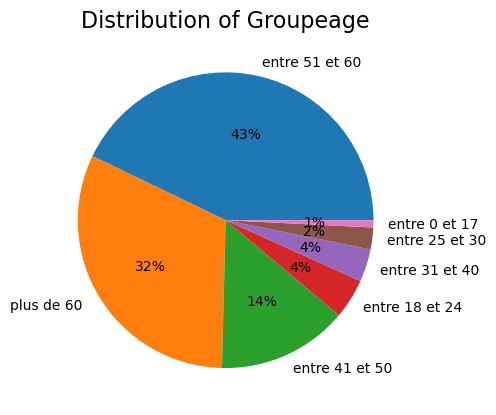

In [39]:
plt.pie(pulmonary_imp["Groupedage"].value_counts(), labels = pulmonary_imp["Groupedage"].unique(), autopct='%.0f%%', colors = sns.color_palette('tab10'))
plt.title("Distribution of Groupeage", fontsize = 16)
plt.axis('off')
plt.show()

In [40]:
# Defining feature and target set as X and Y respectively
X, Y = pulmonary_imp.drop(['mortalité à J30','mortalité à 90j','mortalité à un an','target'],axis=1), pulmonary_imp[['mortalité à J30','mortalité à 90j','mortalité à un an','target']]

In [41]:
X['Age'].unique().min()

15

Sexe (0=F, 1=M)
*************************************


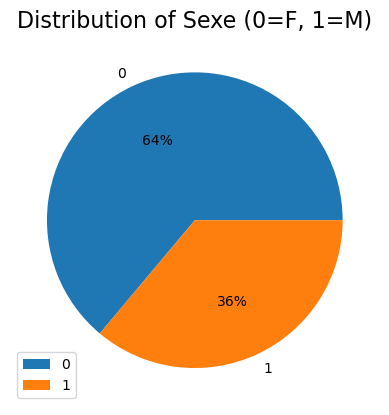

BMI< ou egal 18
*************************************


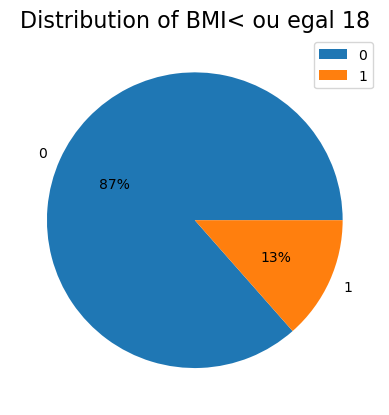

BMI>30
*************************************


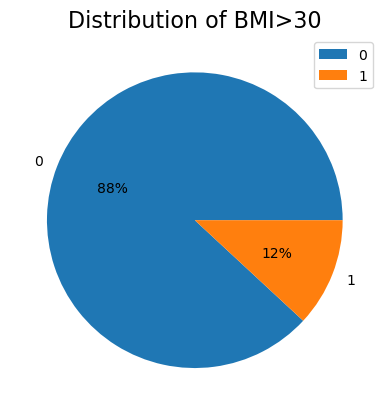

BMI>25
*************************************


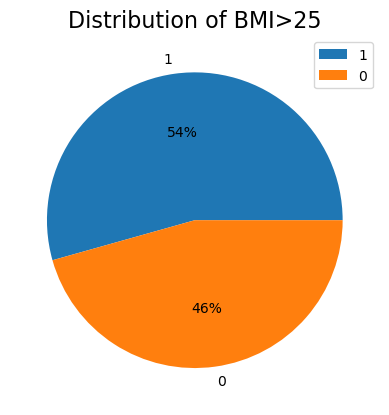

cardiopathie ischémique
*************************************


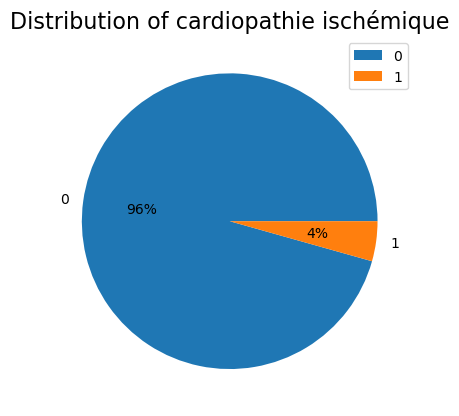

diabètepré-opératoire
*************************************


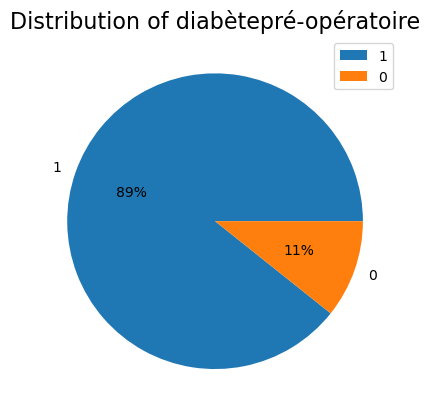

étiologie BPCO
*************************************


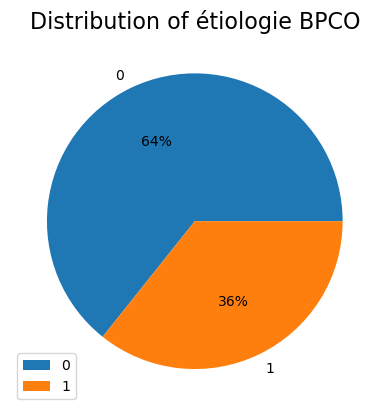

étiologie Fibrose
*************************************


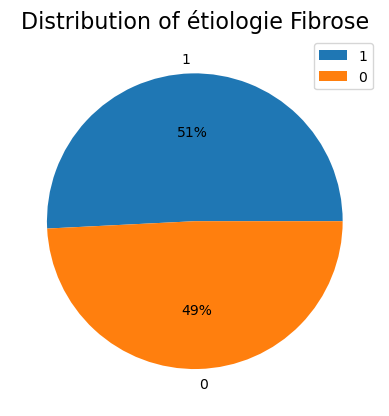

ECMO pré-opératoire
*************************************


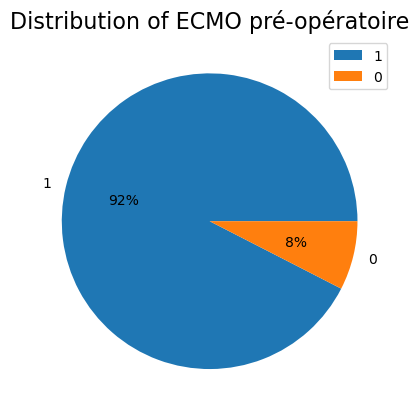

type de TP (0=monopulmonaire, 1=bipulmonaire)
*************************************


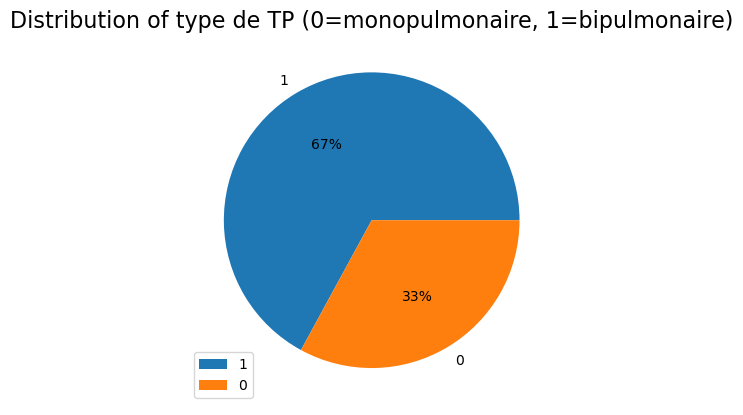

ECMO peropératoire 
*************************************


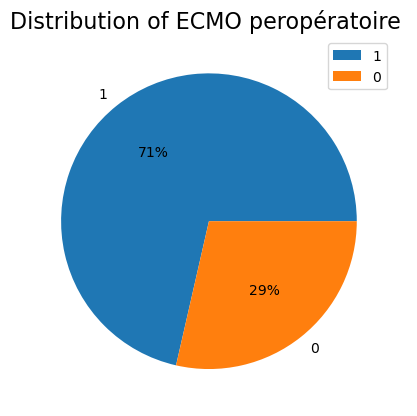

ECMO en Réanimation
*************************************


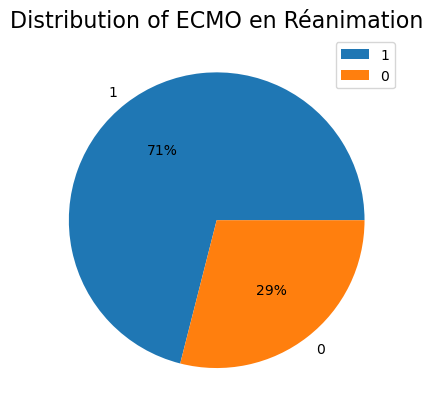

Dysfonction primaire du greffon grade 3 
*************************************


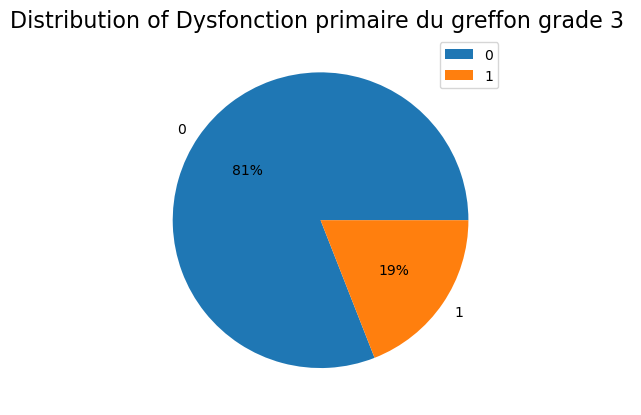

insuffisance rénale aiguë
*************************************


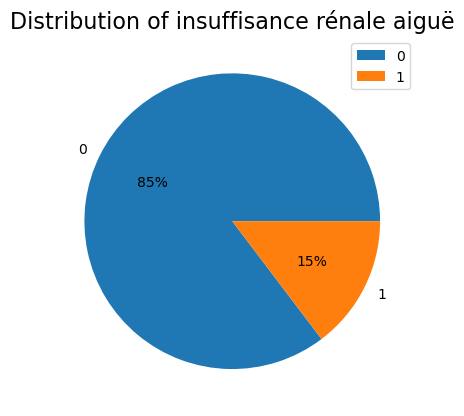

dialyse en réanimation
*************************************


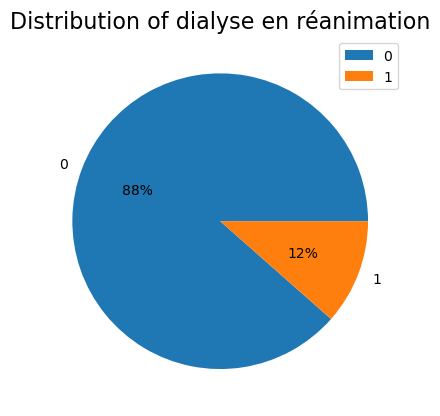

bactériémie
*************************************


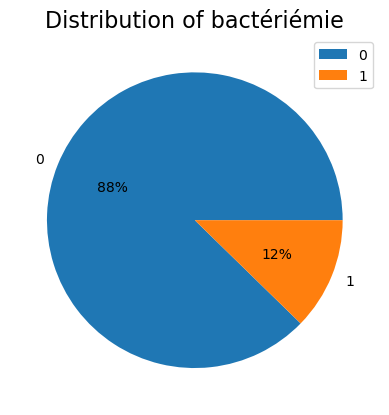

Pneumonie à BLSE et/ou Pyo en réanimation
*************************************


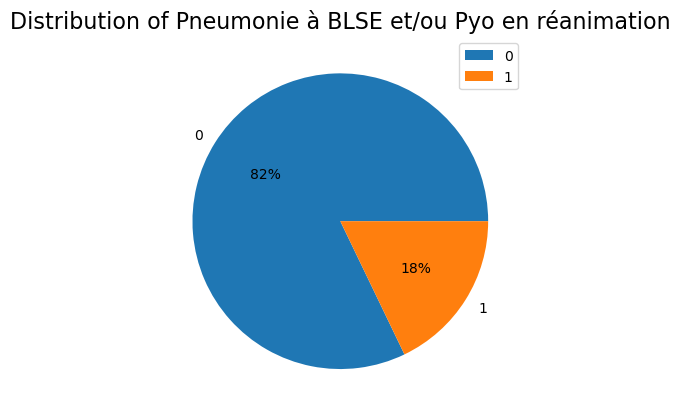

Pneumonie acquise sous ventilation mécanique à BLSE et/ou Pyo
*************************************


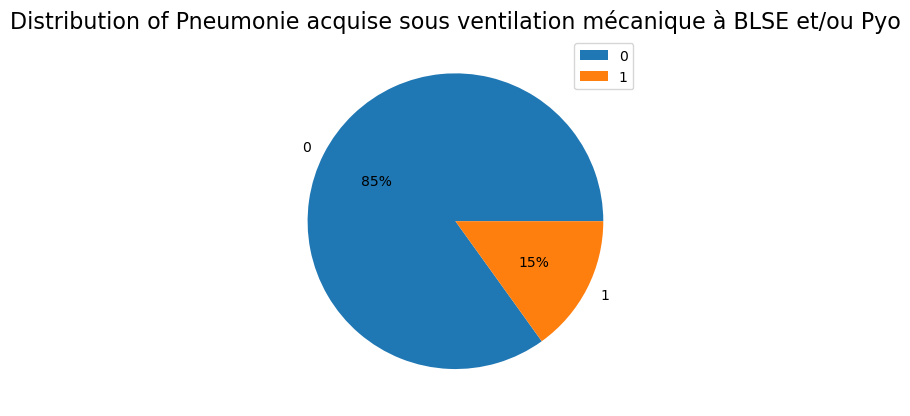

Trachéotomie
*************************************


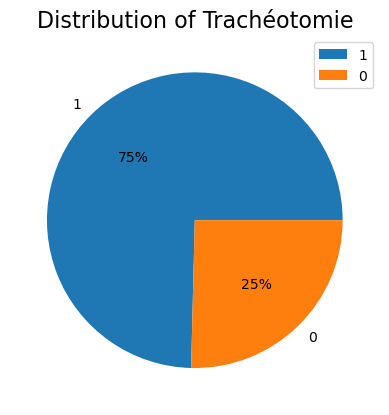

Sténose bronchique grave dans l'année (stent ou dilatation)
*************************************


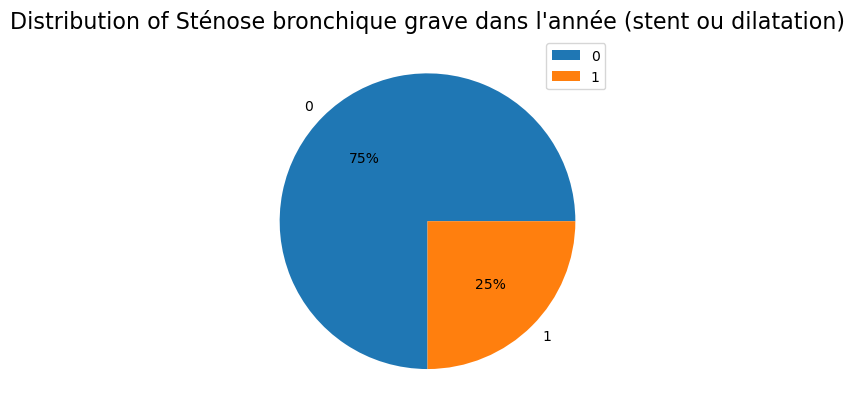

Fistule bronchique dans l'année
*************************************


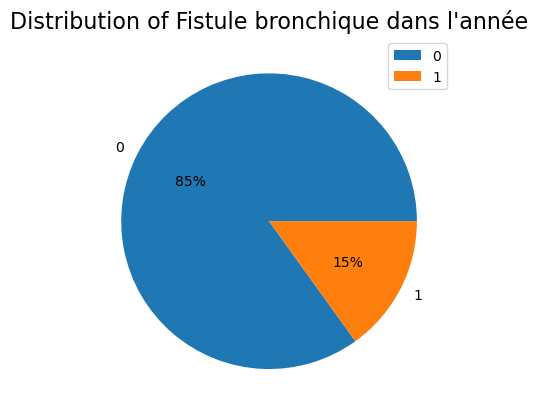

rejet humoral dans l'année
*************************************


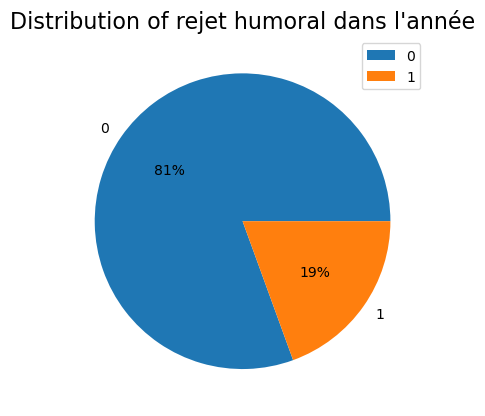

mortalité dans le premier séjour réanimation
*************************************


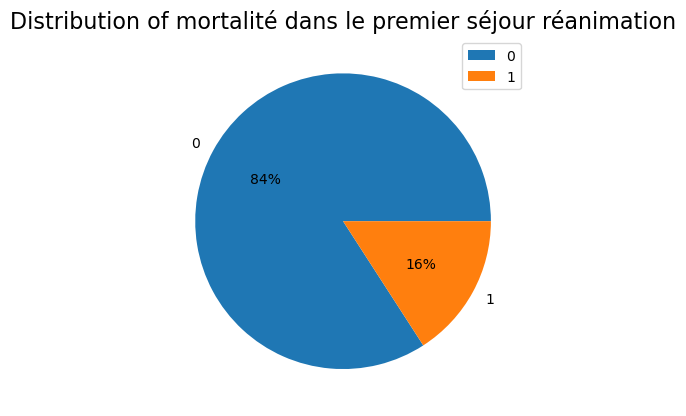

In [42]:
for i in X.columns:
  if len(pulmonary_imp[i].unique()) < 6 and pulmonary_imp[i].isnull().sum()==0:
    print(i)
    print('*************************************')
    plt.pie(pulmonary_imp[i].value_counts(), labels = pulmonary_imp[i].unique(), autopct='%.0f%%', colors = sns.color_palette('tab10'))
    plt.title("Distribution of "+i, fontsize = 16)
    plt.axis('off')
    plt.legend()
    plt.show()

# Histogram

In [43]:
X.columns.shape

(42,)

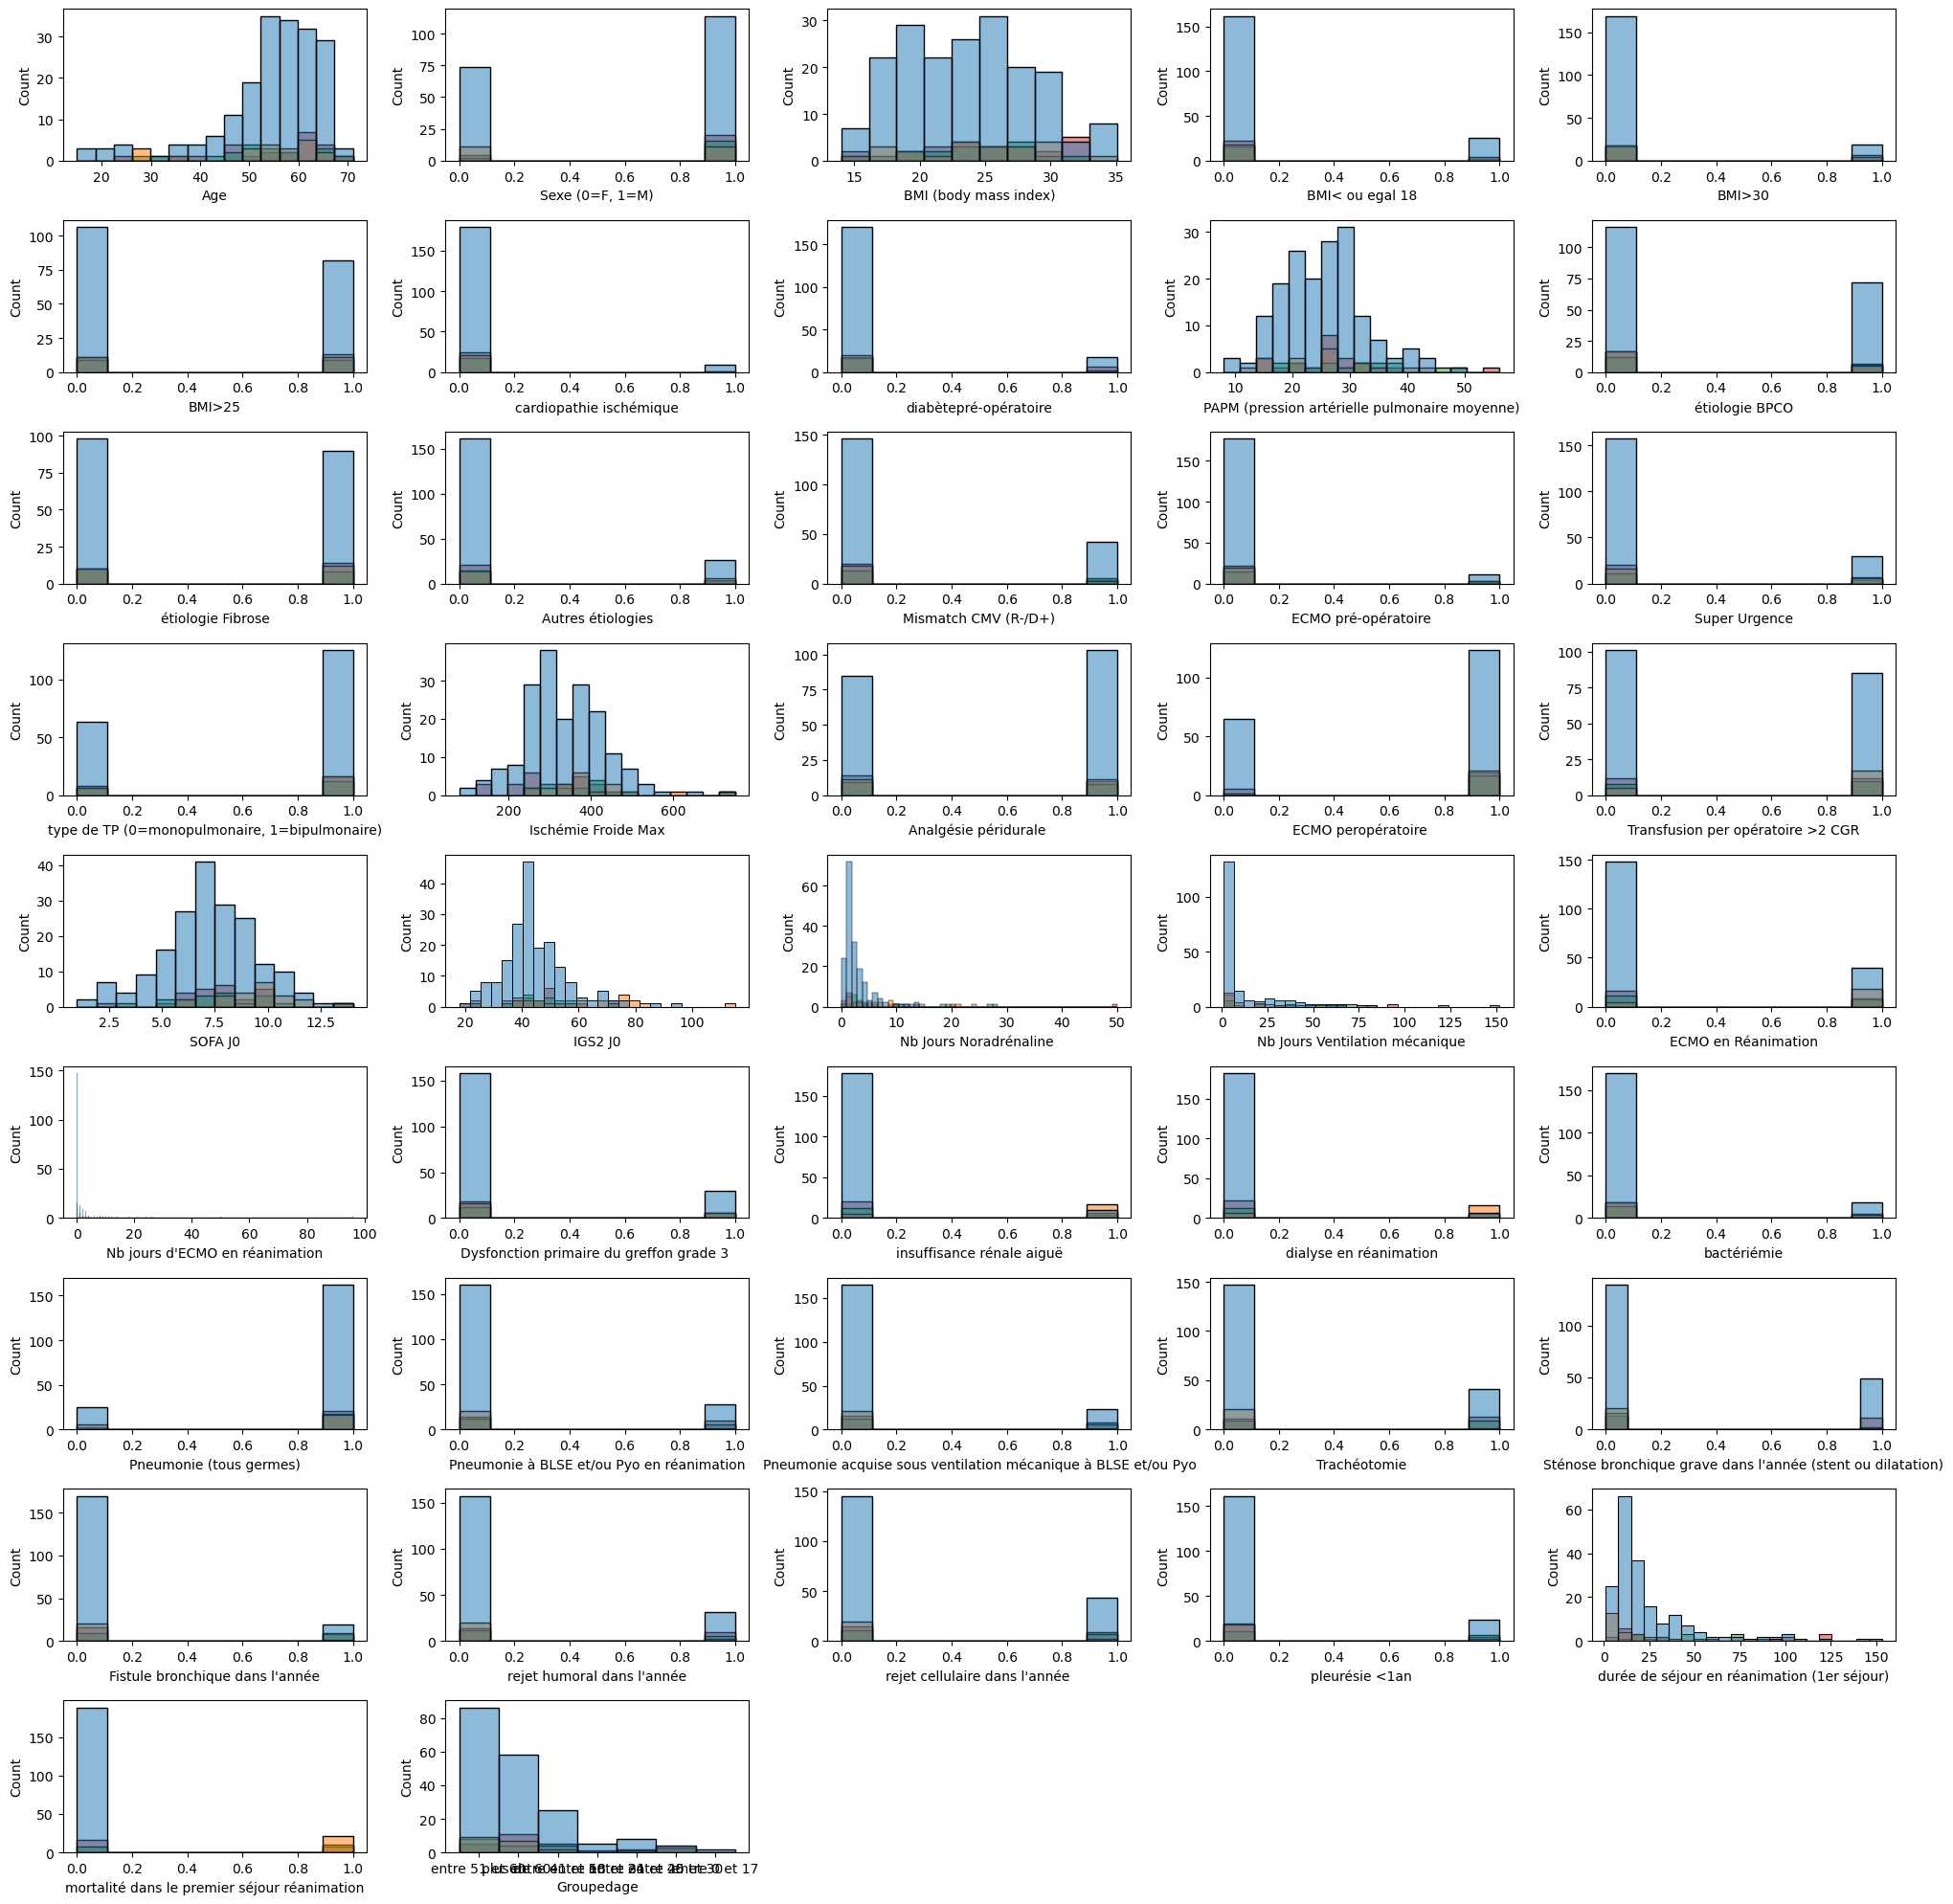

In [44]:
count=1
plt.subplots(figsize=(20, 20))

for i in X.columns:
    plt.subplot(9,5,count)
    sns.histplot(data=pulmonary_imp, hue='target', x = i,palette="tab10").legend([],[], frameon=False)
    count+=1

plt.tight_layout()
plt.show()

- There are some patients who died at reanimation.
- All patients at the age between 26 and 30 died.
All patients having less than 24 years survived

We can inquire about the age and sex of those patients.


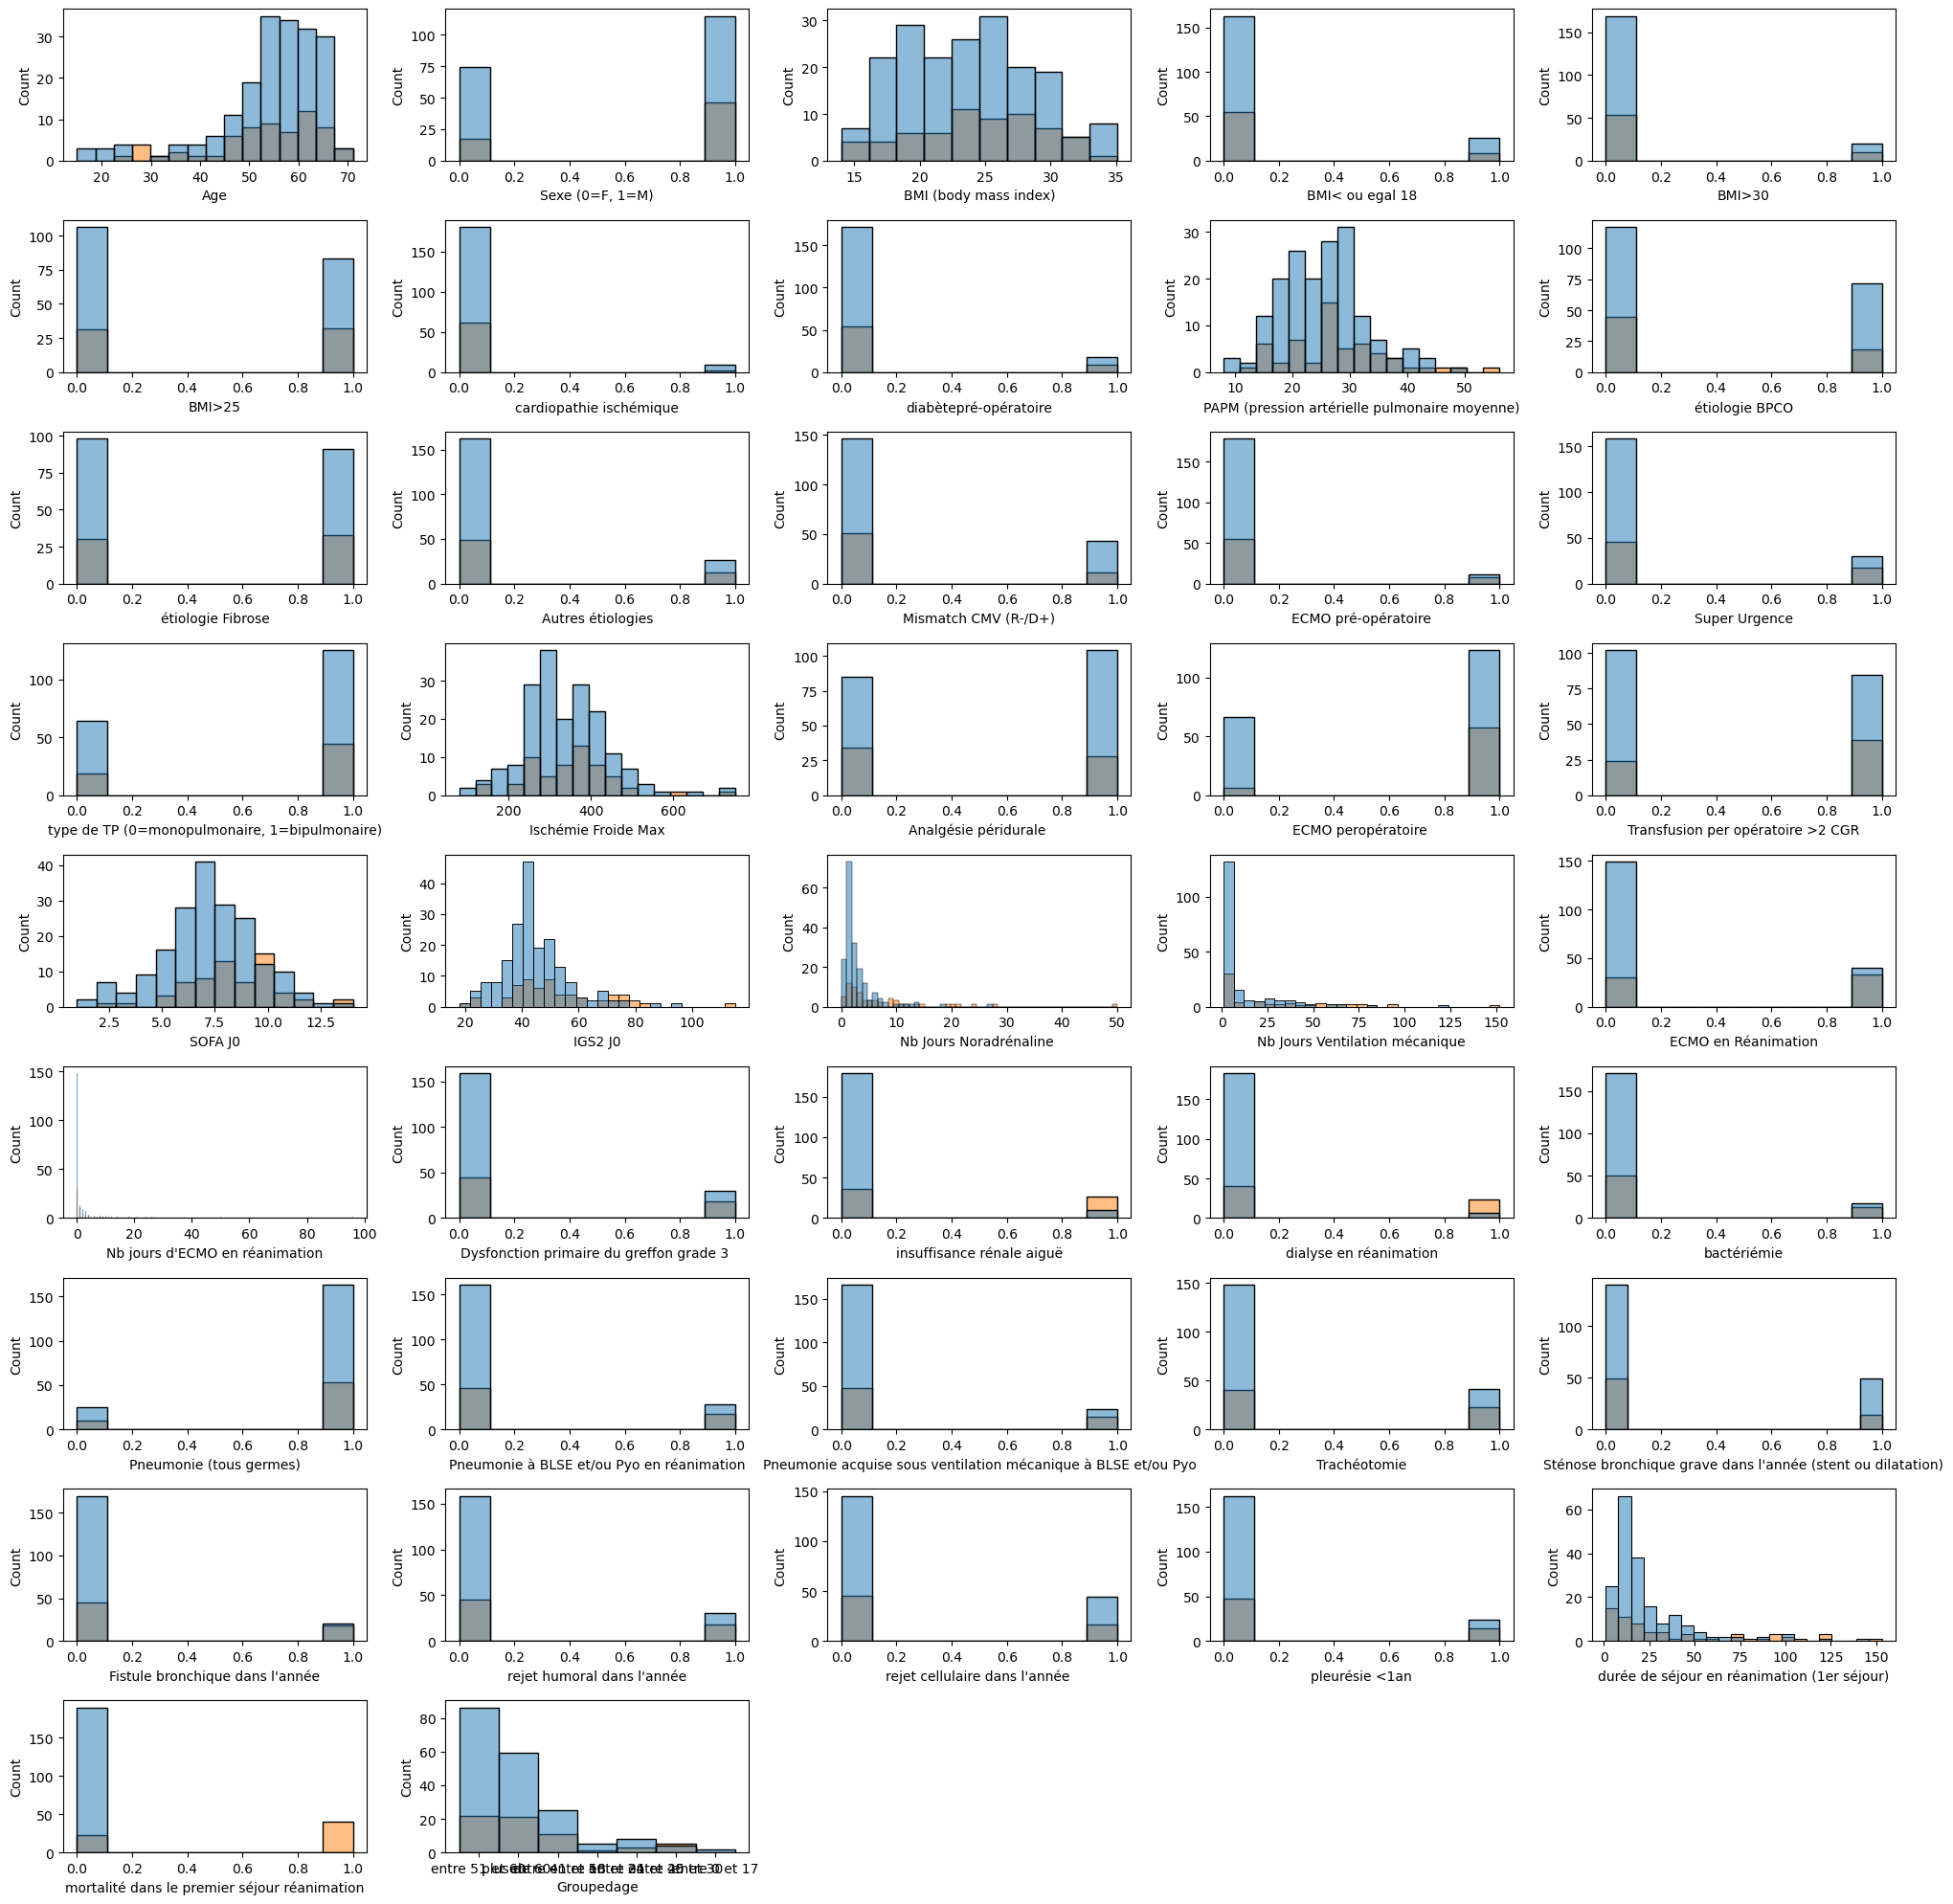

In [45]:
count=1
plt.subplots(figsize=(20, 20))

for i in X.columns:
    plt.subplot(9,5,count)
    sns.histplot(data=pulmonary_imp, hue='mortalité à un an', x = i,palette="tab10").legend([],[], frameon=False)
    count+=1

plt.tight_layout()
plt.show()

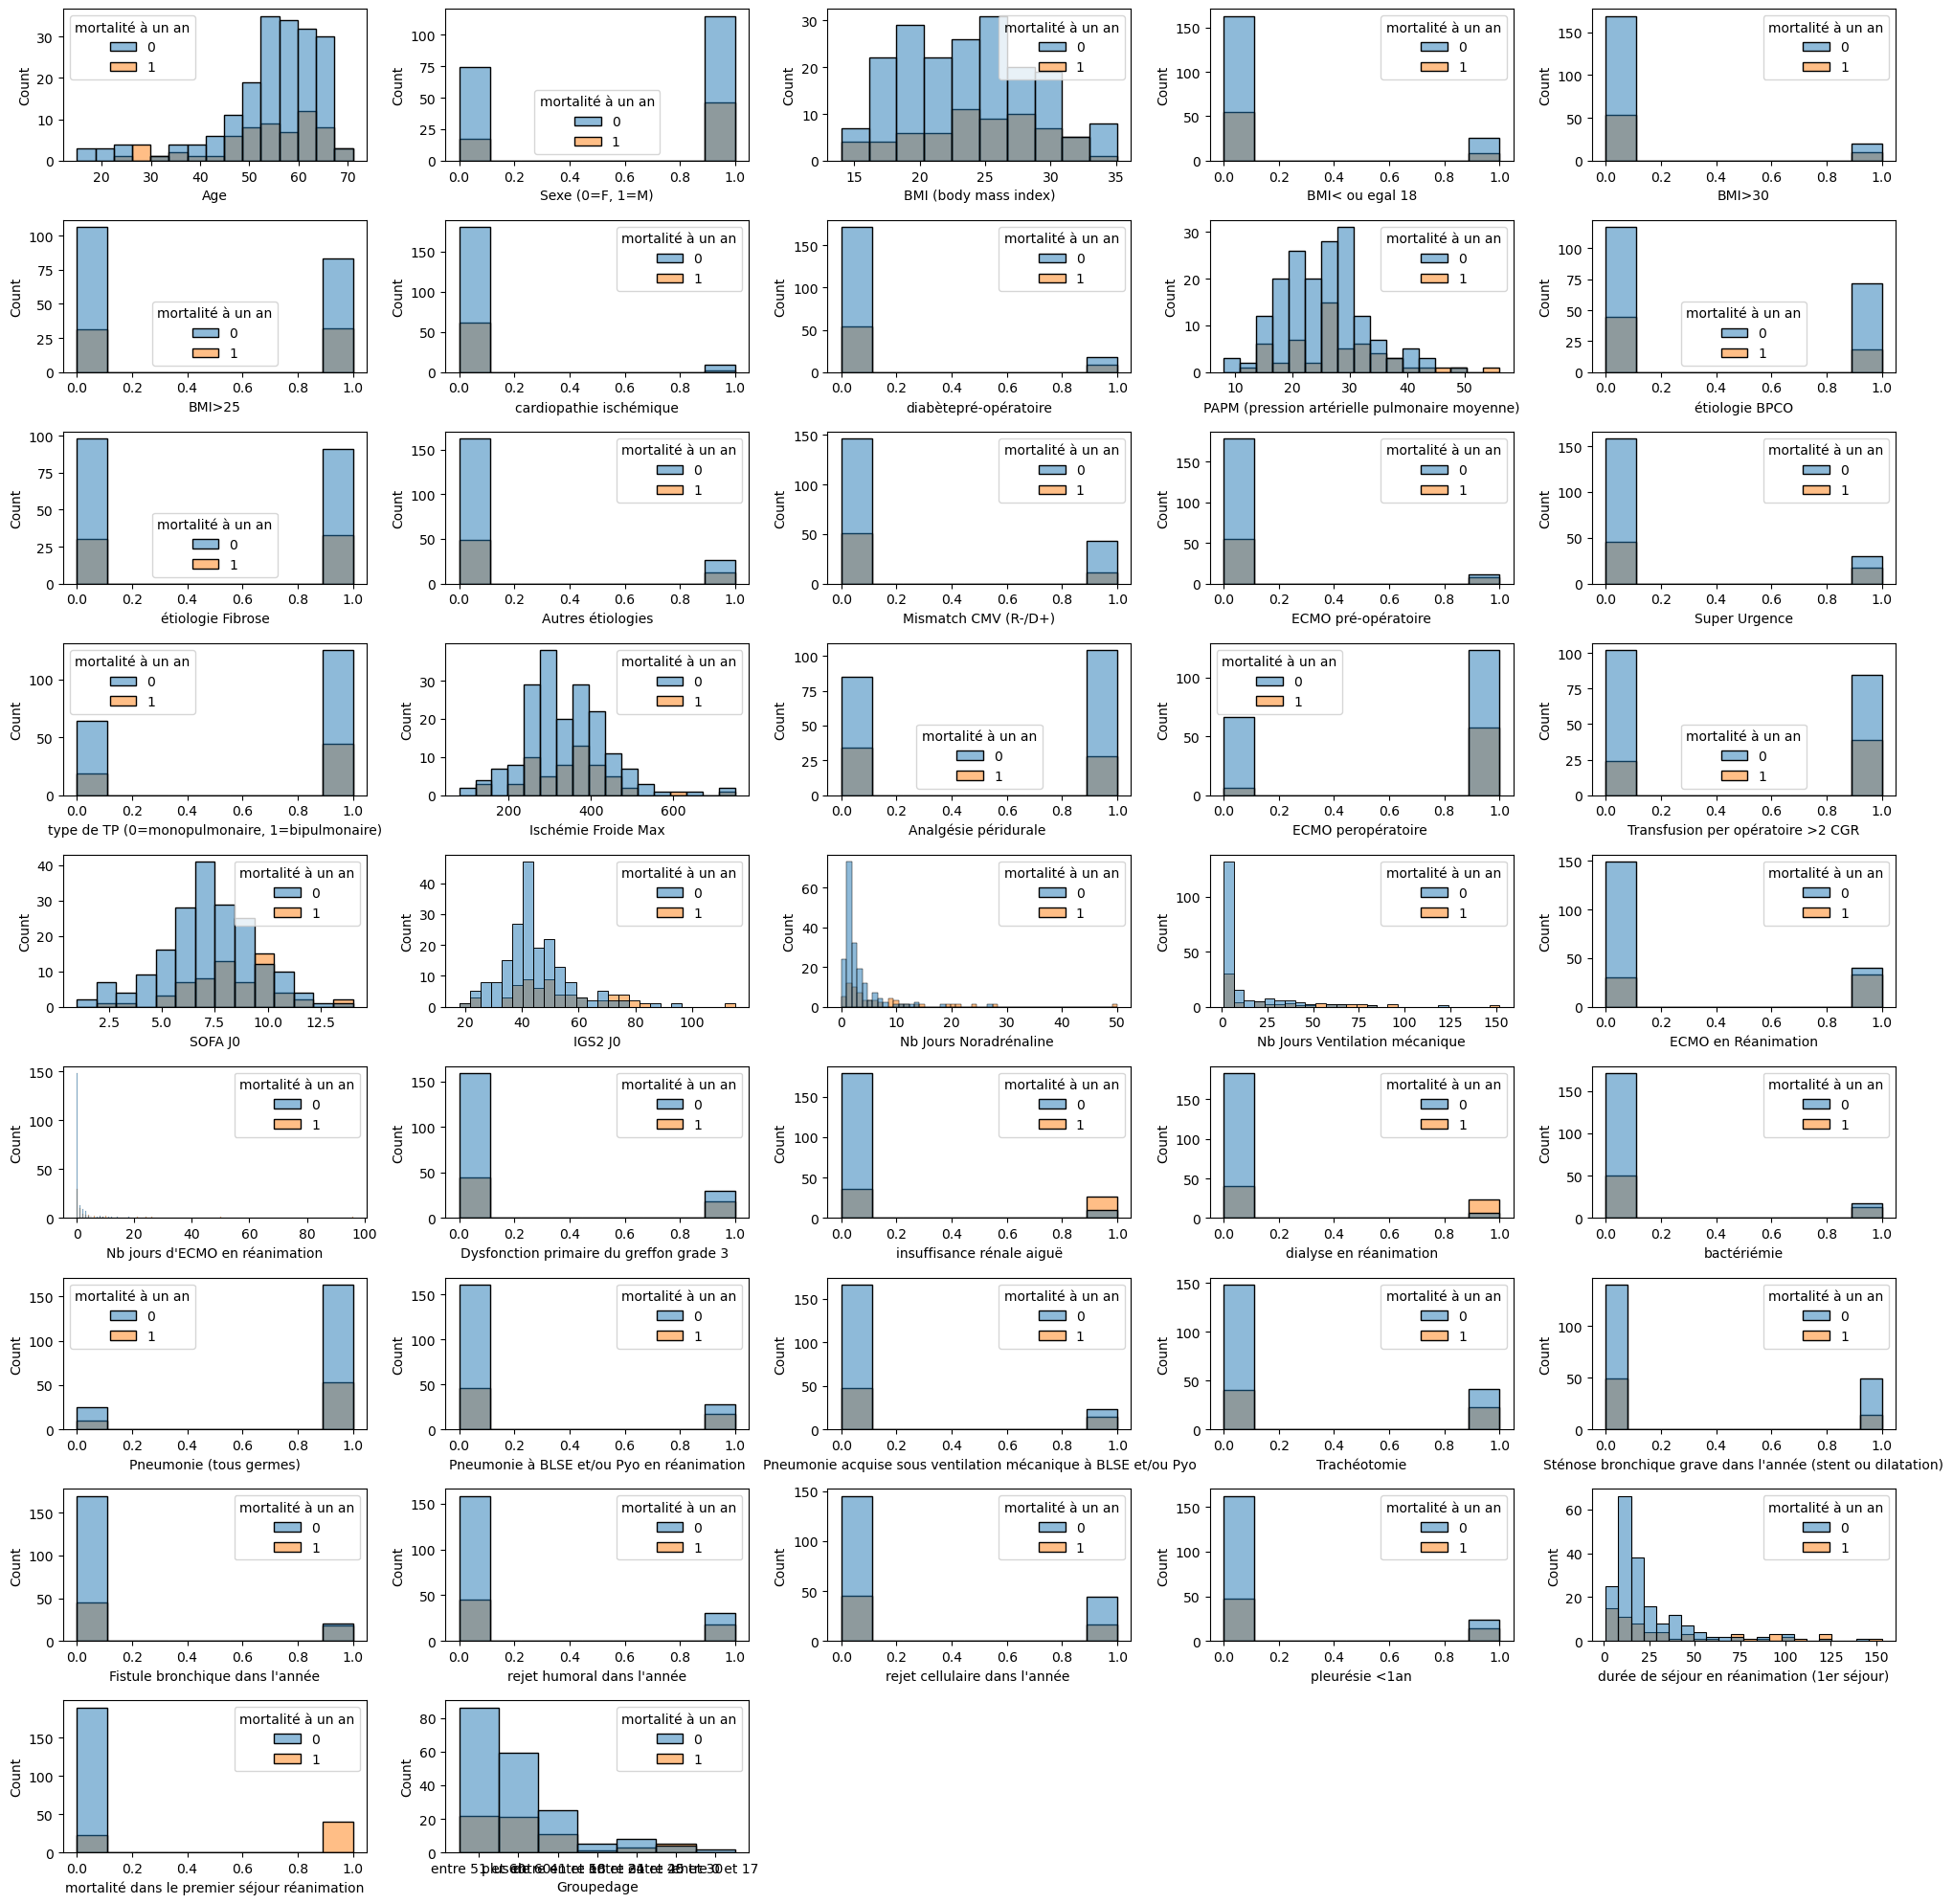

In [46]:
count=1
plt.subplots(figsize=(20, 20))

for i in X.columns:
    plt.subplot(9,5,count)
    sns.histplot(data=pulmonary_imp, hue='mortalité à un an', x = i,palette="tab10")
    count+=1

plt.tight_layout()
plt.show()

- Most of the patients who died were during their first day in the intensive care unit. As the days pass, their chances of survival increase. However, after 40 days, the risk becomes imbalanced, with a 50% chance of adverse outcomes.

- More than 80% of patients who died had bronchial fistula.

- More than 50% of patients who died underwent preoperative ECMO (Extracorporeal Membrane Oxygenation). This means that if you did not undergo preoperative ECMO, your chances of survival are higher than 70%, while if you did undergo it, the chances decrease to 50%.

- The same applies to ECMO during the intensive care unit stay.

- Cardiopathie ischemique: All those who had this at 1 survived, but all those who died had this at 0. But more than 85% of patient had this at 0

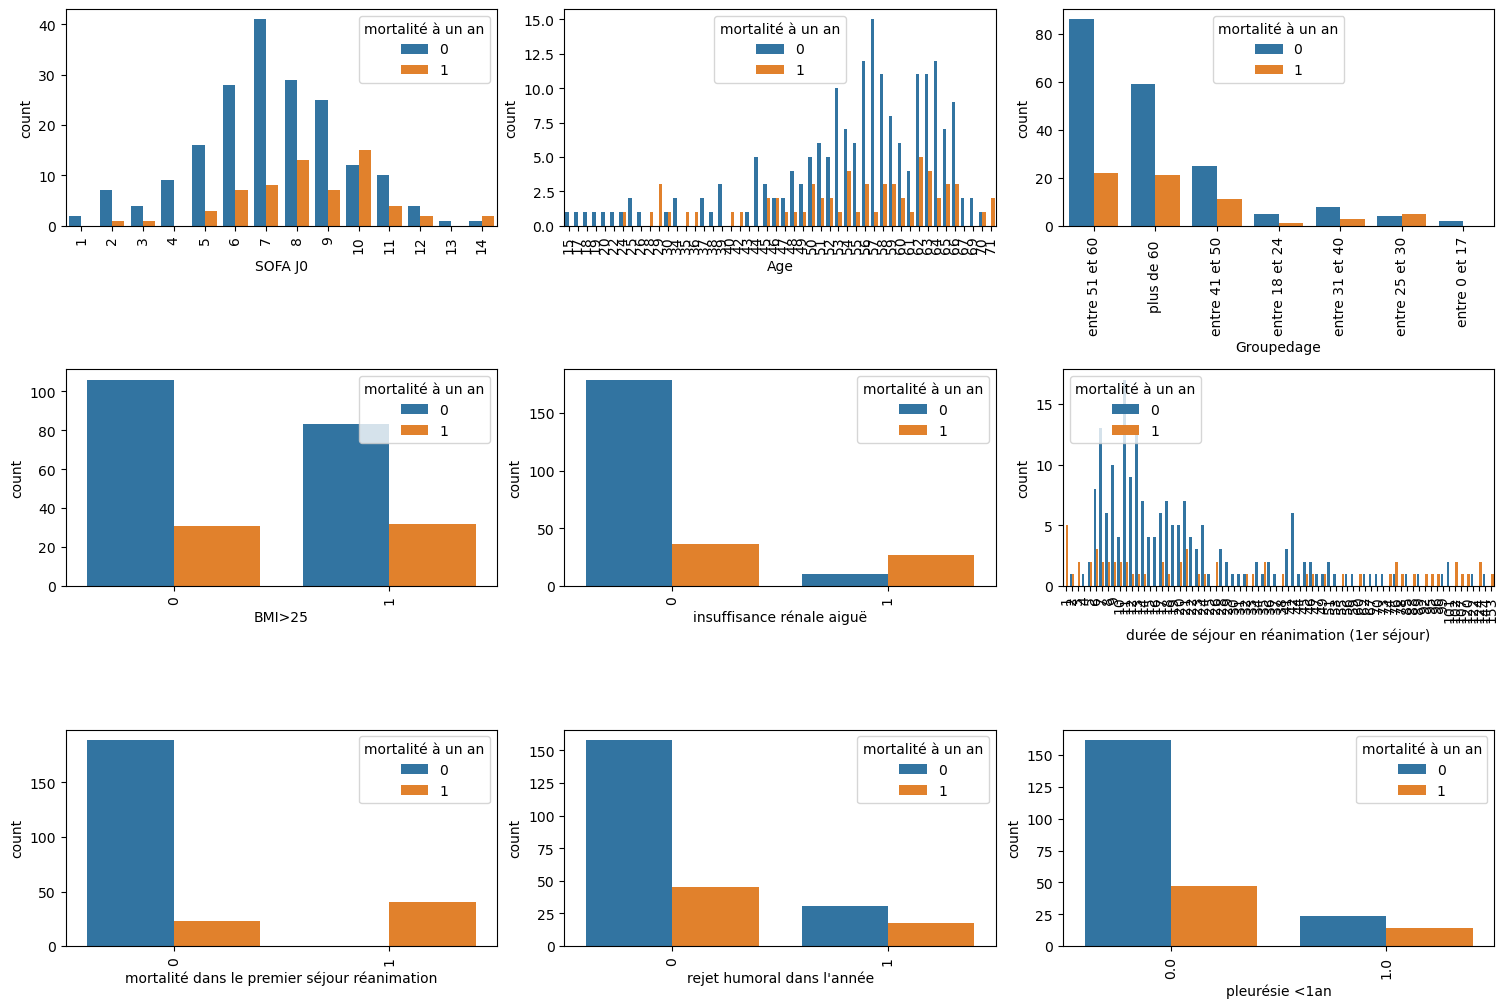

In [47]:
cat_vars = ['SOFA J0','Age', 'Groupedage','BMI>25','insuffisance rénale aiguë','durée de séjour en réanimation (1er séjour)','mortalité dans le premier séjour réanimation','rejet humoral dans l\'année','pleurésie <1an']

# create figure with subplots
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axs = axs.flatten()

# create barplot for each categorical variable
for i, var in enumerate(cat_vars):
    sns.countplot(x=var, hue='mortalité à un an', data=pulmonary_imp, ax=axs[i])
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)

# adjust spacing between subplots
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

# remove the sixth subplot
#fig.delaxes(axs[6])

# show plot

plt.show()

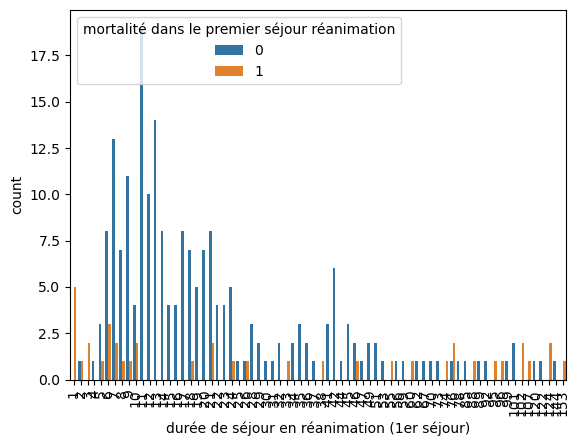

In [48]:
sns.countplot(x="durée de séjour en réanimation (1er séjour)", hue='mortalité dans le premier séjour réanimation', data=pulmonary_imp[["mortalité dans le premier séjour réanimation","durée de séjour en réanimation (1er séjour)"]])
plt.xticks(rotation=90)
plt.show()

In [49]:
X.columns

Index(['Age', 'Sexe (0=F, 1=M)', 'BMI (body mass index)', 'BMI< ou egal 18',
       'BMI>30', 'BMI>25', 'cardiopathie ischémique', 'diabètepré-opératoire',
       'PAPM (pression artérielle pulmonaire moyenne)', 'étiologie BPCO',
       'étiologie Fibrose', 'Autres étiologies', 'Mismatch CMV (R-/D+)',
       'ECMO pré-opératoire', 'Super Urgence',
       'type de TP (0=monopulmonaire, 1=bipulmonaire)', 'Ischémie Froide Max',
       'Analgésie péridurale ', 'ECMO peropératoire ',
       'Transfusion per opératoire >2 CGR', 'SOFA J0', 'IGS2 J0',
       'Nb Jours Noradrénaline ', 'Nb Jours Ventilation mécanique',
       'ECMO en Réanimation', 'Nb jours d'ECMO en réanimation',
       'Dysfonction primaire du greffon grade 3 ', 'insuffisance rénale aiguë',
       'dialyse en réanimation', 'bactériémie', 'Pneumonie (tous germes)',
       'Pneumonie à BLSE et/ou Pyo en réanimation',
       'Pneumonie acquise sous ventilation mécanique à BLSE et/ou Pyo',
       'Trachéotomie',
       'Sténose 

# Box plot

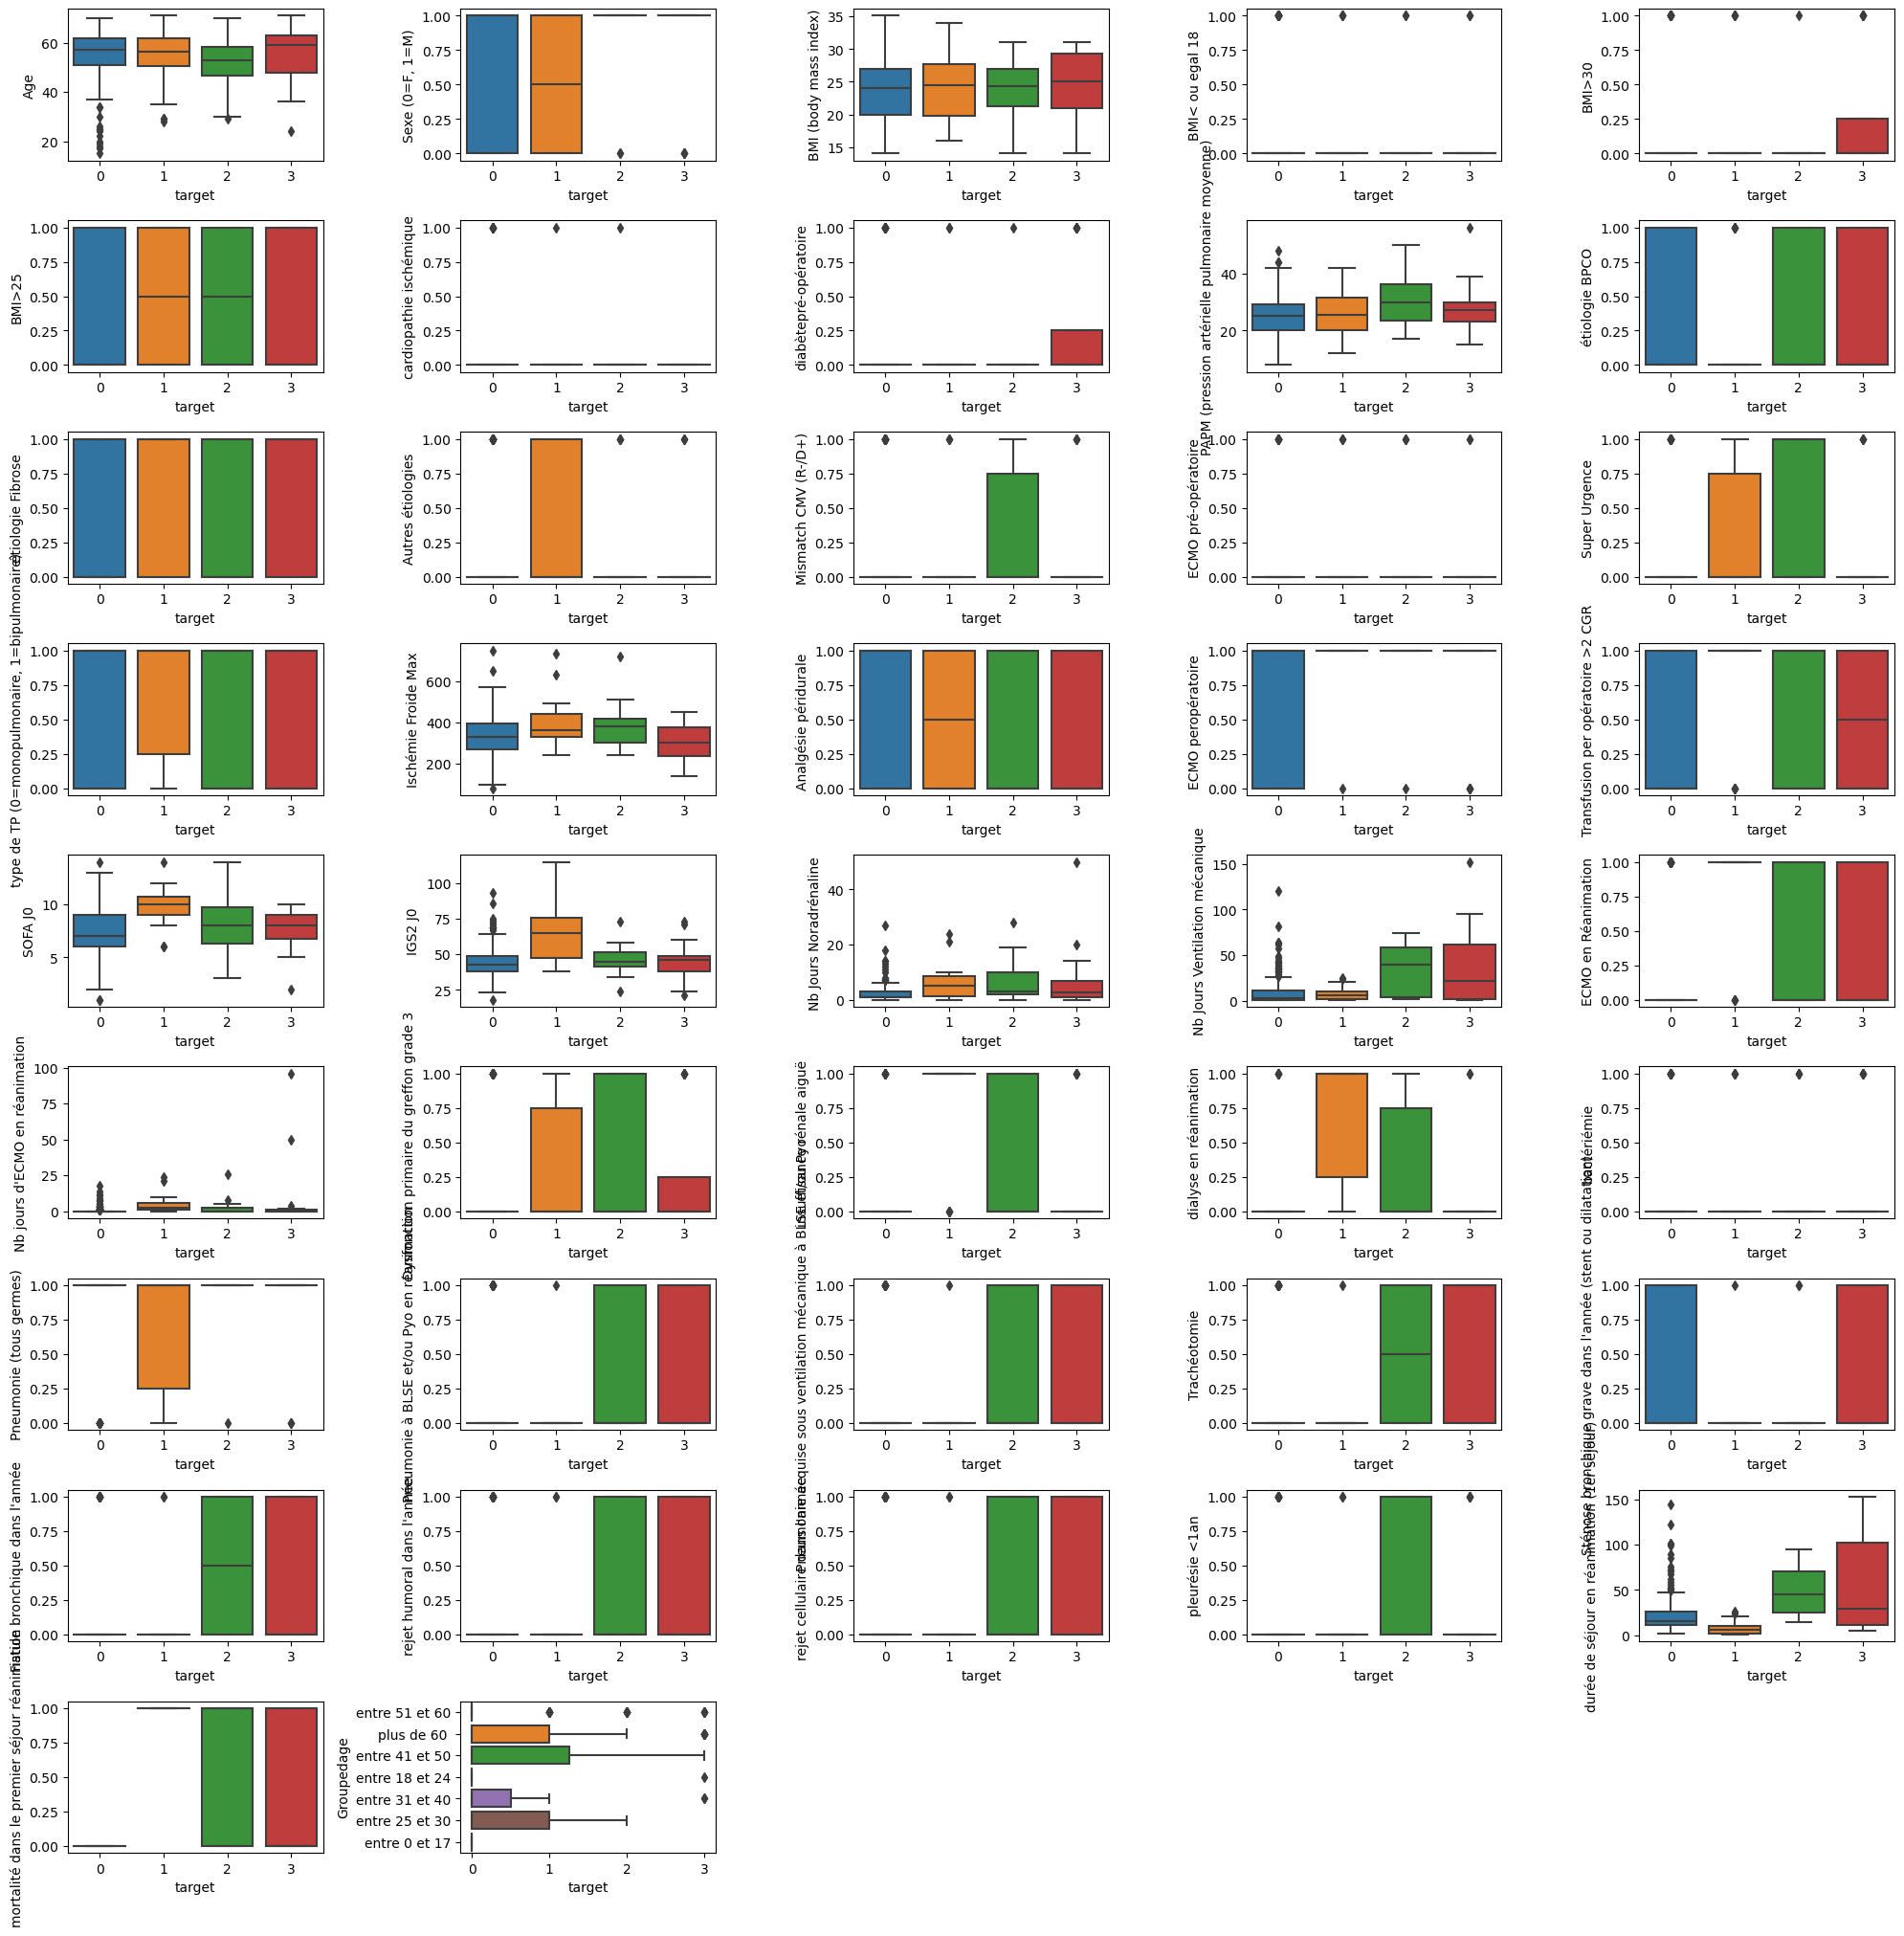

In [50]:
count=1
plt.subplots(figsize=(20, 20))

for i in X.columns:
    plt.subplot(9,5,count)
    sns.boxplot(data=pulmonary_imp, x='target', y = i,palette="tab10")
    count+=1

plt.tight_layout()
plt.show()

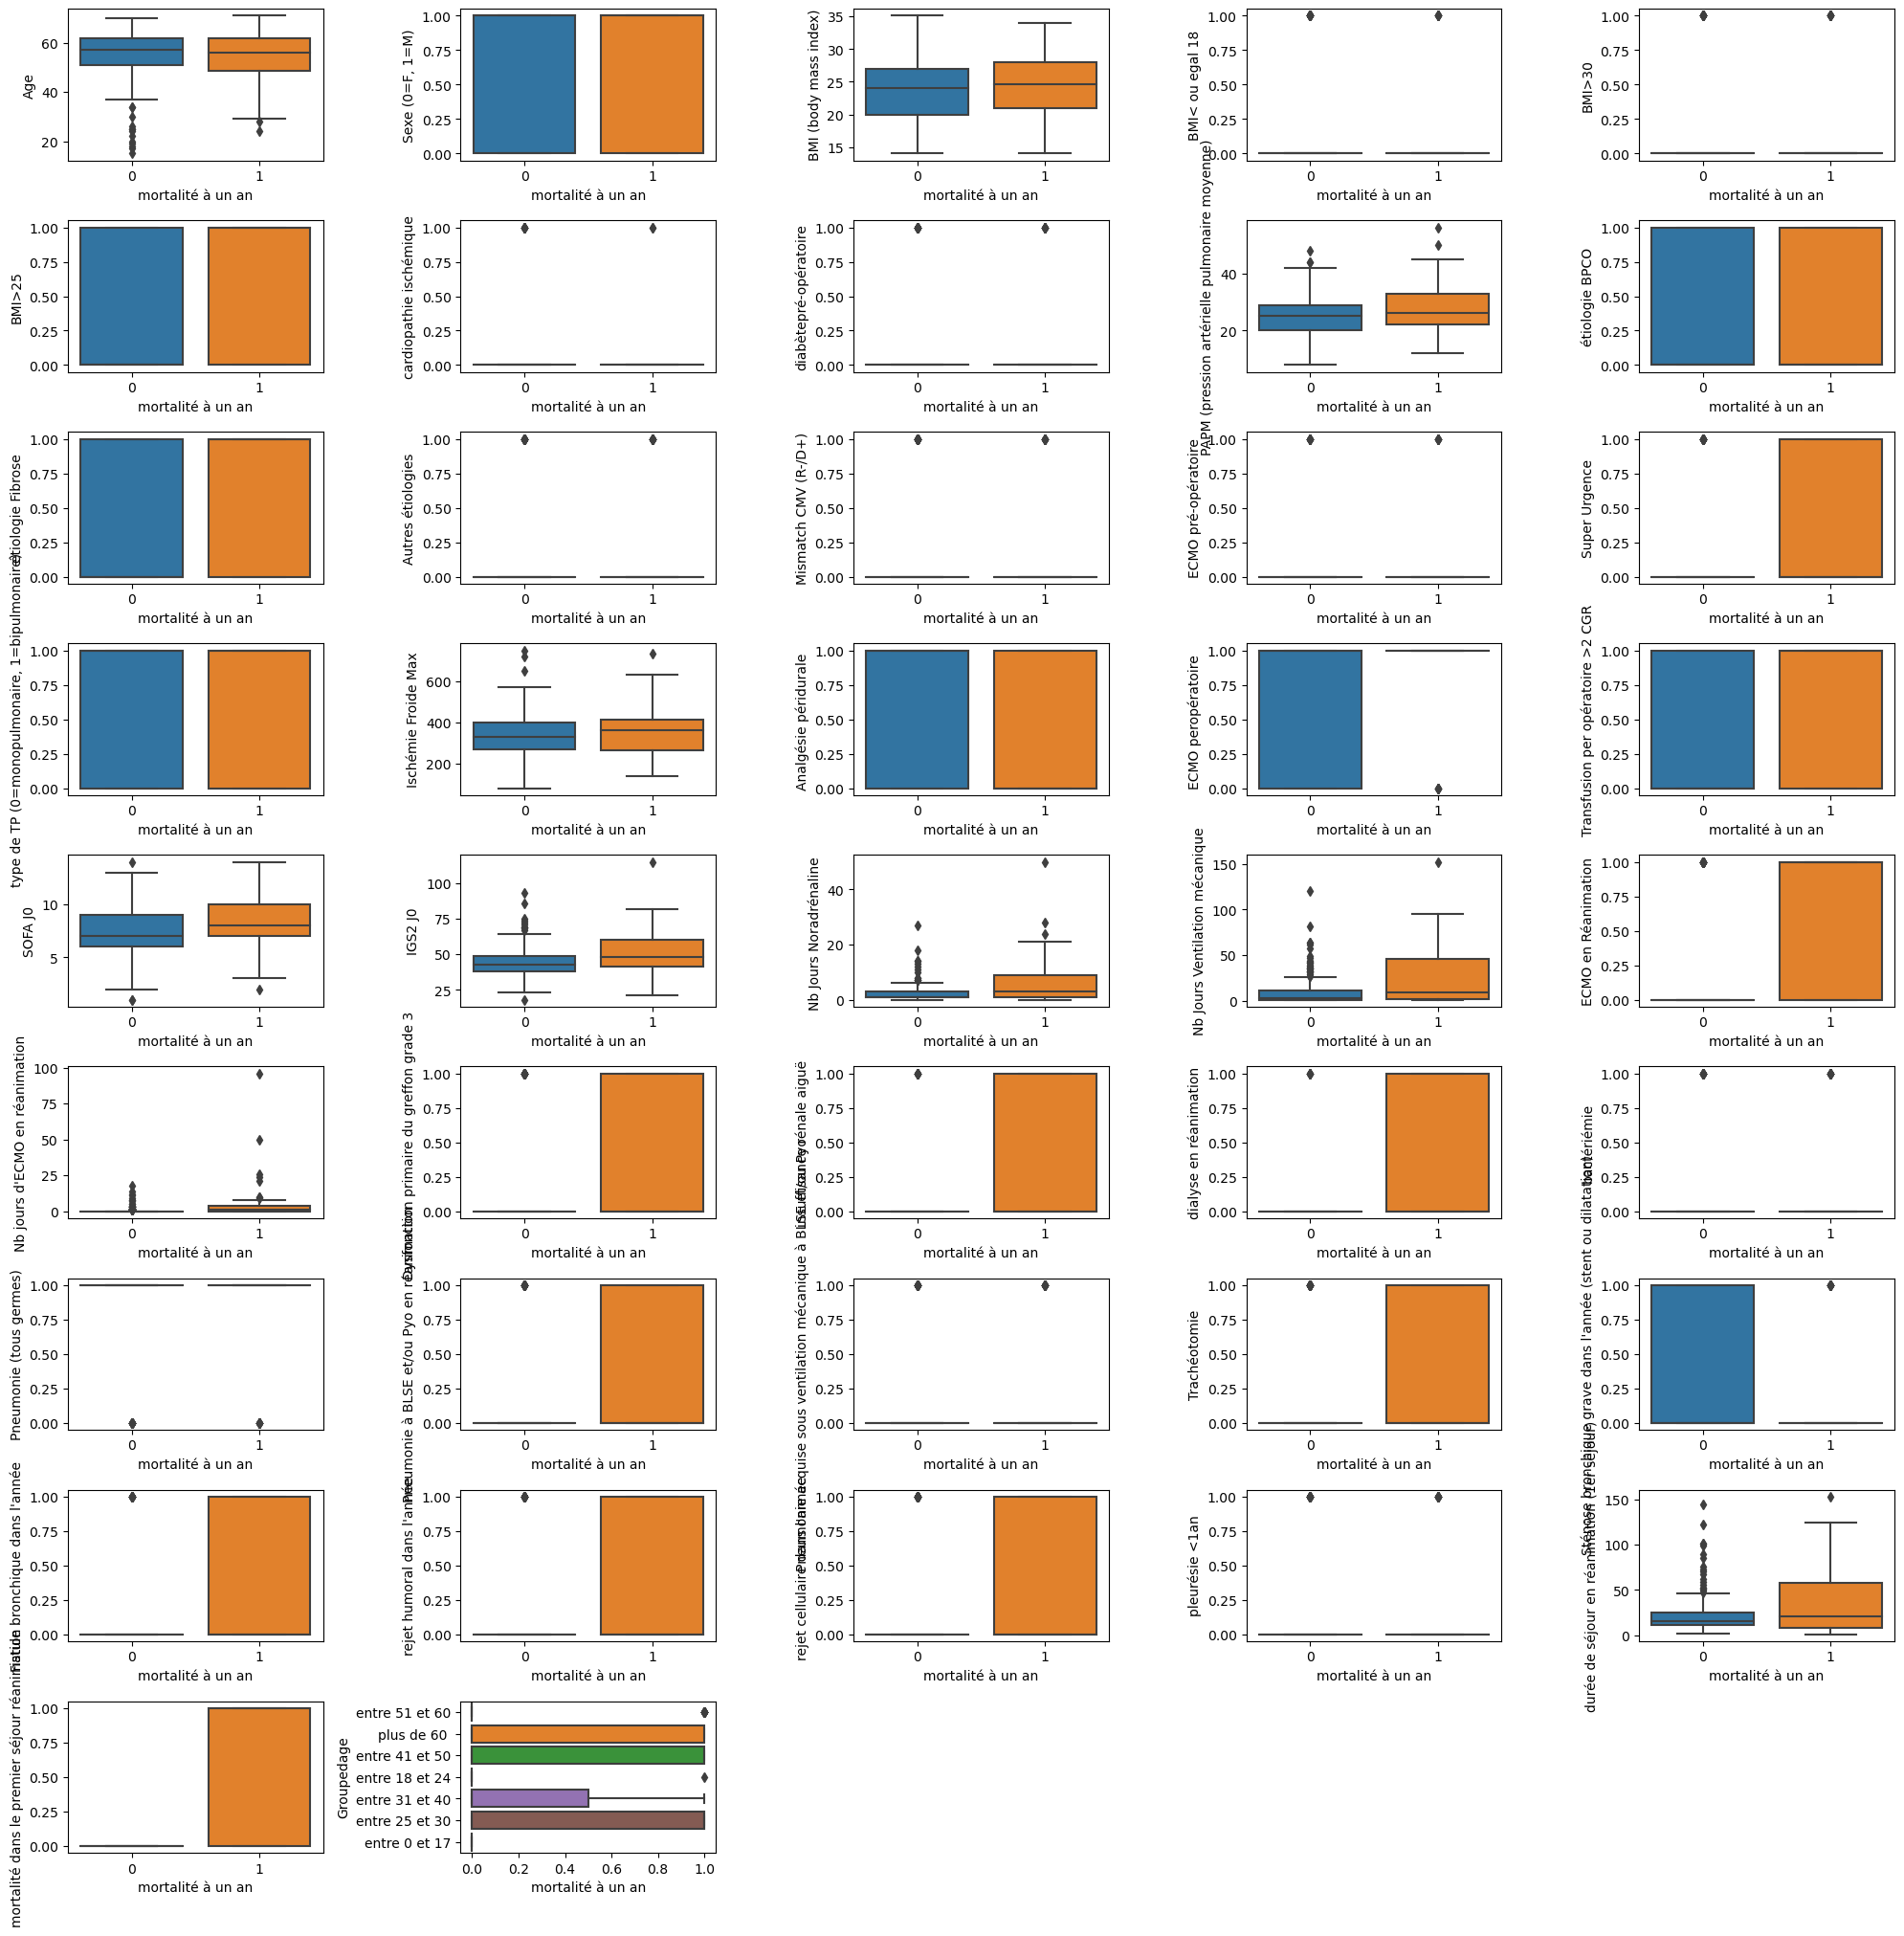

In [51]:
count=1
plt.subplots(figsize=(20, 20))

for i in X.columns:
    plt.subplot(9,5,count)
    sns.boxplot(data=pulmonary_imp, x='mortalité à un an', y = i,palette="tab10")
    count+=1

plt.tight_layout()
plt.show()

We might have some outliers from the boxpolts

# Data Cleaning

In [52]:
nulldata = pulmonary_imp[pulmonary_imp.isnull().any(axis=1)]

In [53]:
nulldata.shape

(44, 46)

In [54]:
def null_data_background(cell_value):

    highlight = 'background-color: darkorange;'
    default = ''

    if pd.isna(cell_value):
        return highlight
    return default

In [55]:
nulldata[['Sexe (0=F, 1=M)','Analgésie péridurale ']]

Sexe (0=F, 1=M)  Analgésie péridurale 
0                  0                    0.0
2                  1                    1.0
17                 1                    1.0
20                 0                    1.0
37                 1                    NaN
38                 0                    1.0
44                 1                    0.0
48                 0                    1.0
53                 1                    1.0
57                 0                    0.0
66                 1                    0.0
67                 1                    1.0
69                 1                    0.0
86                 1                    1.0
87                 0                    0.0
92                 1                    1.0
93                 1                    1.0
99                 0                    0.0
106                1                    1.0
110                1                    1.0
111                1                    1.0
113                0                    0.0
122                1                    0.0
123                1                    1.0
132                0                    1.0
139                1                    0.0
143                0                    0.0
149                1                    0.0
151                1                    1.0
153                1                    1.0
154                1                    0.0
157                1                    0.0
162                0                    0.0
169                1                    0.0
175                1                    0.0
193                1                    1.0
197                0                    1.0
201                0                    1.0
205                1                    0.0
209                0                    0.0
218                0                    0.0
226                0                    0.0
232                1                    0.0
250                1                    0.0

In [56]:
pulmonary_imp.columns[pulmonary_imp.isnull().any()]

Index(['PAPM (pression artérielle pulmonaire moyenne)', 'Autres étiologies',
       'Mismatch CMV (R-/D+)', 'Super Urgence', 'Ischémie Froide Max',
       'Analgésie péridurale ', 'Transfusion per opératoire >2 CGR',
       'Nb Jours Noradrénaline ', 'Pneumonie (tous germes)',
       'rejet cellulaire dans l'année ', 'pleurésie <1an'],
      dtype='object')

In [57]:
#Coloring nan cells
nulldata.style.applymap(null_data_background)

In [58]:
# Select the columns with missing values that you want to impute
null_columns = nulldata.columns[nulldata.isnull().any()].to_numpy()

In [59]:
null_columns = ['PAPM (pression artérielle pulmonaire moyenne)',
       'Autres étiologies', 'Mismatch CMV (R-/D+)', 'Super Urgence',
       'Ischémie Froide Max', 'Analgésie péridurale ',
       'Transfusion per opératoire >2 CGR', 'Nb Jours Noradrénaline ',
       'Pneumonie (tous germes)', "rejet cellulaire dans l'année ",
       'pleurésie <1an']

# Managing null values

In [60]:
#MULTIINTERPOLATION

# Create an IterativeImputer object
imputer = IterativeImputer(max_iter=10, random_state=0)  # Adjust max_iter if needed

# Fit and transform the imputer on your DataFrame
imputed_data = imputer.fit_transform(pulmonary_imp[null_columns])

# Convert the imputed data back to a DataFrame
df_imputed = pd.DataFrame(imputed_data, columns=null_columns)
#print(df_imputed)
# Combine the imputed columns with the original DataFrame
df_imputed = pd.concat([pulmonary_imp.drop(null_columns, axis=1),df_imputed], axis=1)


In [61]:
[df_imputed[col_name].unique() for col_name in df_imputed[null_columns].columns]

[array([25.99891692, 29.        , 25.        , 16.        , 17.        ,
        22.        , 21.        , 12.        , 26.        , 23.        ,
        36.        , 25.43078751, 38.        , 27.        , 14.        ,
        50.        , 10.        , 32.        , 34.        , 20.        ,
        19.        , 15.        , 24.        , 25.71167553, 25.72486131,
        39.        , 28.        , 18.        , 25.7234272 , 33.        ,
        35.        , 25.97217293, 30.        , 26.07614882, 42.        ,
        56.        , 25.45643886, 25.66313546,  8.        , 31.        ,
        44.        , 40.        , 25.81822476, 26.28194706, 37.        ,
        25.45590299, 48.        , 25.63751744, 25.3533268 , 26.0892928 ,
        13.        , 25.50832103, 25.63747979, 25.50796783, 25.41457532,
        11.        , 25.74056277, 26.02475848, 45.        , 25.77859462,
        25.50814282, 41.        ]),
 array([0.        , 1.        , 0.27131608, 0.09614111]),
 array([0.        , 1.        

In [62]:
data = df_imputed.copy()
datas = df_imputed.copy()

In [63]:
nulldata = df_imputed[df_imputed.isnull().any(axis=1)]

In [64]:
nulldata

Empty DataFrame
Columns: [Age, Sexe (0=F, 1=M), BMI (body mass index), BMI< ou egal 18, BMI>30, BMI>25, cardiopathie ischémique, diabètepré-opératoire, étiologie BPCO, étiologie Fibrose, ECMO pré-opératoire, type de TP (0=monopulmonaire, 1=bipulmonaire), ECMO peropératoire , SOFA J0, IGS2 J0, Nb Jours Ventilation mécanique, ECMO en Réanimation, Nb jours d'ECMO en réanimation, Dysfonction primaire du greffon grade 3 , insuffisance rénale aiguë, dialyse en réanimation, bactériémie, Pneumonie à BLSE et/ou Pyo en réanimation, Pneumonie acquise sous ventilation mécanique à BLSE et/ou Pyo, Trachéotomie, Sténose bronchique grave dans l'année (stent ou dilatation), Fistule bronchique dans l'année, rejet humoral dans l'année, durée de séjour en réanimation (1er séjour), mortalité dans le premier séjour réanimation, mortalité à un an, mortalité à 90j, mortalité à J30, target, Groupedage, PAPM (pression artérielle pulmonaire moyenne), Autres étiologies, Mismatch CMV (R-/D+), Super Urgence, Ischémie Froide Max, Analgésie péridurale , Transfusion per opératoire >2 CGR, Nb Jours Noradrénaline , Pneumonie (tous germes), rejet cellulaire dans l'année , pleurésie <1an]
Index: []

[0 rows x 46 columns]

In [65]:
# Defining feature and target set as X and Y respectively
X, Y = df_imputed.drop(['mortalité à J30','mortalité à 90j','mortalité à un an','target'],axis=1), df_imputed[['mortalité à J30','mortalité à 90j','mortalité à un an','target']]

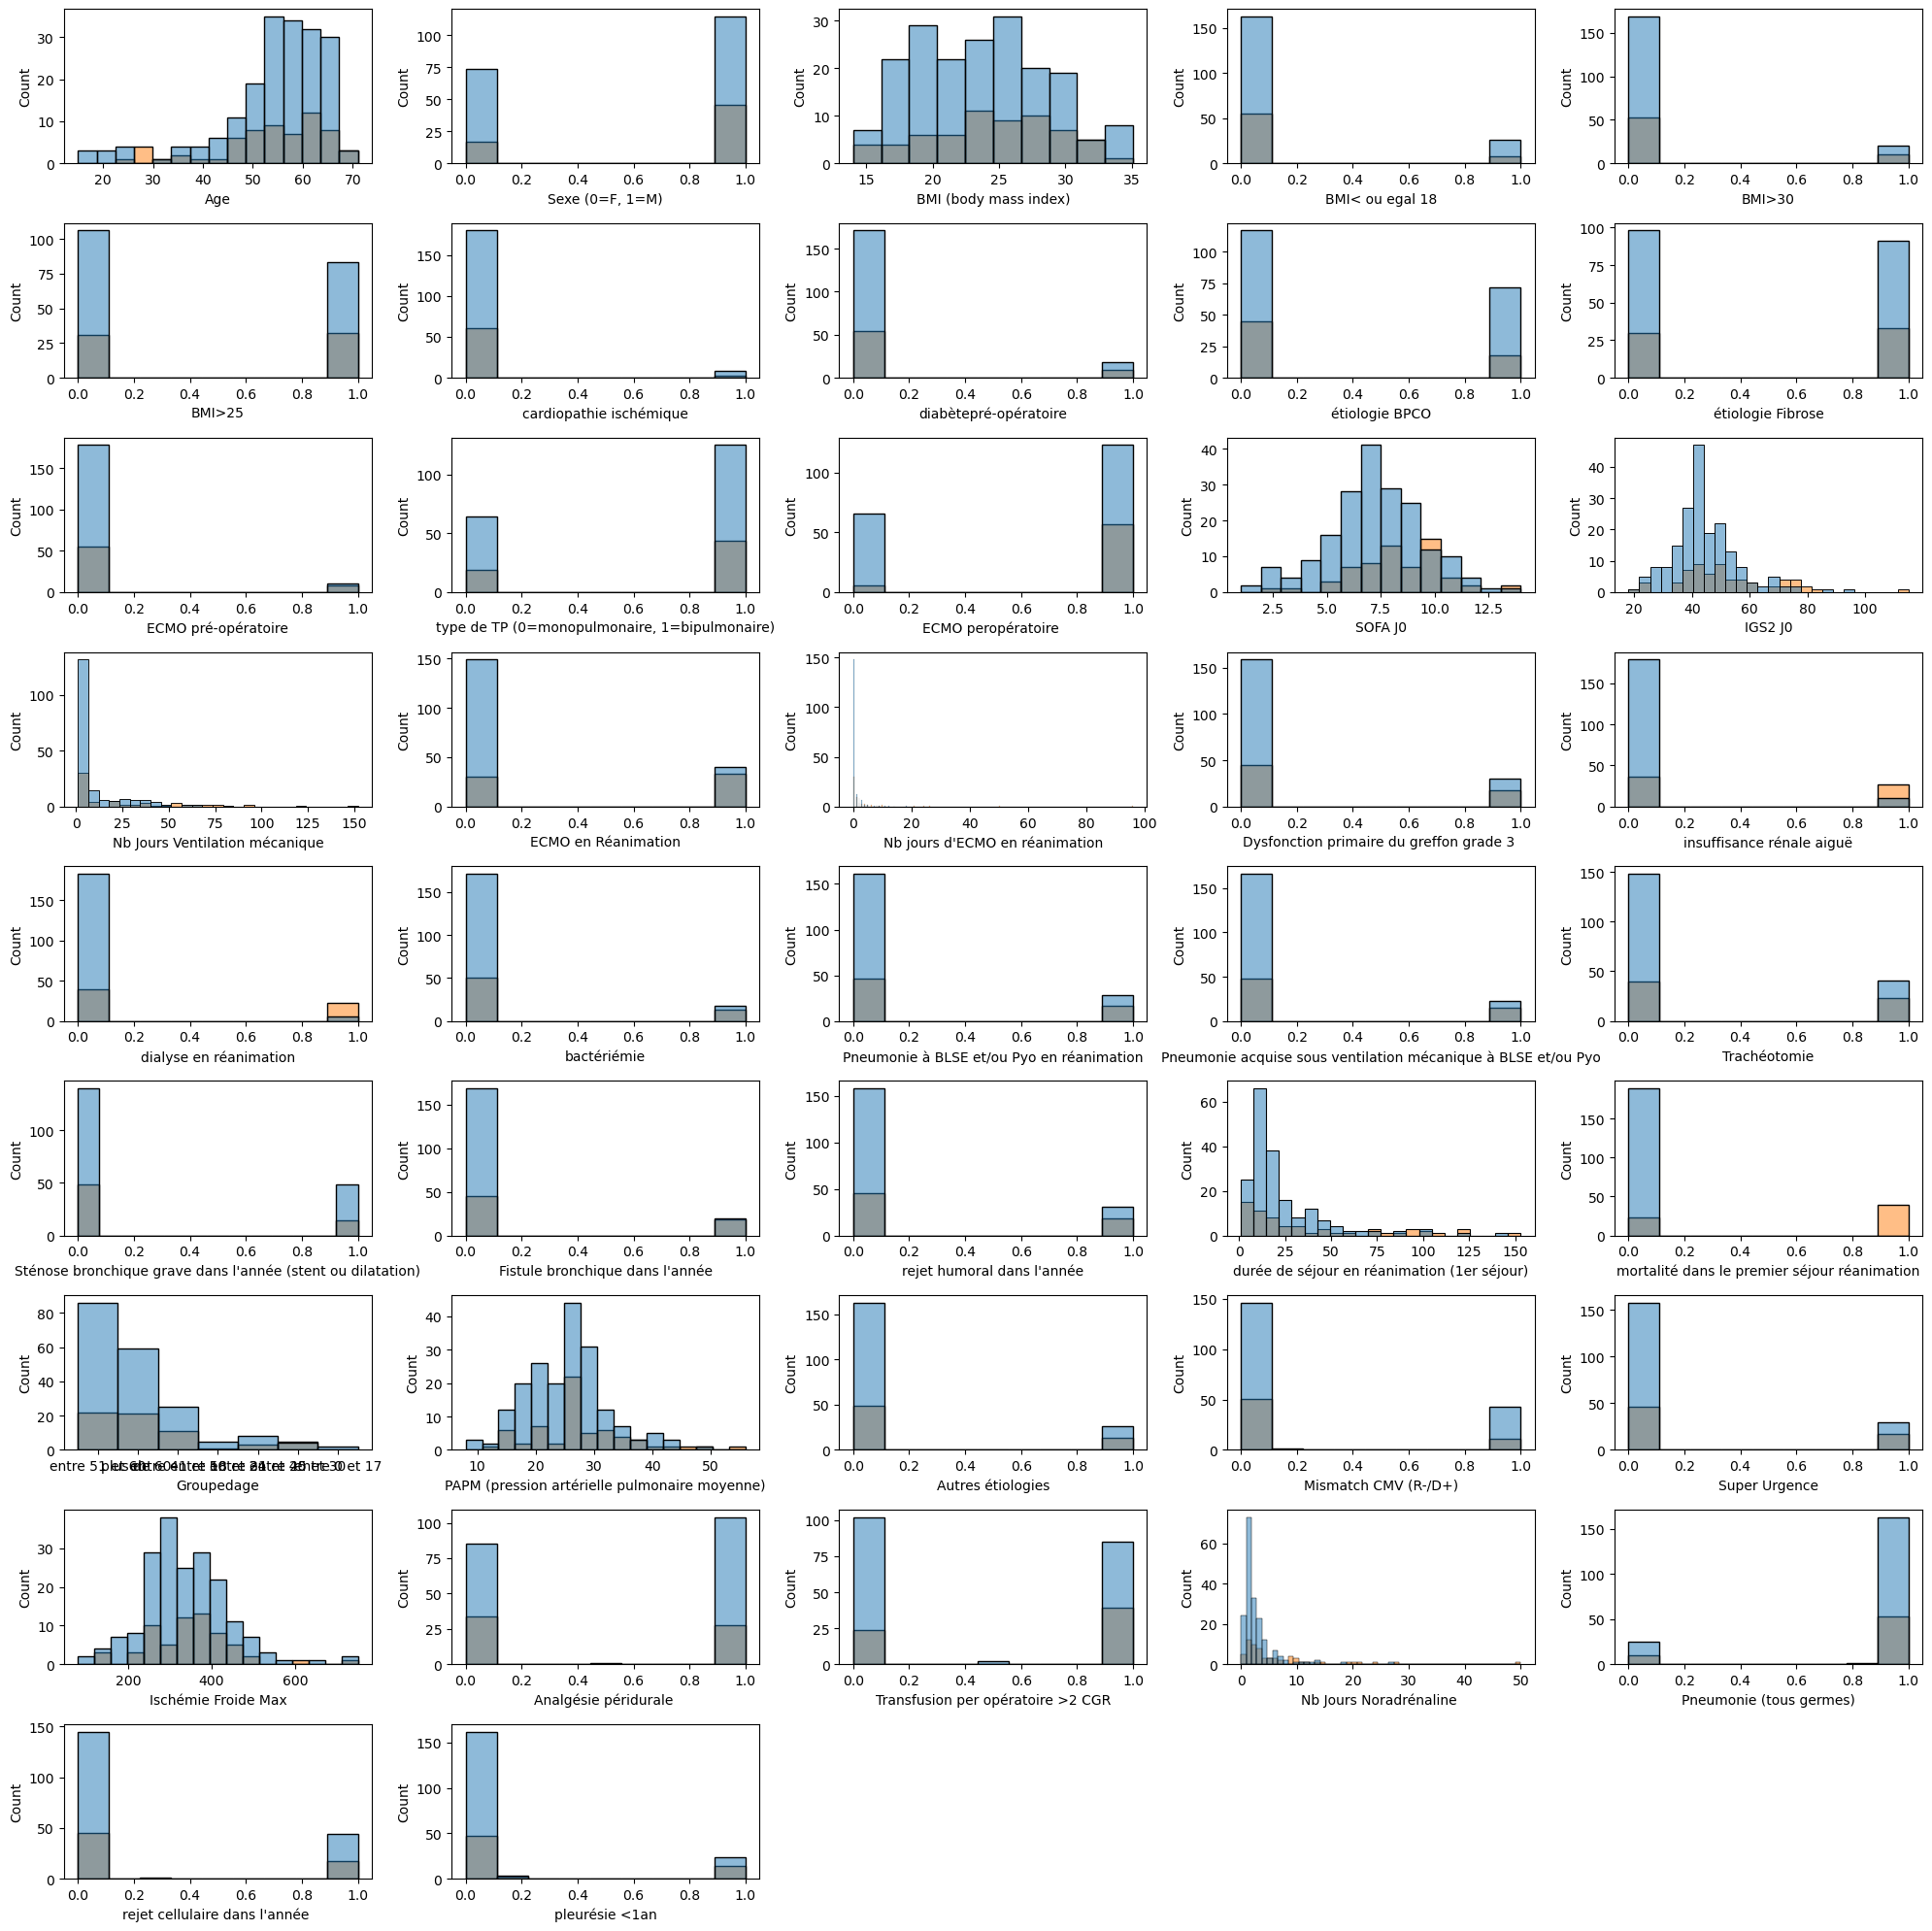

In [66]:
count=1
plt.subplots(figsize=(20, 20))

for i in X.columns:
    plt.subplot(9,5,count)
    sns.histplot(data=data, hue='mortalité à un an', x = i,palette="tab10").legend([],[], frameon=False)
    count+=1

plt.tight_layout()
plt.show()

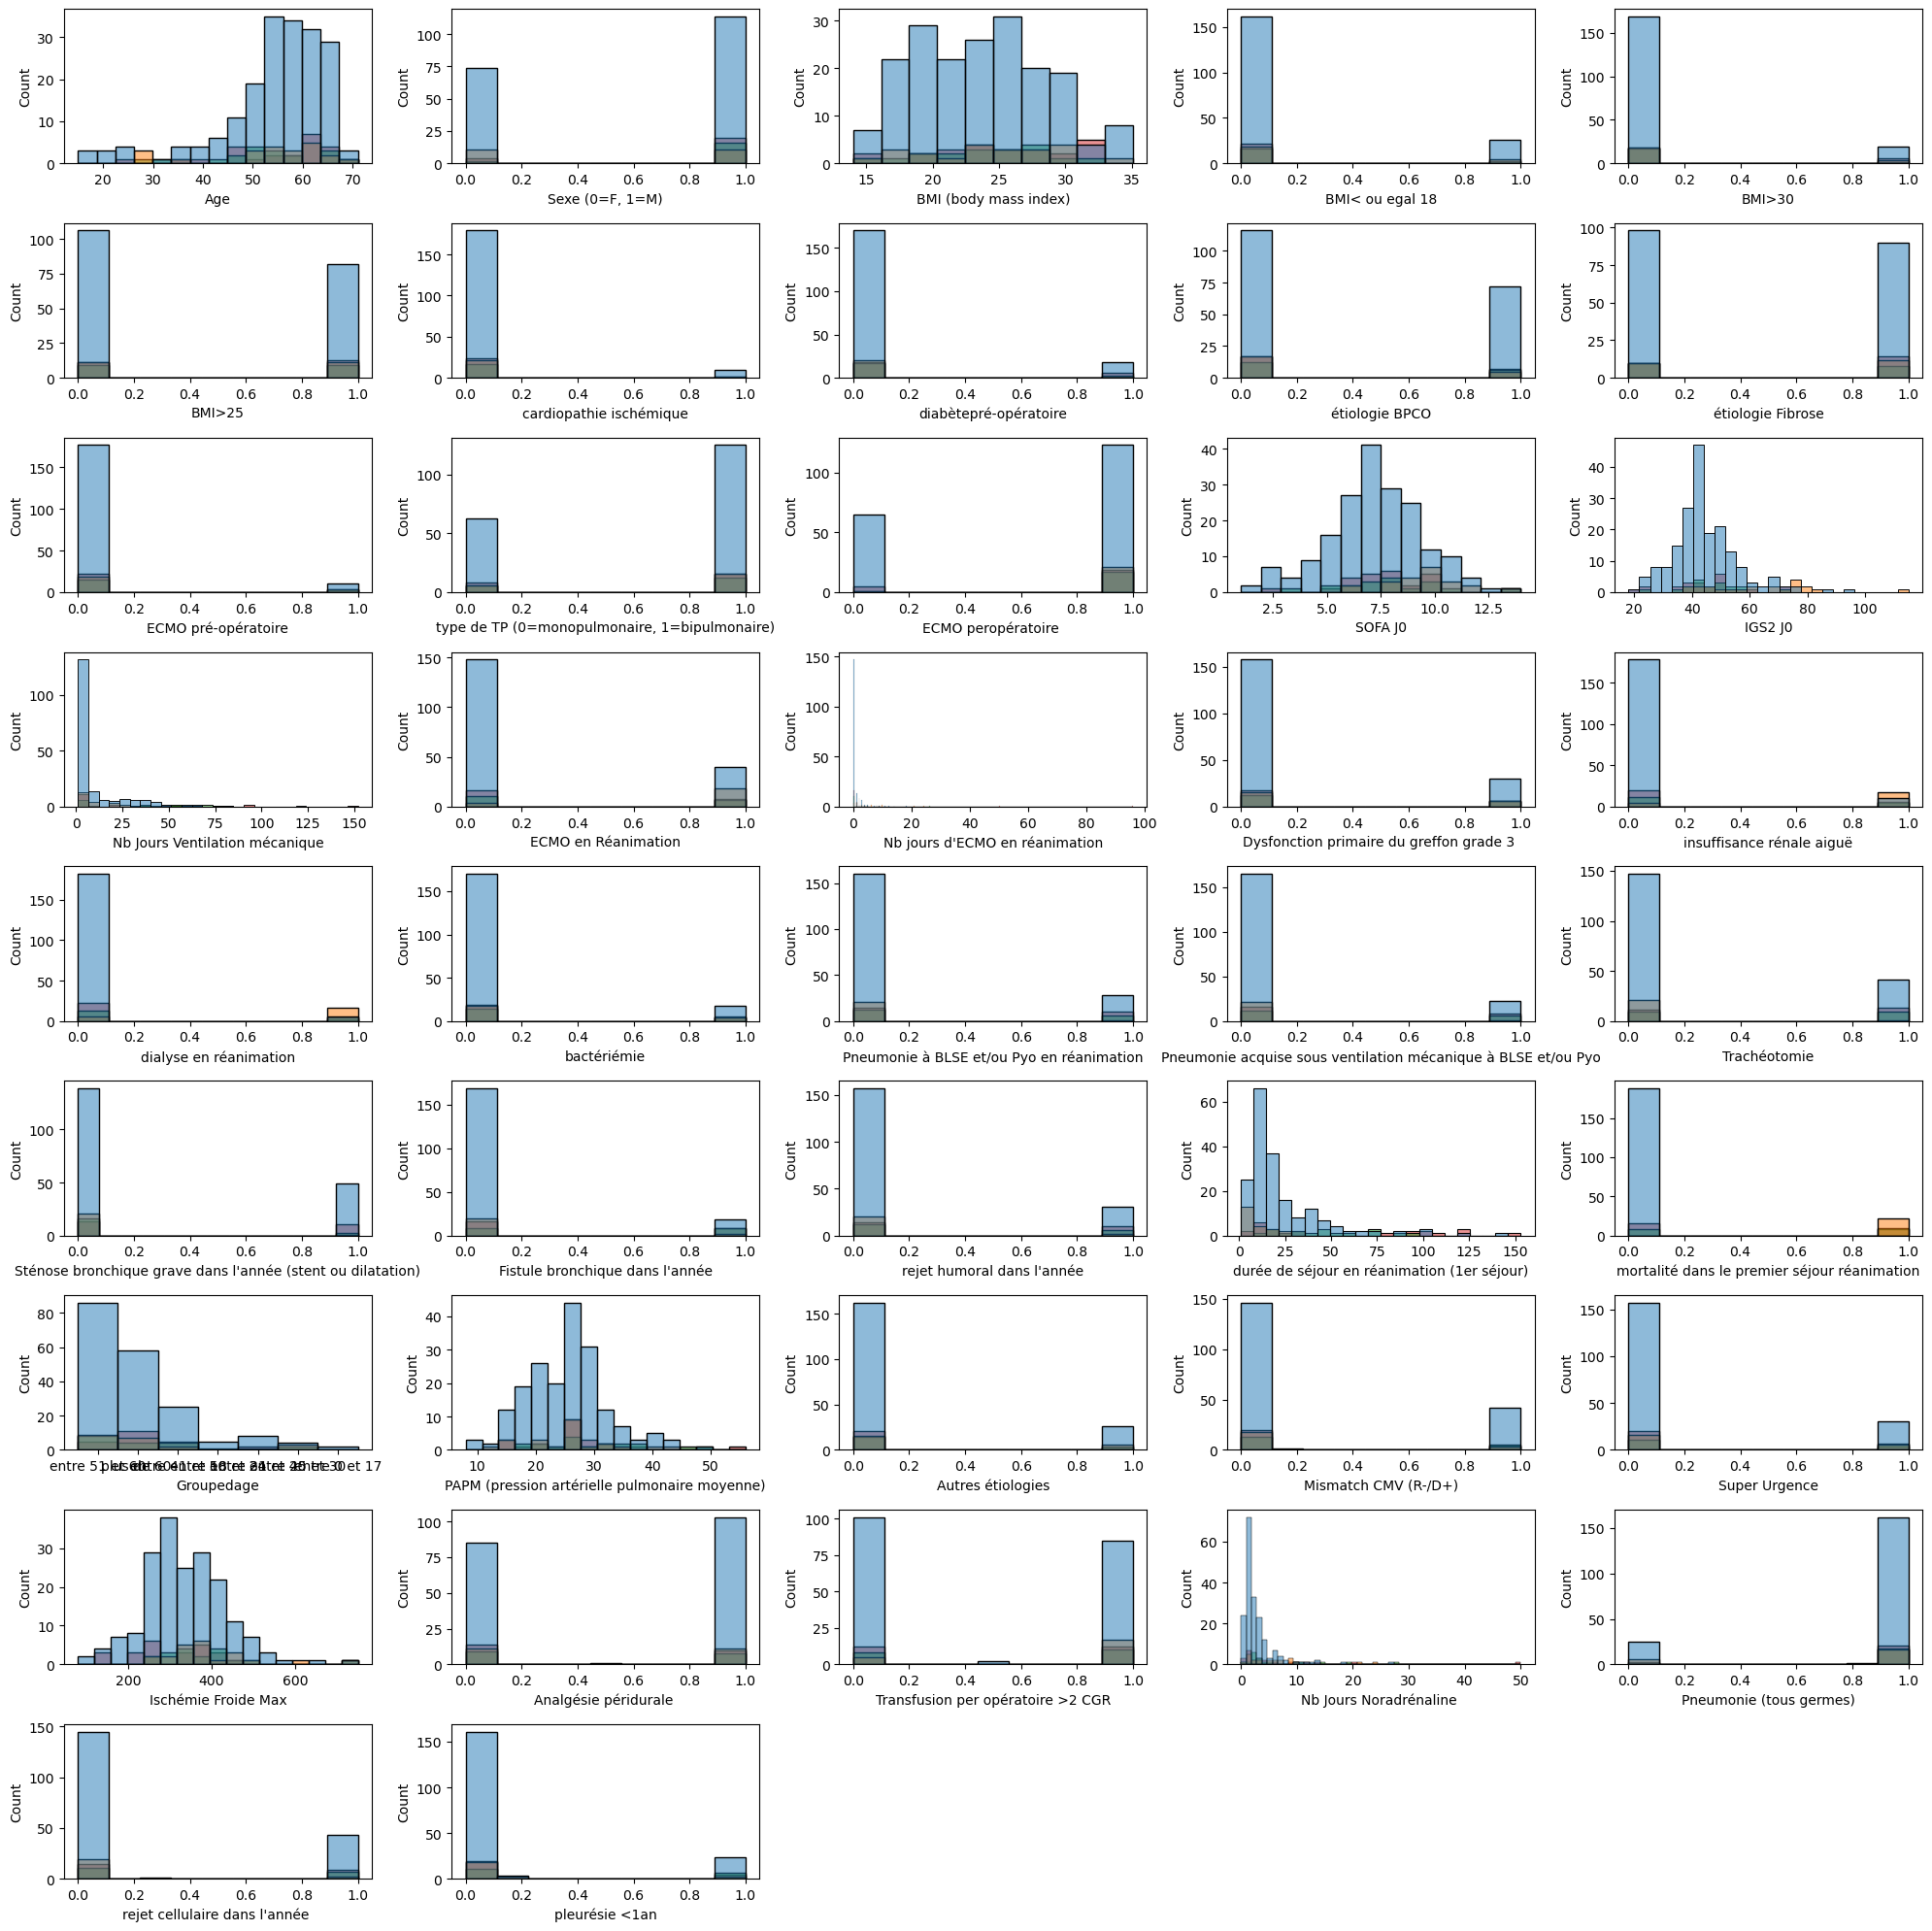

In [67]:
count=1
plt.subplots(figsize=(20, 20))

for i in X.columns:
    plt.subplot(9,5,count)
    sns.histplot(data=data, hue='target', x = i,palette="tab10").legend([],[], frameon=False)
    count+=1

plt.tight_layout()
plt.show()

# Outlier Detection

In [68]:
# Defining feature and target set as X and Y respectively
X, Y = data.drop(['mortalité dans le premier séjour réanimation','mortalité à J30','mortalité à 90j','mortalité à un an','target','Groupedage'],axis=1), data[['mortalité dans le premier séjour réanimation','mortalité à J30','mortalité à 90j','mortalité à un an','target']]

In [69]:
X.reset_index(inplace=True)

Iso = IsolationForest(random_state=7)

Iso.fit(X)
pred_iso = Iso.predict(X)

X['anomaly'] = pred_iso

outliers=X.loc[X['anomaly']==-1]
outlier_index=list(outliers.index)

print(X['anomaly'].value_counts())



 1    174
-1     78
Name: anomaly, dtype: int64


We can observe that 32.94% of values could contain outlier.
I am not going to remove outliers from the data set because it may contain important information for the analysis.

**What will be the performance of our model if outliers where deleted?**

# Normalisation
There are different methods for data normalization, including:

Min-Max Scaling: This method scales the data to a specific range, typically between 0 and 1. It is achieved by subtracting the minimum value of the feature and dividing by the range (maximum value minus the minimum value). The formula is:

X_scaled = (X - X_min) / (X_max - X_min)

Z-Score Normalization: Also known as standardization, this method transforms the data to have a mean of 0 and a standard deviation of 1. It is achieved by subtracting the mean value of the feature and dividing by the standard deviation. The formula is:

X_scaled = (X - X_mean) / X_std

Decimal Scaling: In this method, the data is scaled by dividing it by an appropriate power of 10. The power of 10 is determined based on the maximum absolute value of the feature. The formula is:
X_scaled = X / (10^k)


### We are goin to use Z-score Normalisation

In [70]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X)

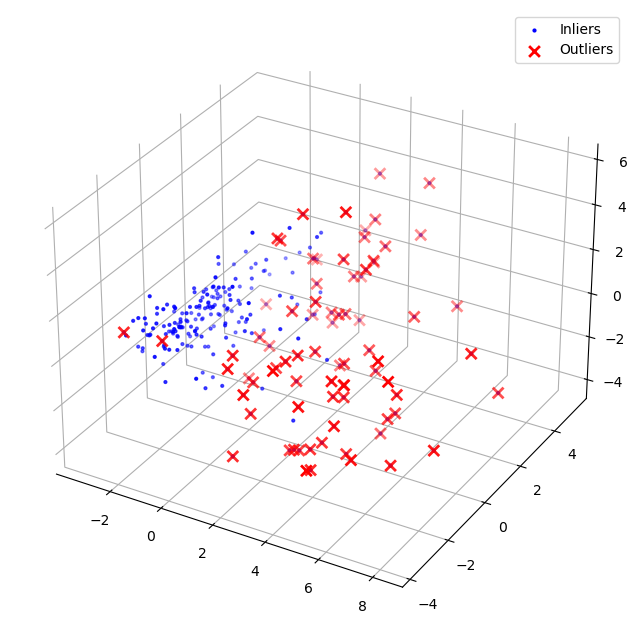

In [71]:
# To represent outliers visually a 3D PCA is needed
pca3 = PCA(n_components=3)

X_reduce = pca3.fit_transform(data_scaled)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Inliers
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="Inliers",c="blue")
# Outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="Outliers")
# Adding Grid
ax.grid(True)
ax.w_xaxis.pane.set_color('w')
ax.w_yaxis.pane.set_color('w')
ax.w_zaxis.pane.set_color('w')
plt.rcParams['grid.color'] = "black"
plt.rcParams['lines.linewidth'] = 1
ax.legend()
plt.show()

# Correlation Matrix

In [72]:
corr = X.corr()
corr

index       Age  \
index                                               1.000000 -0.086886   
Age                                                -0.086886  1.000000   
Sexe (0=F, 1=M)                                     0.018796  0.136911   
BMI (body mass index)                              -0.000712  0.247099   
BMI< ou egal 18                                     0.064347 -0.320164   
BMI>30                                              0.000168  0.009596   
BMI>25                                              0.038824  0.139496   
cardiopathie ischémique                             0.003604  0.094047   
diabètepré-opératoire                               0.014021 -0.064865   
étiologie BPCO                                     -0.019240  0.174468   
étiologie Fibrose                                   0.073542  0.187147   
ECMO pré-opératoire                                -0.023243 -0.216684   
type de TP (0=monopulmonaire, 1=bipulmonaire)      -0.007370 -0.397839   
ECMO peropératoire                                 -0.000845 -0.104783   
SOFA J0                                             0.046340 -0.096307   
IGS2 J0                                            -0.079805  0.099135   
Nb Jours Ventilation mécanique                     -0.007020 -0.058752   
ECMO en Réanimation                                -0.031567 -0.144632   
Nb jours d'ECMO en réanimation                      0.074834 -0.117245   
Dysfonction primaire du greffon grade 3             0.030701 -0.061345   
insuffisance rénale aiguë                          -0.007475 -0.044929   
dialyse en réanimation                             -0.052564 -0.092801   
bactériémie                                        -0.030808 -0.084116   
Pneumonie à BLSE et/ou Pyo en réanimation           0.030836 -0.042431   
Pneumonie acquise sous ventilation mécanique à ...  0.017378 -0.075920   
Trachéotomie                                       -0.024062 -0.148061   
Sténose bronchique grave dans l'année (stent ou...  0.057887  0.002082   
Fistule bronchique dans l'année                    -0.055335  0.101413   
rejet humoral dans l'année                          0.031081 -0.185899   
durée de séjour en réanimation (1er séjour)        -0.021154 -0.059482   
PAPM (pression artérielle pulmonaire moyenne)      -0.019329 -0.037279   
Autres étiologies                                  -0.073411 -0.479485   
Mismatch CMV (R-/D+)                               -0.013600 -0.014553   
Super Urgence                                       0.017196 -0.181992   
Ischémie Froide Max                                -0.017756 -0.134590   
Analgésie péridurale                               -0.036839  0.114496   
Transfusion per opératoire >2 CGR                  -0.100046 -0.250140   
Nb Jours Noradrénaline                              0.098877 -0.063921   
Pneumonie (tous germes)                             0.096441 -0.120550   
rejet cellulaire dans l'année                       0.108473  0.093537   
pleurésie <1an                                      0.015435 -0.011010   
anomaly                                            -0.011446  0.221647   

                                                    Sexe (0=F, 1=M)  \
index                                                      0.018796   
Age                                                        0.136911   
Sexe (0=F, 1=M)                                            1.000000   
BMI (body mass index)                                      0.167448   
BMI< ou egal 18                                           -0.162559   
BMI>30                                                     0.046770   
BMI>25                                                     0.141447   
cardiopathie ischémique                                    0.120183   
diabètepré-opératoire                                      0.046745   
étiologie BPCO                                            -0.094831   
étiologie Fibrose                                          0.178107   
ECMO pré-opératoire 

In [73]:
corr.style.background_gradient(cmap='coolwarm')

In [74]:
#Looking at corrolated variables
dim = len(corr)
tmp_corr = pd.DataFrame(columns=['Index', 'Header','corr'])
i = 1
while i < dim:
  indices = corr.index[i]
  j = 0
  while j < i:
    if corr.iloc[i,j] >= 0.7:
          header = corr.columns[j]
          tmp_corr.loc[len(tmp_corr)] = [indices, header,corr.iloc[i,j]]
    j = j +1
  i = i+1


tmp_corr

Index  \
0                                             BMI>25   
1                             dialyse en réanimation   
2  Pneumonie acquise sous ventilation mécanique à...   
3                                       Trachéotomie   
4        durée de séjour en réanimation (1er séjour)   
5        durée de séjour en réanimation (1er séjour)   

                                      Header      corr  
0                      BMI (body mass index)  0.827542  
1                  insuffisance rénale aiguë  0.869291  
2  Pneumonie à BLSE et/ou Pyo en réanimation  0.903782  
3             Nb Jours Ventilation mécanique  0.762775  
4             Nb Jours Ventilation mécanique  0.890337  
5                               Trachéotomie  0.755318

# Clustering Algorithms

# K-Means

In [722]:
def kmeans_method(df,n_cluster_f):

 fig = plt.figure(figsize=(16,4))
 plt.subplot(1, 2, 1)
 # within-cluster sum of squares (WCSS)
 wcss = []
 for n_cluster in range(1, 20):
    kmeans = KMeans(n_cluster, random_state = 0)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)
 plt.plot(range(1, 20), wcss)
 plt.title('The Elbow Method', fontsize = 20)
 plt.xlabel('Number of Clusters')
 plt.ylabel('Within-cluster sum of squares')

 plt.subplot(1, 2, 2)
 kmeans = KMeans(n_cluster_f, random_state = 0)
 ymeans = kmeans.fit(df)

#Get the cluster labels and centroids
 cluster_labels = kmeans.labels_
 centroids = kmeans.cluster_centers_

  #Evaluate the clustering result
 wcss = kmeans.inertia_
 silhouette_avg = silhouette_score(df, cluster_labels)

  # Step 10: Print the results
 print("Cluster Labels:", cluster_labels)
 print("WCSS:", wcss)
 print("Silhouette Score:", silhouette_avg)


 plt.scatter(df['SOFA J0'], df['durée de séjour en réanimation (1er séjour)'], c=kmeans.labels_, cmap="Set1_r", s=25)
 plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black', marker="x", s=250)
 plt.title("Kmeans Clustering", fontsize=20)
 plt.xlabel('SOFA J0')
 plt.ylabel('durée de séjour en réanimation (1er séjour)')
 return kmeans.labels_

In [723]:
#convert scaled data to dataframe
df = pd.DataFrame(data_scaled, columns=X.columns)

In [724]:
df.columns

Index(['index', 'Age', 'Sexe (0=F, 1=M)', 'BMI (body mass index)',
       'BMI< ou egal 18', 'BMI>30', 'BMI>25', 'cardiopathie ischémique',
       'diabètepré-opératoire', 'étiologie BPCO', 'étiologie Fibrose',
       'ECMO pré-opératoire', 'type de TP (0=monopulmonaire, 1=bipulmonaire)',
       'ECMO peropératoire ', 'SOFA J0', 'IGS2 J0',
       'Nb Jours Ventilation mécanique', 'ECMO en Réanimation',
       'Nb jours d'ECMO en réanimation',
       'Dysfonction primaire du greffon grade 3 ', 'insuffisance rénale aiguë',
       'dialyse en réanimation', 'bactériémie',
       'Pneumonie à BLSE et/ou Pyo en réanimation',
       'Pneumonie acquise sous ventilation mécanique à BLSE et/ou Pyo',
       'Trachéotomie',
       'Sténose bronchique grave dans l'année (stent ou dilatation)',
       'Fistule bronchique dans l'année', 'rejet humoral dans l'année',
       'durée de séjour en réanimation (1er séjour)',
       'PAPM (pression artérielle pulmonaire moyenne)', 'Autres étiologies',
     

In [725]:
df.drop(['index', 'anomaly'],axis=1,inplace=True)

Cluster Labels: [1 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 1 1 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0
 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 1 1 0 1 0 0 0 0 0
 0 0 0 0 1 0 0 1 1 0 0 0 1 0 1 0 1 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1
 0 1 1 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0
 0 1 0 0 1 0 1 0 1 1 0 0 1 1 1 0 1 0 0 0 1 1 0 1 0 0 1 1 1 0 0 0 0 0 0 1 0
 0 0 1 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0
 1 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0]
WCSS: 9000.94469383901
Silhouette Score: 0.1570318502368284


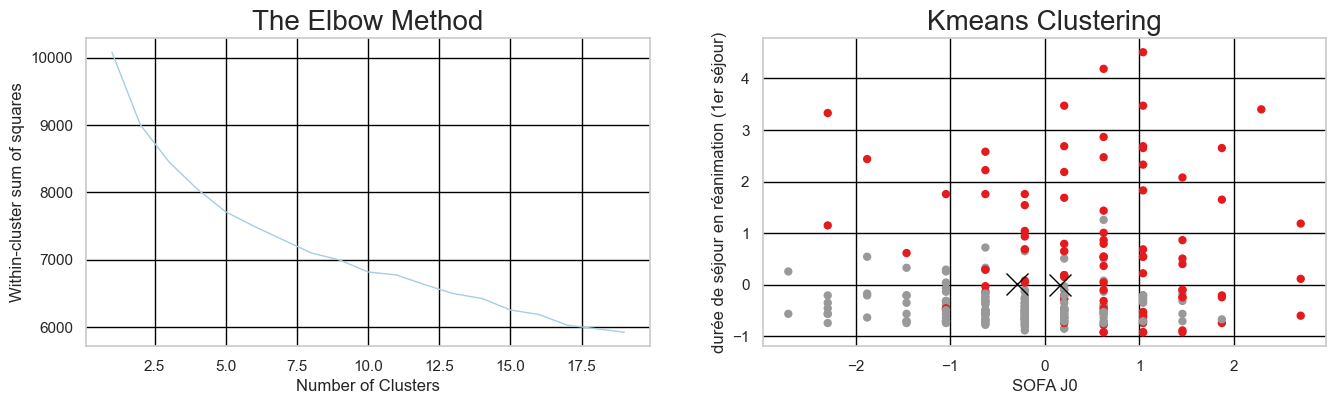

In [726]:
result = kmeans_method(df,2)

In [727]:
tmp = pd.DataFrame([result,Y.target.to_numpy()])
tmp = tmp.transpose()

In [728]:
tmp.columns = ["kmeans","target"]

In [729]:
tmp[tmp.target== 0]

kmeans  target
0         1       0
1         0       0
2         0       0
3         1       0
4         0       0
..      ...     ...
247       0       0
248       0       0
249       0       0
250       0       0
251       0       0

[188 rows x 2 columns]

## Result of kmeans

The elbow method is not very efficient to determine the number of clusters. So I used the silhoute score the more interessing and it was when k=2


A silhouette score of 0.15754628530218398 for a K-means clustering result indicates a moderate level of separation and coherence among the clusters. The silhouette score is a metric used to evaluate the quality of clustering results, ranging from -1 to 1.

A silhouette score closer to 1 suggests well-separated clusters with distinct boundaries, where the data points within each cluster are more similar to each other than to data points in other clusters. On the other hand, a score closer to -1 indicates overlapping or incorrectly assigned clusters.

A silhouette score of approximately 0.15754628530218398 suggests that there is a moderate level of separation and coherence among the clusters. It indicates that the clustering result has some degree of structure, with data points in each cluster being relatively more similar to each other than to data points in other clusters. While the clusters may not be perfectly separated, the score suggests that they still exhibit reasonable cohesion and distinctness.

In [70]:
tmp = pd.DataFrame()

In [732]:
def dbscanAlgo(u,epsilon,min_samples):

  dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
  clusters = dbscan.fit_predict(u)

  # Get cluster labels and core sample indices
  cluster_labels = dbscan.labels_
  core_samples_mask = np.zeros_like(cluster_labels, dtype=bool)
  core_samples_mask[dbscan.core_sample_indices_] = True

  # Number of clusters in labels, ignoring noise if present
  n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
  n_noise = list(cluster_labels).count(-1)

  # Print the number of clusters and noise points
  print("Estimated number of clusters:", n_clusters)
  print("Estimated number of noise points:", n_noise)

  # Plot the clustering result
  plt.scatter(u[:, 0], u[:, 1], c=cluster_labels)
  plt.xlabel('Feature 1')
  plt.ylabel('Feature 2')
  plt.title('DBSCAN Clustering Result')
  plt.show()


Estimated number of clusters: 0
Estimated number of noise points: 252


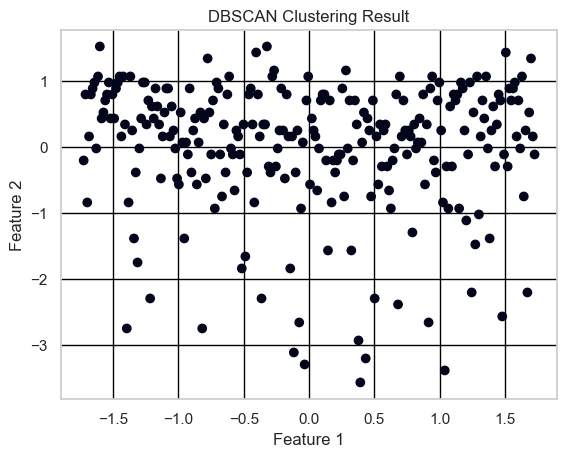

In [733]:
epsilon = 0.3
min_samples = 5
dbscanAlgo(data_scaled,epsilon=epsilon,min_samples=min_samples)

In [734]:
def kmeans_method(df,n_cluster_f):

 fig = plt.figure(figsize=(20,20))
 fig.subplots_adjust(hspace=1, wspace=1)
 length = len(X.columns)
 kmeans = KMeans(n_cluster_f, random_state = 0)
 ymeans = kmeans.fit(df)
 col = X.columns
 k=1
 for i in range(2,11):
    j = i + 1
    while j < 12:
        plt.subplot(9, 5, k)

        plt.scatter(df[col[i]], df[col[j]], c=kmeans.labels_, cmap="Set1_r", s=25)
        plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black', marker="x", s=250)
        #plt.title(col[i] + col[j], fontsize=20)
        plt.xlabel(col[i])
        plt.ylabel(col[j])
        j = j+1
        k = k + 1

 return

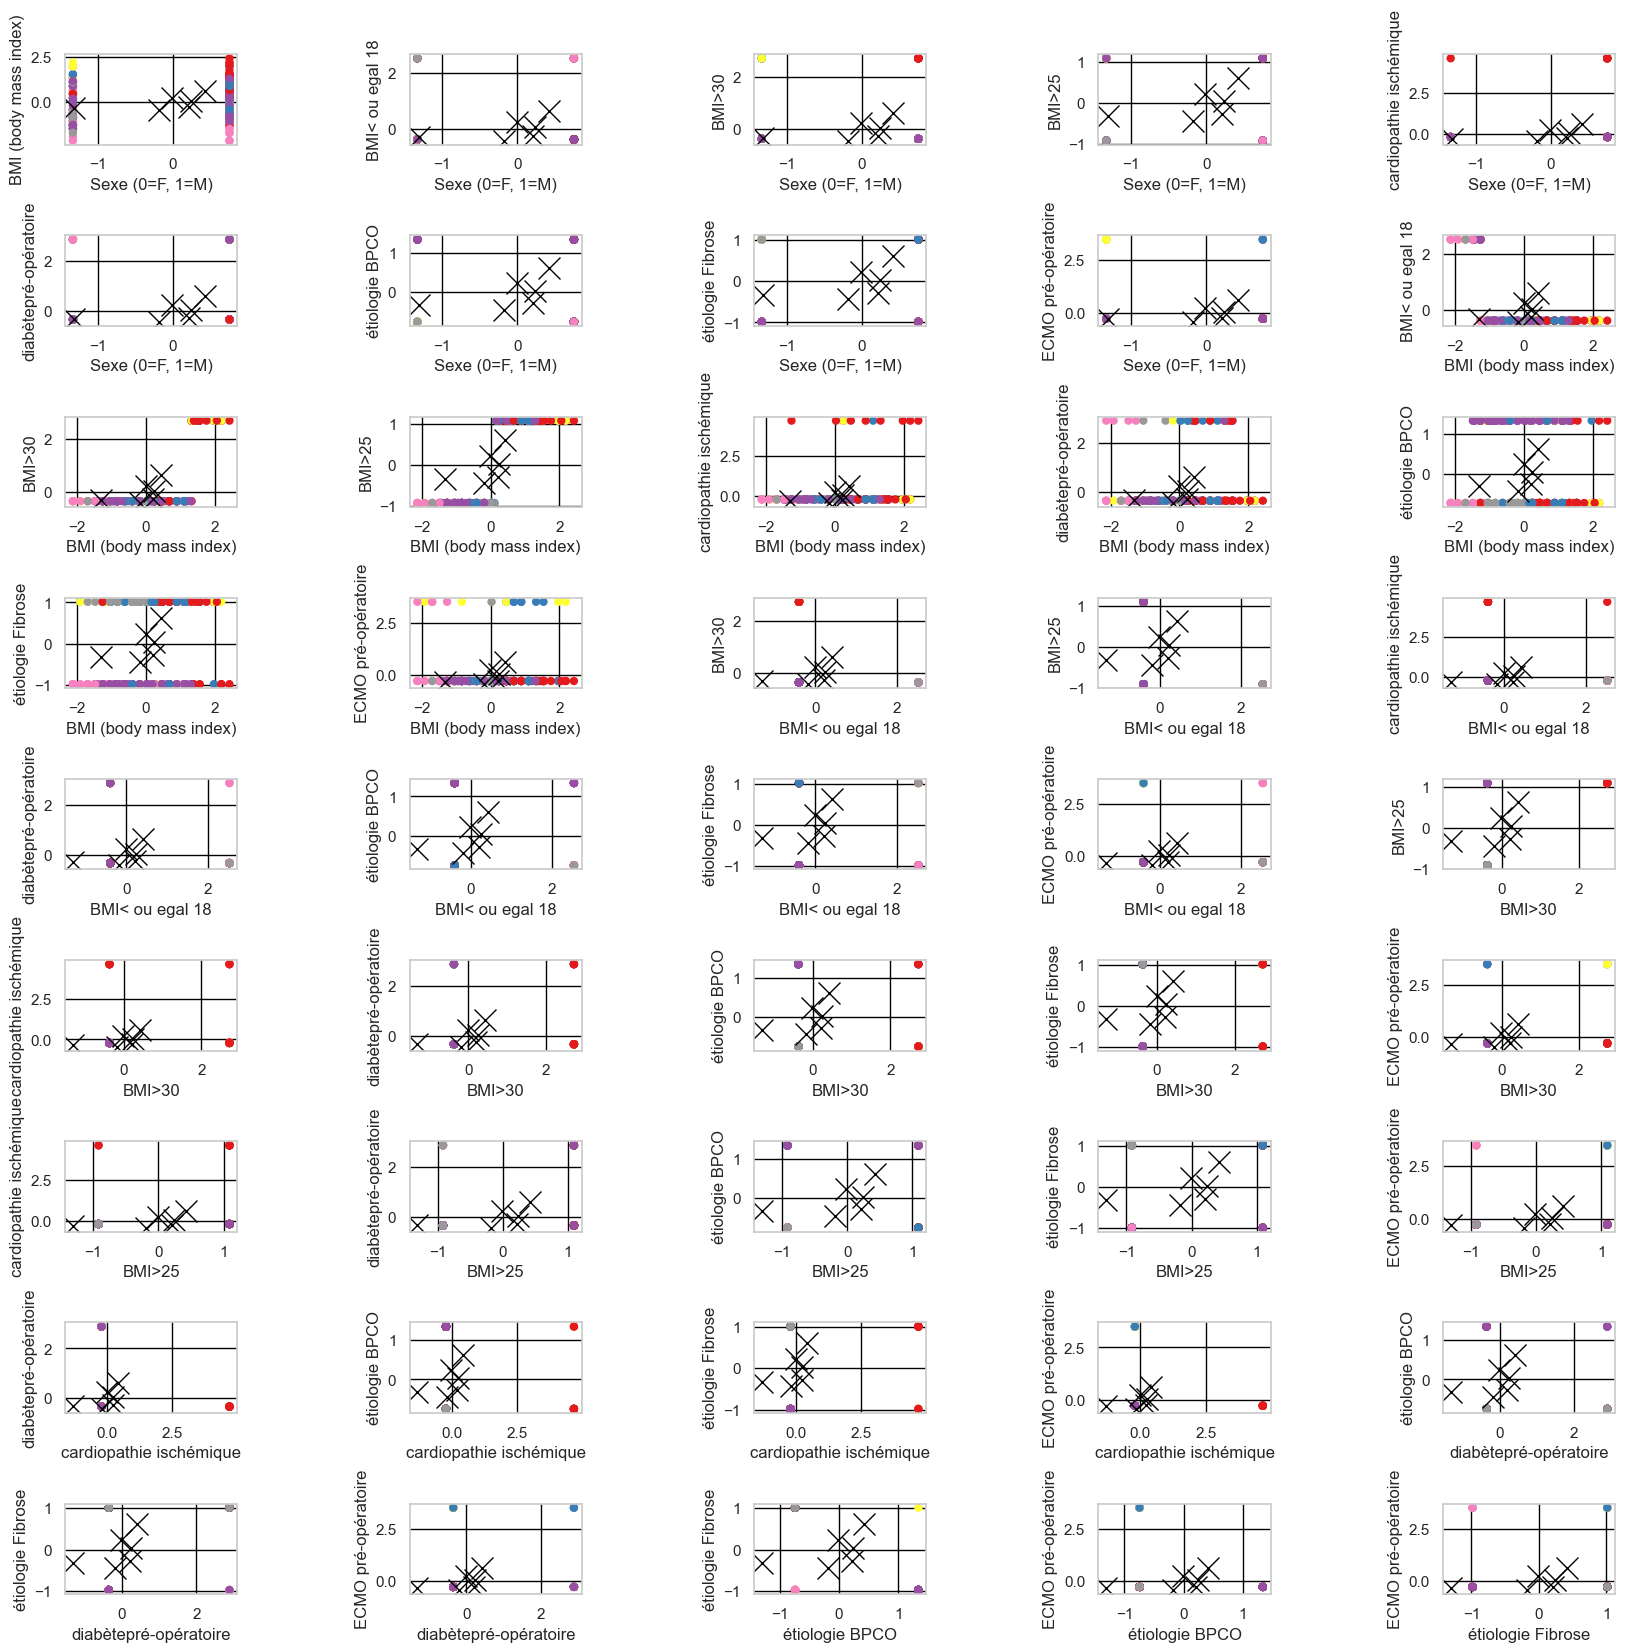

In [735]:
kmeans_method(df,6)

# Feature Engineering

To avoid outliers impacting feature scaling, Robust Data Scaling must be used. This will also help us mitigate the impact of outliers on the model overall.

In [75]:
# Defining feature and target set as X and Y respectively
X, Y = datas.drop(['mortalité dans le premier séjour réanimation','mortalité à J30','mortalité à 90j','mortalité à un an','target','Groupedage'],axis=1), datas[['mortalité dans le premier séjour réanimation','mortalité à J30','mortalité à 90j','mortalité à un an','target']]

In [87]:
scaler = RobustScaler()
x_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
x_scaled.describe()

Age  Sexe (0=F, 1=M)  BMI (body mass index)  BMI< ou egal 18  \
count  252.000000       252.000000             252.000000       252.000000   
mean    -0.229497        -0.361111              -0.019161         0.134921   
std      0.918984         0.481279               0.664532         0.342319   
min     -3.500000        -1.000000              -1.428571         0.000000   
25%     -0.583333        -1.000000              -0.571429         0.000000   
50%      0.000000         0.000000               0.000000         0.000000   
75%      0.416667         0.000000               0.428571         0.000000   
max      1.166667         0.000000               1.585714         1.000000   

           BMI>30      BMI>25  cardiopathie ischémique  diabètepré-opératoire  \
count  252.000000  252.000000               252.000000             252.000000   
mean     0.119048    0.456349                 0.043651               0.107143   
std      0.324489    0.499082                 0.204724               0.309910   
min      0.000000    0.000000                 0.000000               0.000000   
25%      0.000000    0.000000                 0.000000               0.000000   
50%      0.000000    0.000000                 0.000000               0.000000   
75%      0.000000    1.000000                 0.000000               0.000000   
max      1.000000    1.000000                 1.000000               1.000000   

       étiologie BPCO  étiologie Fibrose  ...  Autres étiologies  \
count      252.000000         252.000000  ...         252.000000   
mean         0.357143           0.492063  ...           0.156220   
std          0.480111           0.500932  ...           0.362225   
min          0.000000           0.000000  ...           0.000000   
25%          0.000000           0.000000  ...           0.000000   
50%          0.000000           0.000000  ...           0.000000   
75%          1.000000           1.000000  ...           0.000000   
max          1.000000           1.000000  ...           1.000000   

       Mismatch CMV (R-/D+)  Super Urgence  Ischémie Froide Max  \
count            252.000000     252.000000         2.520000e+02   
mean               0.215138       0.187038         5.142131e-02   
std                0.410919       0.390127         7.972010e-01   
min                0.000000       0.000000        -1.978553e+00   
25%                0.000000       0.000000        -4.824899e-01   
50%                0.000000       0.000000         2.237793e-16   
75%                0.000000       0.000000         5.175101e-01   
max                1.000000       1.000000         3.297038e+00   

       Analgésie péridurale   Transfusion per opératoire >2 CGR  \
count             252.000000                         252.000000   
mean               -0.474104                           0.230908   
std                 0.499329                           0.499000   
min                -1.000000                          -0.265414   
25%                -1.000000                          -0.265414   
50%                 0.000000                           0.000000   
75%                 0.000000                           0.734586   
max                 0.000000                           0.734586   

       Nb Jours Noradrénaline   Pneumonie (tous germes)  \
count               252.000000               252.000000   
mean                  0.489139                -0.139433   
std                   1.766076                 0.346407   
min                  -0.666667                -1.000000   
25%                  -0.333333                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.666667                 0.000000   
max                  16.000000                 0.000000   

       rejet cellulaire dans l'année   pleurésie <1an  
count                      252.000000      252.000000  
mean                         0.243155        0.153613  
std                          0.428917        0.357924  
min 

In [88]:
#Refaire le kmeans et le DBSCAN

# Dimensionality Reduction

## PCA

+-----------------------+--------------------------------+-------------+
| Number of Components: | Cumulative Explained Variance: | Eigenvalue: |
+-----------------------+--------------------------------+-------------+
|           1           |             0.769              |    58.041   |
|           2           |             0.824              |    4.173    |
|           3           |             0.864              |    2.988    |
|           4           |             0.886              |    1.687    |
|           5           |             0.905              |    1.456    |
|           6           |             0.921              |    1.157    |
|           7           |             0.931              |    0.806    |
|           8           |             0.939              |    0.603    |
|           9           |             0.947              |    0.554    |
|           10          |             0.953              |     0.46    |
|           11          |             0.958        

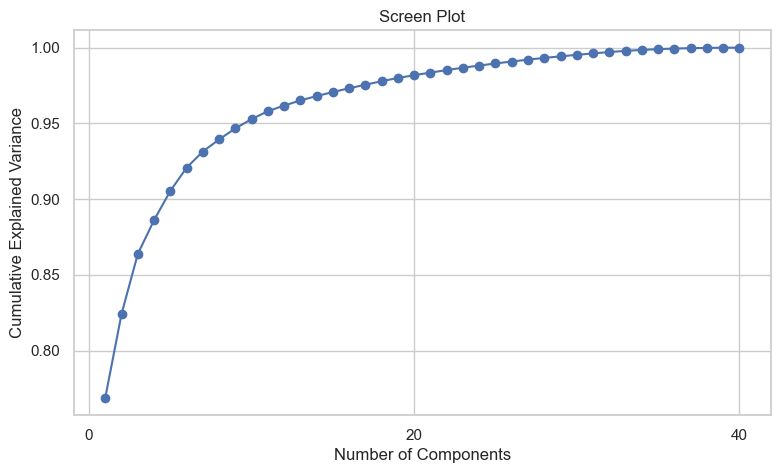

In [89]:
# Guessing less than 41 components
pca41 = PCA(n_components=40)
principalComponents = pca41.fit_transform(x_scaled)

# Creating a pretty table for results
table = [['Number of Components:','Cumulative Explained Variance:','Eigenvalue:']]
tab = PrettyTable(table[0])
for i in range(len(pca41.explained_variance_ratio_.cumsum())):
    tab.add_row([i+1,pca41.explained_variance_ratio_.cumsum()[i].round(3),
                 pca41.explained_variance_[i].round(3)])

#tab.add_rows(table[1:])
print(tab)

figure=plt.figure(figsize=(9,5))
sns.set_theme(style = "whitegrid")
plt.plot(range(1,41),pca41.explained_variance_ratio_.cumsum(),marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Screen Plot')
plt.locator_params(axis='x', nbins=4)

plt.grid(True)
plt.show()

The "elbow" on the Scree Plot appears to be around 6 or 7 principal components, indicating 6 or 7 components should be used. Kaiser's Rule instructs users to drop all components with eigenvalues under 1, indicating 6 components should be used.

Since 6 components explains > 93% of variance and choosing 6 or 7 components seemed abritrary, I decided to move forward with 6 components for the extra explained variance in this PCA.

In [90]:
# Train Test split of 70:30
x_train, x_test, y_train, y_test = train_test_split(x_scaled,Y,
                                test_size = 0.3, random_state = 7)

In [91]:
pca6 = PCA(n_components=6)
pca_columns = ['PCA_1','PCA_2','PCA_3','PCA_4','PCA_5','PCA_6']

# Transforming both x_train and x_test into PCA versions.
x_train_pca = pd.DataFrame(pca6.fit_transform(x_train), columns = pca_columns)
x_test_pca = pd.DataFrame(pca6.transform(x_test), columns = pca_columns)

In [92]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [93]:
x_scaled.shape

(252, 40)

# Train Test split

In [132]:
tmp = x_scaled.to_numpy()
#x_scaled.to_numpy()

# Taelcore

In [133]:
# scaled_data_train = scaled_data_train.to_numpy()
#tmp_x =x_train.to_numpy()
#tmp_y = y_train['target']
dataset=[(x,y) for x,y in zip(x_train.to_numpy(),y_train['target'])]
data_set=[(x,y) for x,y in zip(x_test.to_numpy(),y_test['target'])]

train_loader=DataLoader(dataset, batch_size=4, shuffle=True)
test_loader=DataLoader(data_set,batch_size=1,shuffle=True)

In [134]:
class model(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(40, 6)

        )
        self.decoder = nn.Sequential(
            nn.Linear(6, 40)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = model().to(device)
model=model.double()
learning_rate = 0.001

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate
)
mse=nn.MSELoss()

# Trainning

In [135]:
persistence = VietorisRipsPersistence(metric = 'euclidean',homology_dimensions=[0,1,2],n_jobs=-1,collapse_edges=True)

In [136]:
from gtda.diagrams import PersistenceEntropy
PE = PersistenceEntropy()

In [137]:
x_train.shape

(176, 40)

In [138]:
from gtda.diagrams import Amplitude
import sklearn

losses=[]

num_epochs=150

batch_size = len(train_loader)

for epoch in range(num_epochs):

    X=[]
    Y=[]

    total_loss = 0

    for data in train_loader:

        x,y=data

        output = model(x)
        e=model.encoder(x).detach().numpy()

        X.append(e)
        Y.append(y.numpy())


        dy=persistence.fit_transform(output.detach().numpy()[None,:,:])
        dz=persistence.fit_transform(e[None,:,:])
        dx=persistence.fit_transform(x[None,:,:])

        a1=Amplitude(metric='bottleneck').fit_transform(dx)
        a2=Amplitude(metric='wasserstein').fit_transform(dx)
        a3=Amplitude(metric='landscape').fit_transform(dx)
        a4=Amplitude(metric='betti').fit_transform(dx)
        a5=Amplitude(metric='persistence_image').fit_transform(dx)

        a=a1+a2+a3+a4+a5

        b1=Amplitude(metric='bottleneck').fit_transform(dz)
        b2=Amplitude(metric='wasserstein').fit_transform(dz)
        b3=Amplitude(metric='landscape').fit_transform(dz)
        b4=Amplitude(metric='betti').fit_transform(dz)
        b5=Amplitude(metric='persistence_image').fit_transform(dz)

        b=b1+b2+b3+b4+b5

        c1=Amplitude(metric='bottleneck').fit_transform(dy)
        c2=Amplitude(metric='wasserstein').fit_transform(dy)
        c3=Amplitude(metric='landscape').fit_transform(dy)
        c4=Amplitude(metric='betti').fit_transform(dy)
        c5=Amplitude(metric='persistence_image').fit_transform(dy)

        c=c1+c2+c3+c4+c5


        l1=(np.linalg.norm(a-b)**2)/2

        l2=(np.linalg.norm(b-c)**2)/2

        l=l1+l2


        loss = mse(output, x)+(1e-5)*l

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.data
    total_loss = total_loss / batch_size
    losses.append(total_loss)

    Y=np.asarray(Y).reshape(1,-1)
    X=np.asarray(X).reshape(176,6)


    print("epoch : {}/{},  loss = {:.4f}".format(epoch + 1, num_epochs, total_loss))




epoch : 1/150,  loss = 2.4607
epoch : 2/150,  loss = 2.3421
epoch : 3/150,  loss = 2.2389
epoch : 4/150,  loss = 2.1547
epoch : 5/150,  loss = 2.0369
epoch : 6/150,  loss = 1.9238
epoch : 7/150,  loss = 1.7977
epoch : 8/150,  loss = 1.6680
epoch : 9/150,  loss = 1.5204
epoch : 10/150,  loss = 1.3843
epoch : 11/150,  loss = 1.2376
epoch : 12/150,  loss = 1.1522
epoch : 13/150,  loss = 1.0053
epoch : 14/150,  loss = 0.9054
epoch : 15/150,  loss = 0.8174
epoch : 16/150,  loss = 0.7406
epoch : 17/150,  loss = 0.6765
epoch : 18/150,  loss = 0.6225
epoch : 19/150,  loss = 0.5712
epoch : 20/150,  loss = 0.5295
epoch : 21/150,  loss = 0.4927
epoch : 22/150,  loss = 0.4624
epoch : 23/150,  loss = 0.4355
epoch : 24/150,  loss = 0.4113
epoch : 25/150,  loss = 0.3904
epoch : 26/150,  loss = 0.3732
epoch : 27/150,  loss = 0.3569
epoch : 28/150,  loss = 0.3444
epoch : 29/150,  loss = 0.3322
epoch : 30/150,  loss = 0.3226
epoch : 31/150,  loss = 0.3130
epoch : 32/150,  loss = 0.3051
epoch : 33/150,  

# Visualization of loss function

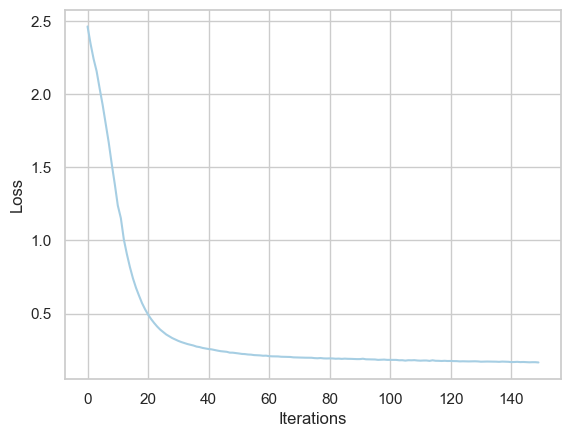

In [139]:
plt.plot(losses[:])
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

# Test

In [140]:
x_test.shape

(76, 40)

In [141]:
test_loss = 0
s=0
with torch.no_grad():
    X=[]
    Y=[]

    for data in test_loader:
        x,y=data

        output = model(x)


        e=model.encoder(x).detach().numpy()

        X.append(e)

        Y.append(y.numpy())

        dy=persistence.fit_transform(output.detach().numpy()[None,:,:])
        dz=persistence.fit_transform(e[None,:,:])
        dx=persistence.fit_transform(x[None,:,:])

        a1=Amplitude(metric='bottleneck').fit_transform(dx)
        a2=Amplitude(metric='wasserstein').fit_transform(dx)
        a3=Amplitude(metric='landscape').fit_transform(dx)
        a4=Amplitude(metric='betti').fit_transform(dx)
        a5=Amplitude(metric='persistence_image').fit_transform(dx)

        a=a1+a2+a3+a4+a5

        b1=Amplitude(metric='bottleneck').fit_transform(dz)
        b2=Amplitude(metric='wasserstein').fit_transform(dz)
        b3=Amplitude(metric='landscape').fit_transform(dz)
        b4=Amplitude(metric='betti').fit_transform(dz)
        b5=Amplitude(metric='persistence_image').fit_transform(dz)

        b=b1+b2+b3+b4+b5

        c1=Amplitude(metric='bottleneck').fit_transform(dy)
        c2=Amplitude(metric='wasserstein').fit_transform(dy)
        c3=Amplitude(metric='landscape').fit_transform(dy)
        c4=Amplitude(metric='betti').fit_transform(dy)
        c5=Amplitude(metric='persistence_image').fit_transform(dy)

        c=c1+c2+c3+c4+c5

        l1=(np.linalg.norm(a-b)**2)/2

        l2=(np.linalg.norm(b-c)**2)/2

        l=l1+l2


        loss = mse(output, x)+(1e-3)*l
        test_loss += loss.item()

    test_loss /= len(test_loader)
    print('====> Test set loss: {:.4f}'.format(test_loss))

    #Y=np.asarray(Y).reshape(1,-1)
    #print(np.asarray(X).shape)
    #X=np.asarray(X).reshape(76,6)

    #fig = plt.figure(figsize=(8,8))
    #ax = plt.axes()
    #ax.scatter(X[:,0], X[:,1],c=Y,s=50)
    #ax.set_title('test')

====> Test set loss: 0.1982


# Visualisationofthe latent space

In [142]:
data = df_imputed.copy()
datas = df_imputed.copy()

In [143]:
type(x_train)

pandas.core.frame.DataFrame

In [144]:
Y = datas[['mortalité à J30','mortalité à 90j','mortalité à un an','target']]
X = x_scaled.to_numpy()


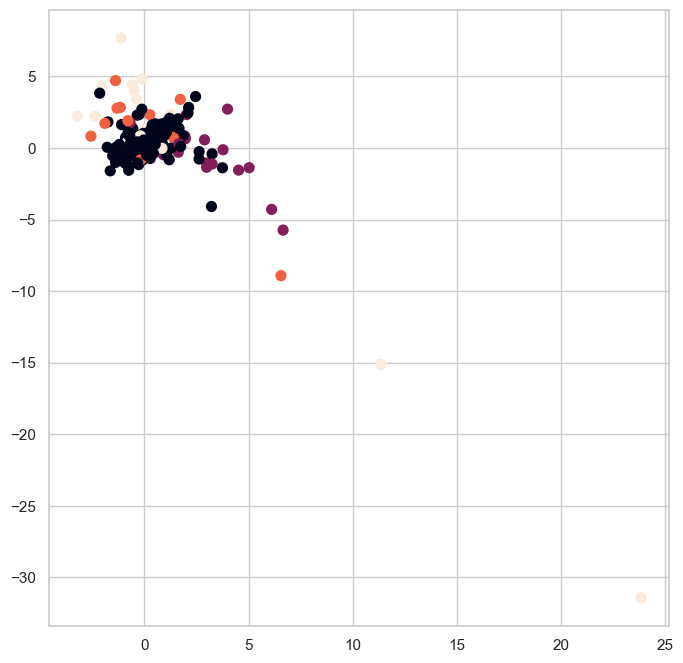

In [145]:
m=model.encoder(torch.from_numpy(X))
fig = plt.figure(figsize=(8,8))
ax = plt.axes()
ax.scatter(m[:,0].detach().numpy(), m[:,1].detach().numpy(),c=Y["target"].to_numpy(),s=50)

In [146]:
m=m.detach().numpy()
A=matrice_distance(m)
B=d=matrice_distance(X)

In [147]:
sigma=[0.01,0.1,1]

f=[estimateur(X,B,sigma) for sigma in sigma]

g=[estimateur(m,A,sigma) for sigma in sigma]

In [148]:
kl=[]
for i in range(3):
    kl.append(KL(f[i],g[i]))

In [149]:
RMSE=[]

MSE = np.square(np.subtract(B,A)).mean()

RMSE.append(math.sqrt(MSE))

In [150]:
Trust=[]

Trust.append(sklearn.manifold.trustworthiness(B,A))

In [151]:
mse=[]
mse.append(mean_squared_error(X,model(torch.from_numpy(X)).detach().numpy()))

In [152]:
Tab=pd.DataFrame([kl])
Tab.columns=['KL_0.01','KL_0.1','KL_1']
Tab['RMSE']=RMSE
Tab['Trust']=Trust
Tab['MSE']=mse
Tab

KL_0.01    KL_0.1     KL_1      RMSE     Trust       MSE
0 -48.367268 -5.378466 -0.54365  0.008473  0.953815  0.172265

# Analysis
## Analysis techniques
### Using PCA

In [94]:
classifiers = [LogisticRegression,KNeighborsClassifier,SVC,
               MLPClassifier,GaussianNB,DecisionTreeClassifier,
              RandomForestClassifier]

__________________________________________________
--------------------------------------------------
Results for: LogisticRegression
              precision    recall  f1-score   support

           0       0.83      0.98      0.90       132
           1       1.00      0.69      0.81        16
           2       0.50      0.15      0.24        13
           3       1.00      0.27      0.42        15

    accuracy                           0.84       176
   macro avg       0.83      0.52      0.59       176
weighted avg       0.83      0.84      0.80       176

Training Accuracy: 0.8352
Training Recall: 0.6875


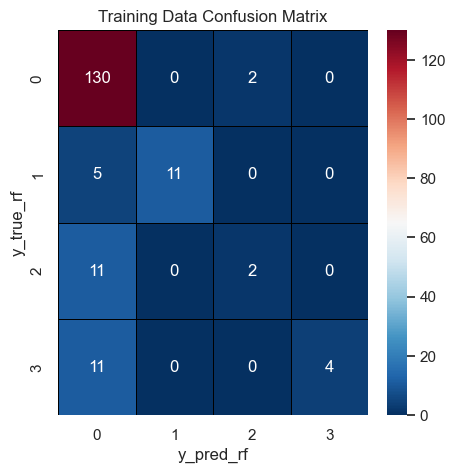

__________________________________________________
--------------------------------------------------
Results for: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.83      0.98      0.90       132
           1       0.71      0.62      0.67        16
           2       1.00      0.15      0.27        13
           3       0.67      0.13      0.22        15

    accuracy                           0.82       176
   macro avg       0.80      0.47      0.51       176
weighted avg       0.82      0.82      0.77       176

Training Accuracy: 0.8182
Training Recall: 0.625


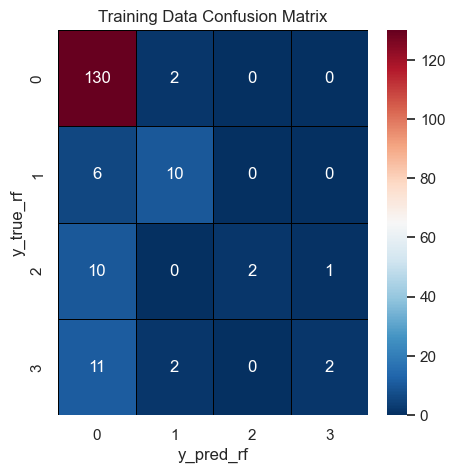

__________________________________________________
--------------------------------------------------
Results for: SVC
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       132
           1       1.00      0.50      0.67        16
           2       1.00      0.08      0.14        13
           3       1.00      0.20      0.33        15

    accuracy                           0.82       176
   macro avg       0.95      0.44      0.51       176
weighted avg       0.85      0.82      0.77       176

Training Accuracy: 0.8182
Training Recall: 0.5


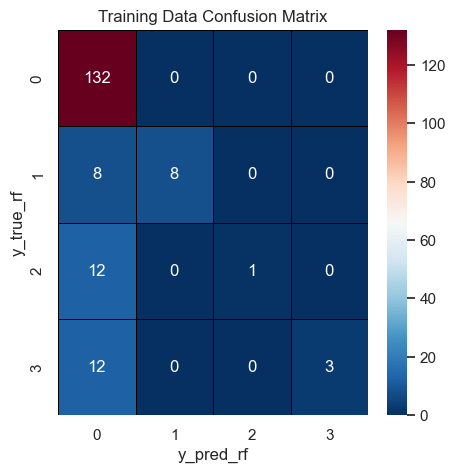

__________________________________________________
--------------------------------------------------
Results for: MLPClassifier
              precision    recall  f1-score   support

           0       0.86      0.98      0.92       132
           1       0.86      0.75      0.80        16
           2       1.00      0.38      0.56        13
           3       1.00      0.40      0.57        15

    accuracy                           0.87       176
   macro avg       0.93      0.63      0.71       176
weighted avg       0.88      0.87      0.85       176

Training Accuracy: 0.8693
Training Recall: 0.75


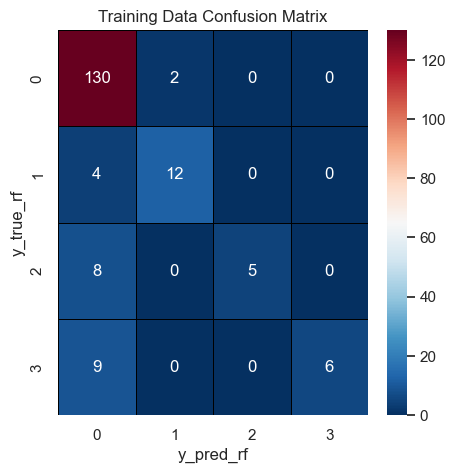

__________________________________________________
--------------------------------------------------
Results for: GaussianNB
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       132
           1       0.90      0.56      0.69        16
           2       0.29      0.15      0.20        13
           3       0.55      0.40      0.46        15

    accuracy                           0.80       176
   macro avg       0.64      0.51      0.56       176
weighted avg       0.78      0.80      0.78       176

Training Accuracy: 0.8011
Training Recall: 0.5625


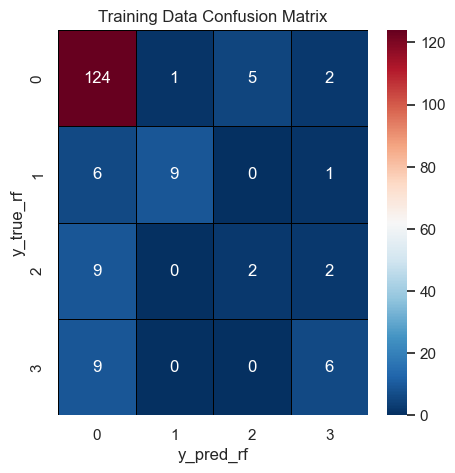

__________________________________________________
--------------------------------------------------
Results for: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       132
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00        15

    accuracy                           1.00       176
   macro avg       1.00      1.00      1.00       176
weighted avg       1.00      1.00      1.00       176

Training Accuracy: 1.0
Training Recall: 1.0


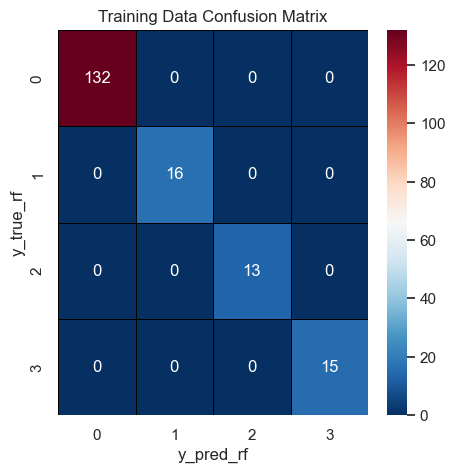

__________________________________________________
--------------------------------------------------
Results for: RandomForestClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       132
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00        15

    accuracy                           1.00       176
   macro avg       1.00      1.00      1.00       176
weighted avg       1.00      1.00      1.00       176

Training Accuracy: 1.0
Training Recall: 1.0


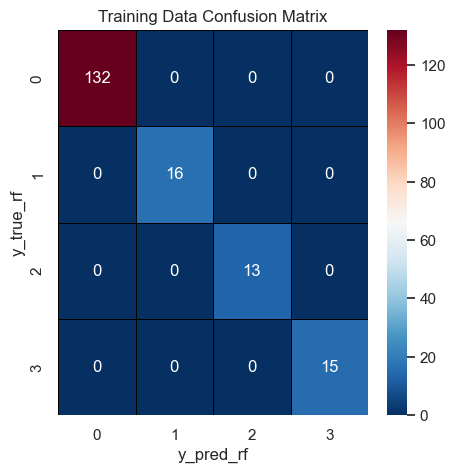

LogisticRegression  KNeighborsClassifier     SVC  MLPClassifier  \
0              0.8352                0.8182  0.8182         0.8693   

   GaussianNB  DecisionTreeClassifier  RandomForestClassifier  
0      0.8011                     1.0                     1.0

In [95]:
showResult(classifiers,x_train_pca,y_train["target"])

__________________________________________________
--------------------------------------------------
Results for LogisticRegression:
              precision    recall  f1-score   support

           0       0.80      0.93      0.86        56
           1       0.80      0.67      0.73         6
           2       0.00      0.00      0.00         5
           3       0.33      0.11      0.17         9

    accuracy                           0.75        76
   macro avg       0.48      0.43      0.44        76
weighted avg       0.69      0.75      0.71        76

Test Accuracy: 75.0%


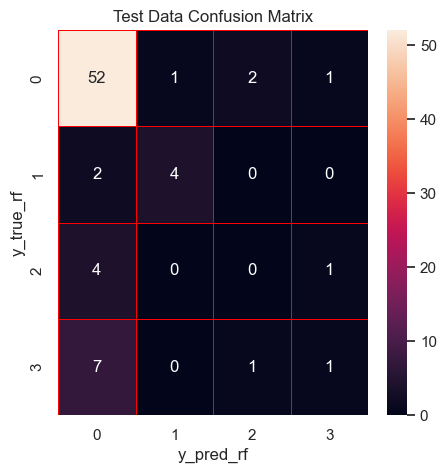

__________________________________________________
--------------------------------------------------
Results for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.77      0.98      0.87        56
           1       0.67      0.33      0.44         6
           2       0.00      0.00      0.00         5
           3       1.00      0.22      0.36         9

    accuracy                           0.78        76
   macro avg       0.61      0.38      0.42        76
weighted avg       0.74      0.78      0.72        76

Test Accuracy: 77.63%


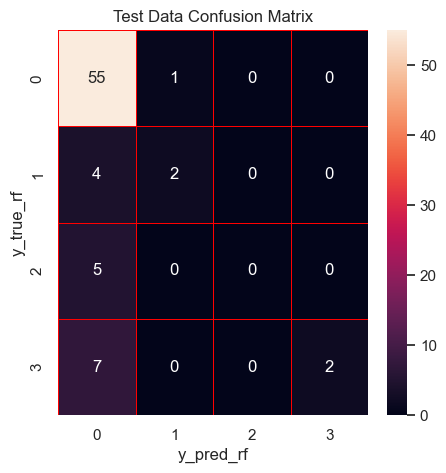

__________________________________________________
--------------------------------------------------
Results for SVC:
              precision    recall  f1-score   support

           0       0.74      0.98      0.85        56
           1       0.50      0.17      0.25         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.74        76
   macro avg       0.31      0.29      0.27        76
weighted avg       0.59      0.74      0.64        76

Test Accuracy: 73.68%


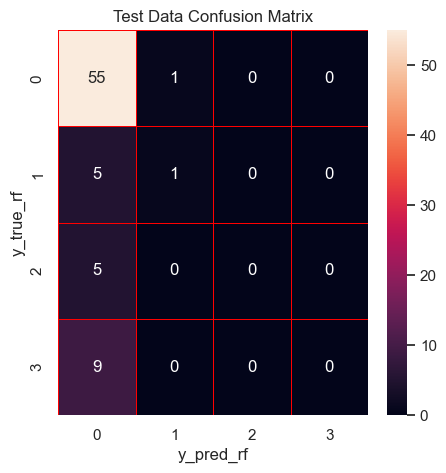

__________________________________________________
--------------------------------------------------
Results for MLPClassifier:
              precision    recall  f1-score   support

           0       0.81      0.91      0.86        56
           1       0.50      0.83      0.62         6
           2       0.00      0.00      0.00         5
           3       1.00      0.11      0.20         9

    accuracy                           0.75        76
   macro avg       0.58      0.46      0.42        76
weighted avg       0.75      0.75      0.70        76

Test Accuracy: 75.0%


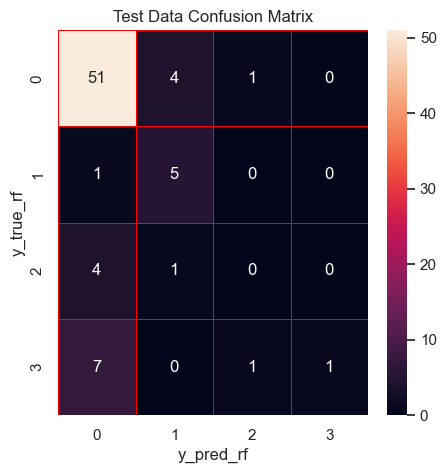

__________________________________________________
--------------------------------------------------
Results for GaussianNB:
              precision    recall  f1-score   support

           0       0.81      0.91      0.86        56
           1       0.67      0.33      0.44         6
           2       0.40      0.40      0.40         5
           3       0.80      0.44      0.57         9

    accuracy                           0.78        76
   macro avg       0.67      0.52      0.57        76
weighted avg       0.77      0.78      0.76        76

Test Accuracy: 77.63%


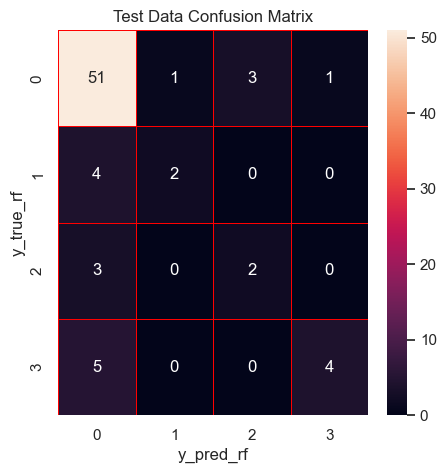

__________________________________________________
--------------------------------------------------
Results for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.80      0.66      0.73        56
           1       0.44      0.67      0.53         6
           2       0.20      0.40      0.27         5
           3       0.18      0.22      0.20         9

    accuracy                           0.59        76
   macro avg       0.41      0.49      0.43        76
weighted avg       0.66      0.59      0.62        76

Test Accuracy: 59.21%


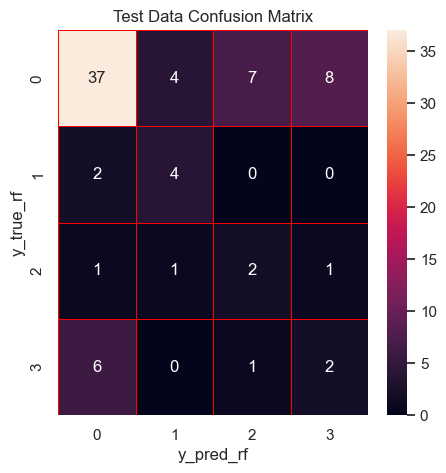

__________________________________________________
--------------------------------------------------
Results for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.78      0.95      0.85        56
           1       0.57      0.67      0.62         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.75        76
   macro avg       0.34      0.40      0.37        76
weighted avg       0.62      0.75      0.68        76

Test Accuracy: 75.0%


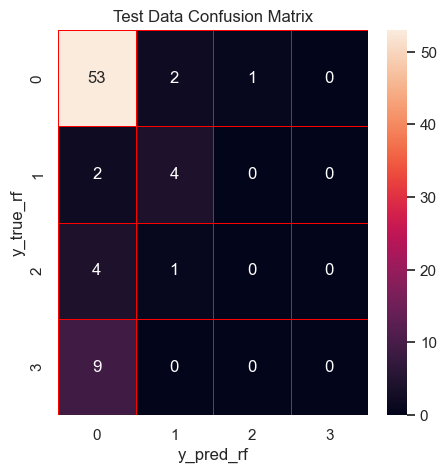

LogisticRegression  KNeighborsClassifier     SVC  MLPClassifier  \
0                0.75                0.7763  0.7368           0.75   

   GaussianNB  DecisionTreeClassifier  RandomForestClassifier  
0      0.7763                  0.5921                    0.75

In [96]:
showResult(classifiers,x_train_pca,y_train["target"],test=[x_test_pca,y_test["target"]])

### Using topological autoencoder


In [279]:
# Train Test split of 70:30
x_train_tael, x_test_tael, y_train_tael, y_test_tael = train_test_split(m,Y,
                                test_size = 0.3, random_state = 7)

__________________________________________________
--------------------------------------------------
Results for: LogisticRegression
              precision    recall  f1-score   support

           0       0.83      0.98      0.90       132
           1       0.92      0.69      0.79        16
           2       0.40      0.15      0.22        13
           3       1.00      0.20      0.33        15

    accuracy                           0.82       176
   macro avg       0.79      0.50      0.56       176
weighted avg       0.82      0.82      0.79       176

Training Accuracy: 0.8239
Training Recall: 0.6875


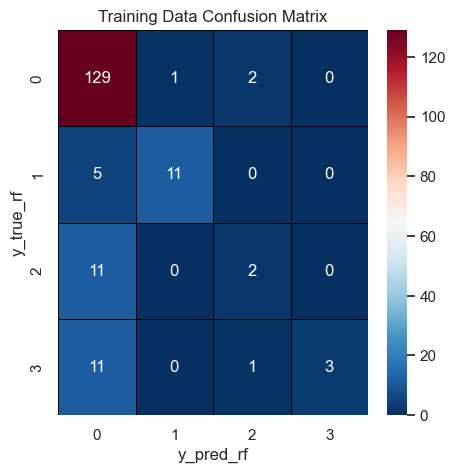

__________________________________________________
--------------------------------------------------
Results for: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.82      0.98      0.90       132
           1       0.75      0.56      0.64        16
           2       1.00      0.15      0.27        13
           3       0.75      0.20      0.32        15

    accuracy                           0.82       176
   macro avg       0.83      0.48      0.53       176
weighted avg       0.82      0.82      0.78       176

Training Accuracy: 0.8182
Training Recall: 0.5625


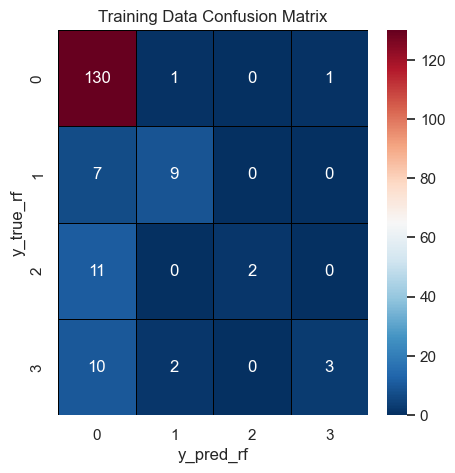

__________________________________________________
--------------------------------------------------
Results for: SVC
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       132
           1       1.00      0.50      0.67        16
           2       1.00      0.08      0.14        13
           3       1.00      0.20      0.33        15

    accuracy                           0.82       176
   macro avg       0.95      0.44      0.51       176
weighted avg       0.85      0.82      0.77       176

Training Accuracy: 0.8182
Training Recall: 0.5


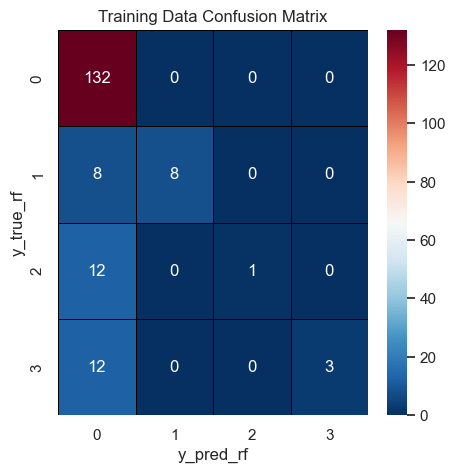

__________________________________________________
--------------------------------------------------
Results for: MLPClassifier
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       132
           1       1.00      0.75      0.86        16
           2       1.00      0.31      0.47        13
           3       1.00      0.40      0.57        15

    accuracy                           0.88       176
   macro avg       0.96      0.61      0.71       176
weighted avg       0.89      0.88      0.85       176

Training Accuracy: 0.875
Training Recall: 0.75


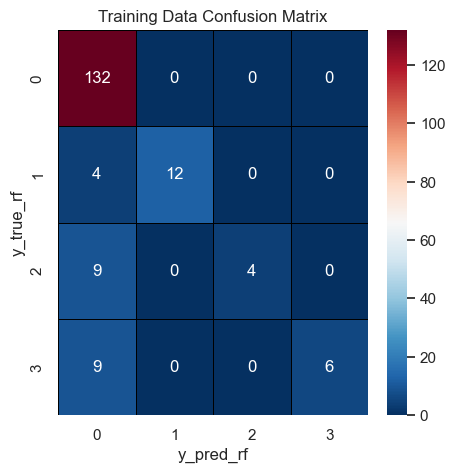

__________________________________________________
--------------------------------------------------
Results for: GaussianNB
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       132
           1       0.67      0.38      0.48        16
           2       0.22      0.15      0.18        13
           3       0.50      0.20      0.29        15

    accuracy                           0.77       176
   macro avg       0.55      0.42      0.46       176
weighted avg       0.74      0.77      0.74       176

Training Accuracy: 0.7727
Training Recall: 0.375


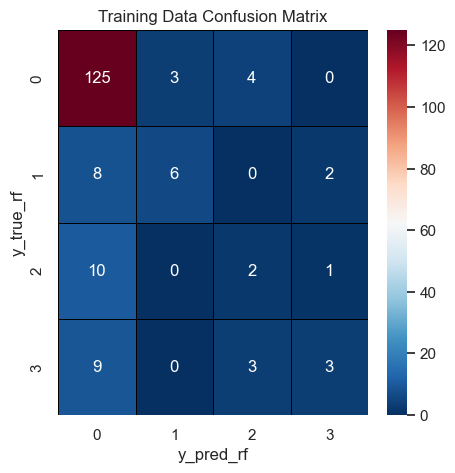

__________________________________________________
--------------------------------------------------
Results for: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       132
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00        15

    accuracy                           1.00       176
   macro avg       1.00      1.00      1.00       176
weighted avg       1.00      1.00      1.00       176

Training Accuracy: 1.0
Training Recall: 1.0


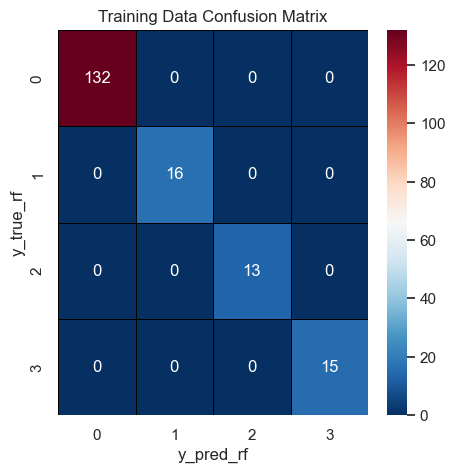

__________________________________________________
--------------------------------------------------
Results for: RandomForestClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       132
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00        15

    accuracy                           1.00       176
   macro avg       1.00      1.00      1.00       176
weighted avg       1.00      1.00      1.00       176

Training Accuracy: 1.0
Training Recall: 1.0


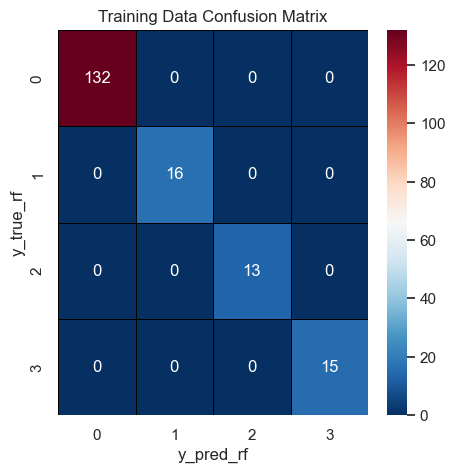

LogisticRegression  KNeighborsClassifier     SVC  MLPClassifier  \
0              0.8239                0.8182  0.8182          0.875   

   GaussianNB  DecisionTreeClassifier  RandomForestClassifier  
0      0.7727                     1.0                     1.0

In [280]:
showResult(classifiers,x_train_tael,y_train_tael["target"])

__________________________________________________
--------------------------------------------------
Results for LogisticRegression:
              precision    recall  f1-score   support

           0       0.79      0.96      0.87        56
           1       1.00      0.50      0.67         6
           2       0.00      0.00      0.00         5
           3       0.33      0.11      0.17         9

    accuracy                           0.76        76
   macro avg       0.53      0.39      0.43        76
weighted avg       0.70      0.76      0.71        76

Test Accuracy: 76.32%


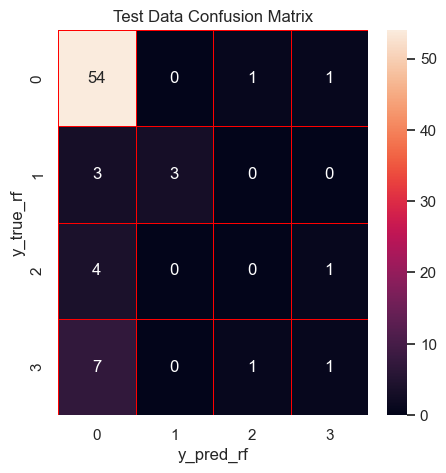

__________________________________________________
--------------------------------------------------
Results for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.79      0.98      0.87        56
           1       0.67      0.33      0.44         6
           2       0.00      0.00      0.00         5
           3       1.00      0.33      0.50         9

    accuracy                           0.79        76
   macro avg       0.61      0.41      0.45        76
weighted avg       0.75      0.79      0.74        76

Test Accuracy: 78.95%


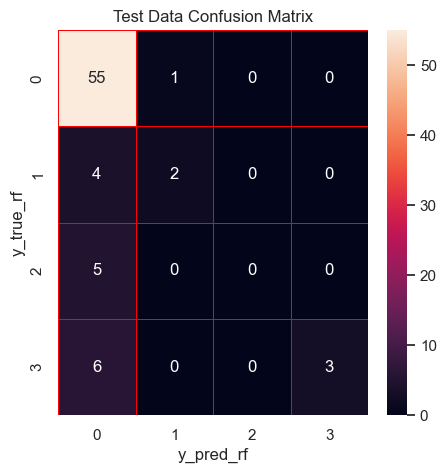

__________________________________________________
--------------------------------------------------
Results for SVC:
              precision    recall  f1-score   support

           0       0.74      0.96      0.84        56
           1       0.33      0.17      0.22         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.72        76
   macro avg       0.27      0.28      0.26        76
weighted avg       0.57      0.72      0.63        76

Test Accuracy: 72.37%


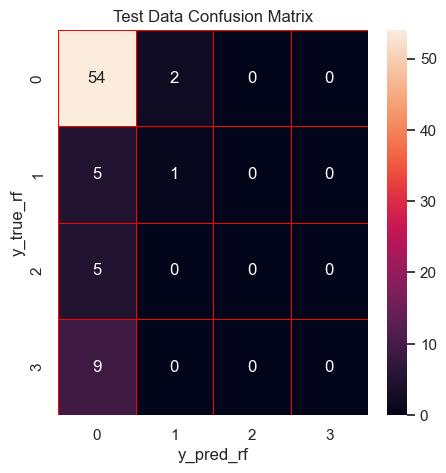

__________________________________________________
--------------------------------------------------
Results for MLPClassifier:
              precision    recall  f1-score   support

           0       0.79      0.98      0.87        56
           1       1.00      0.33      0.50         6
           2       0.00      0.00      0.00         5
           3       0.50      0.11      0.18         9

    accuracy                           0.76        76
   macro avg       0.57      0.36      0.39        76
weighted avg       0.72      0.76      0.70        76

Test Accuracy: 76.32%


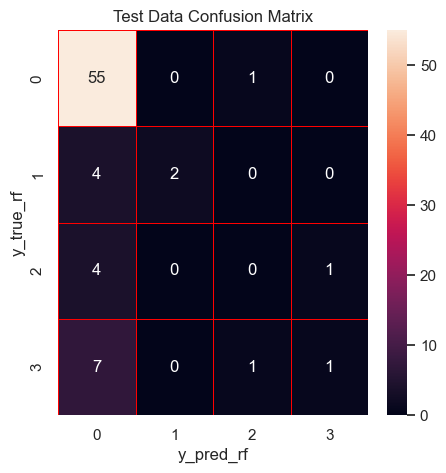

__________________________________________________
--------------------------------------------------
Results for GaussianNB:
              precision    recall  f1-score   support

           0       0.80      0.95      0.87        56
           1       0.25      0.17      0.20         6
           2       0.20      0.20      0.20         5
           3       0.00      0.00      0.00         9

    accuracy                           0.72        76
   macro avg       0.31      0.33      0.32        76
weighted avg       0.62      0.72      0.67        76

Test Accuracy: 72.37%


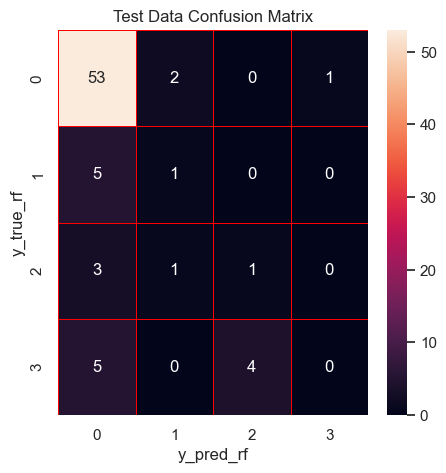

__________________________________________________
--------------------------------------------------
Results for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.76      0.84      0.80        56
           1       0.29      0.33      0.31         6
           2       0.40      0.40      0.40         5
           3       0.00      0.00      0.00         9

    accuracy                           0.67        76
   macro avg       0.36      0.39      0.38        76
weighted avg       0.61      0.67      0.64        76

Test Accuracy: 67.11%


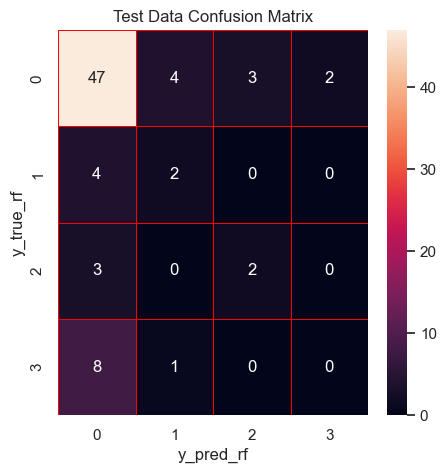

__________________________________________________
--------------------------------------------------
Results for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        56
           1       0.50      0.33      0.40         6
           2       0.00      0.00      0.00         5
           3       0.67      0.22      0.33         9

    accuracy                           0.74        76
   macro avg       0.49      0.37      0.39        76
weighted avg       0.69      0.74      0.69        76

Test Accuracy: 73.68%


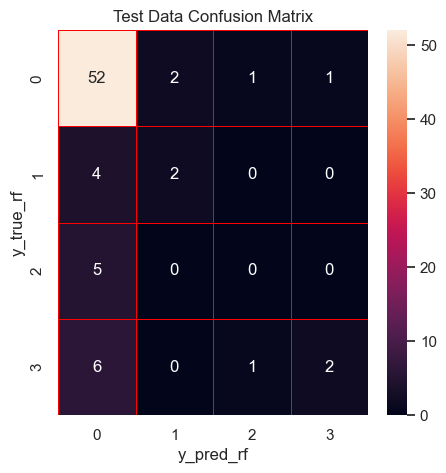

LogisticRegression  KNeighborsClassifier     SVC  MLPClassifier  \
0              0.7632                0.7895  0.7237         0.7632   

   GaussianNB  DecisionTreeClassifier  RandomForestClassifier  
0      0.7237                  0.6711                  0.7368

In [282]:
showResult(classifiers,x_train_tael,y_train_tael["target"],test=[x_test_tael,y_test_tael["target"]])

# Triaged prediction model

# TDA

In [785]:
# Defining feature and target set as X and Y respectively
X, Y = datas.drop(['mortalité dans le premier séjour réanimation','mortalité à J30','mortalité à 90j','mortalité à un an','target','Groupedage'],axis=1), datas[['mortalité dans le premier séjour réanimation','mortalité à J30','mortalité à 90j','mortalité à un an','target']]
target = Y.target

 ## Topological Features of Taelcore

### Persistence homology

### Extract features

In [ ]:
showResult(classifiers,x_train_pca,y_train["target"],test=[x_test_pca,y_test["target"]])
showResult(classifiers,x_train_tael,y_train_tael,test=[x_test_tael,y_test_tael])

# Using TDA on PCA data set 

In [956]:
topologicalFeaturesComplete(x_train_pca,y_train["target"])

LogisticRegression  KNeighborsClassifier     SVC  \
bottleneck                     0.7614                0.7614  0.7727   
wasserstein                    0.7614                0.7727  0.7727   
landscape                      0.7557                0.7614  0.7727   
persistence_image              0.7500                0.7500  0.7500   
entropy                        0.7500                0.7670  0.7500   

                   MLPClassifier  GaussianNB  DecisionTreeClassifier  \
bottleneck                0.7614      0.7500                   1.000   
wasserstein               0.7614      0.7443                   1.000   
landscape                 0.7614      0.7557                   0.983   
persistence_image         0.7500      0.7500                   0.750   
entropy                   0.7500      0.7443                   1.000   

                   RandomForestClassifier  
bottleneck                         0.9943  
wasserstein                        1.0000  
landscape                          0.9773  
persistence_image                  0.7500  
entropy                            1.0000

In [955]:
topologicalFeaturesComplete(x_train_pca,y_train["target"],test=[x_test_pca,y_test["target"]])

LogisticRegression  KNeighborsClassifier     SVC  \
bottleneck                     0.7105                0.7368  0.7368   
wasserstein                    0.7105                0.6974  0.7368   
landscape                      0.7105                0.7105  0.7368   
persistence_image              0.7368                0.7368  0.7368   
entropy                        0.7368                0.7237  0.7368   

                   MLPClassifier  GaussianNB  DecisionTreeClassifier  \
bottleneck                0.7105      0.7105                  0.5526   
wasserstein               0.7237      0.7105                  0.6579   
landscape                 0.7105      0.7105                  0.6316   
persistence_image         0.7368      0.7368                  0.7368   
entropy                   0.7368      0.7368                  0.6316   

                   RandomForestClassifier  
bottleneck                         0.5526  
wasserstein                        0.6579  
landscape                          0.6316  
persistence_image                  0.7368  
entropy                            0.6316

# Using TDA on TAELCORE data set 

__________________________________________________
--------------------------------------------------
Results for LogisticRegression:
              precision    recall  f1-score   support

           0       0.79      0.96      0.87        56
           1       1.00      0.50      0.67         6
           2       0.00      0.00      0.00         5
           3       0.33      0.11      0.17         9

    accuracy                           0.76        76
   macro avg       0.53      0.39      0.43        76
weighted avg       0.70      0.76      0.71        76

Test Accuracy: 76.32%


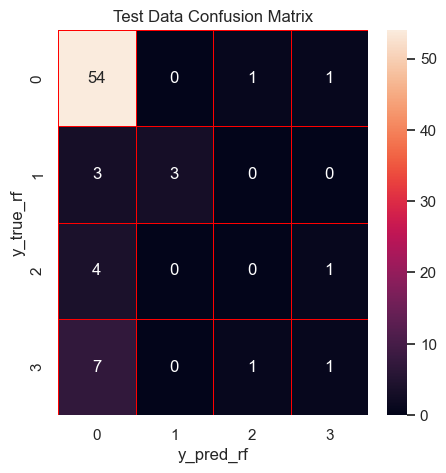

__________________________________________________
--------------------------------------------------
Results for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.79      0.98      0.87        56
           1       0.67      0.33      0.44         6
           2       0.00      0.00      0.00         5
           3       1.00      0.33      0.50         9

    accuracy                           0.79        76
   macro avg       0.61      0.41      0.45        76
weighted avg       0.75      0.79      0.74        76

Test Accuracy: 78.95%


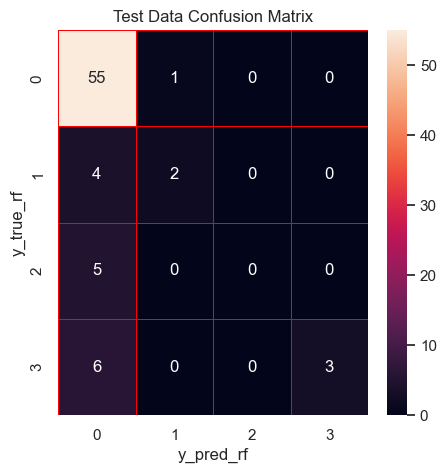

__________________________________________________
--------------------------------------------------
Results for SVC:
              precision    recall  f1-score   support

           0       0.74      0.96      0.84        56
           1       0.33      0.17      0.22         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.72        76
   macro avg       0.27      0.28      0.26        76
weighted avg       0.57      0.72      0.63        76

Test Accuracy: 72.37%


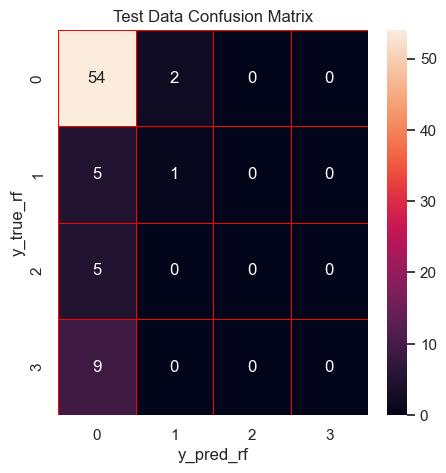

__________________________________________________
--------------------------------------------------
Results for MLPClassifier:
              precision    recall  f1-score   support

           0       0.79      0.98      0.87        56
           1       1.00      0.33      0.50         6
           2       0.00      0.00      0.00         5
           3       1.00      0.22      0.36         9

    accuracy                           0.78        76
   macro avg       0.70      0.38      0.43        76
weighted avg       0.78      0.78      0.73        76

Test Accuracy: 77.63%


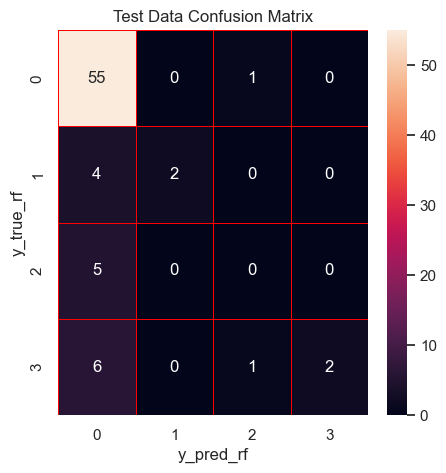

__________________________________________________
--------------------------------------------------
Results for GaussianNB:
              precision    recall  f1-score   support

           0       0.80      0.95      0.87        56
           1       0.25      0.17      0.20         6
           2       0.20      0.20      0.20         5
           3       0.00      0.00      0.00         9

    accuracy                           0.72        76
   macro avg       0.31      0.33      0.32        76
weighted avg       0.62      0.72      0.67        76

Test Accuracy: 72.37%


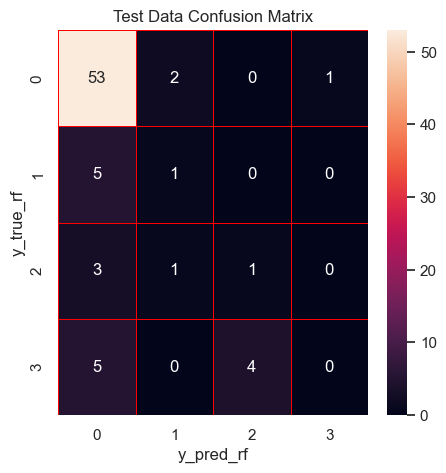

__________________________________________________
--------------------------------------------------
Results for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.75      0.82      0.79        56
           1       0.29      0.33      0.31         6
           2       0.17      0.20      0.18         5
           3       0.00      0.00      0.00         9

    accuracy                           0.64        76
   macro avg       0.30      0.34      0.32        76
weighted avg       0.59      0.64      0.62        76

Test Accuracy: 64.47%


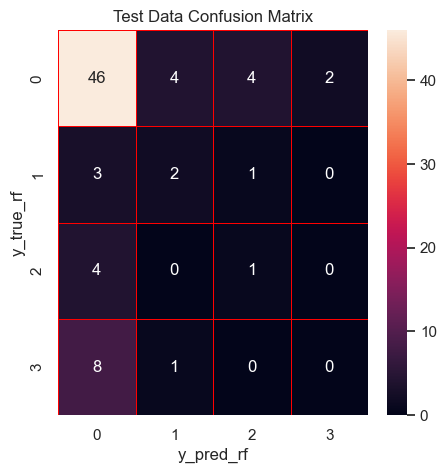

__________________________________________________
--------------------------------------------------
Results for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.79      0.95      0.86        56
           1       0.60      0.50      0.55         6
           2       0.00      0.00      0.00         5
           3       1.00      0.11      0.20         9

    accuracy                           0.75        76
   macro avg       0.60      0.39      0.40        76
weighted avg       0.75      0.75      0.70        76

Test Accuracy: 75.0%


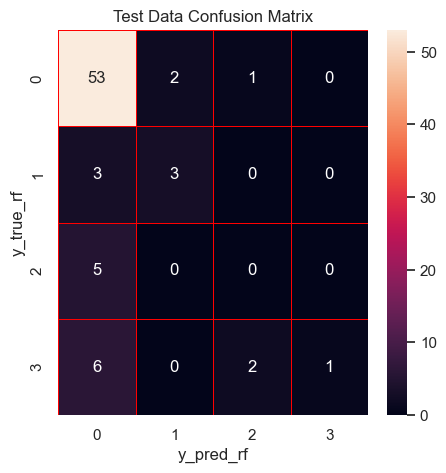

LogisticRegression  KNeighborsClassifier     SVC  MLPClassifier  \
0              0.7632                0.7895  0.7237         0.7763   

   GaussianNB  DecisionTreeClassifier  RandomForestClassifier  
0      0.7237                  0.6447                    0.75

In [291]:
showResult(classifiers,x_train_tael,y_train_tael["target"],test=[x_test_tael,y_test_tael["target"]])

In [342]:
topologicalFeaturesComplete(pd.DataFrame(x_train_tael),y_train_tael["target"])

LogisticRegression  KNeighborsClassifier     SVC  \
bottleneck                     0.7670                0.7557  0.7727   
wasserstein                    0.7670                0.7614  0.7727   
landscape                      0.7670                0.7557  0.7727   
betti                          0.7614                0.7670  0.7614   
heat                           0.7500                0.7955  0.7500   
silhouette                     0.7614                0.7670  0.7727   
persistence_image              0.7500                0.7500  0.7500   
entropy                        0.7500                0.7784  0.7500   

                   MLPClassifier  GaussianNB  DecisionTreeClassifier  \
bottleneck                0.7670      0.7500                  1.0000   
wasserstein               0.7614      0.7500                  1.0000   
landscape                 0.7670      0.7557                  0.9716   
betti                     0.7500      0.7443                  0.8295   
heat                      0.7500      0.7500                  0.8182   
silhouette                0.7614      0.7557                  0.9716   
persistence_image         0.7500      0.7500                  0.7500   
entropy                   0.7500      0.4375                  1.0000   

                   RandomForestClassifier  
bottleneck                         1.0000  
wasserstein                        1.0000  
landscape                          0.9716  
betti                              0.8295  
heat                               0.8182  
silhouette                         0.9716  
persistence_image                  0.7500  
entropy                            1.0000

****************************************
Results for LogisticRegression:
              precision    recall  f1-score   support

           0       0.73      0.96      0.83        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.71        76
   macro avg       0.18      0.24      0.21        76
weighted avg       0.54      0.71      0.61        76

Test Accuracy: 71.05%


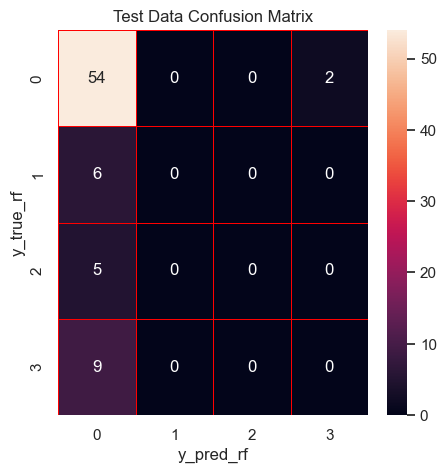

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.73      0.96      0.83        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.71        76
   macro avg       0.18      0.24      0.21        76
weighted avg       0.54      0.71      0.61        76

Test Accuracy: 71.05%


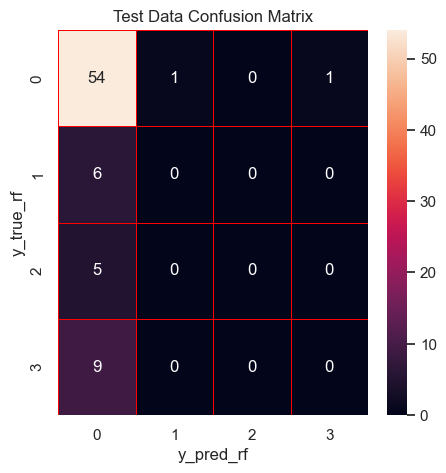

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for SVC:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.74        76
   macro avg       0.18      0.25      0.21        76
weighted avg       0.54      0.74      0.63        76

Test Accuracy: 73.68%


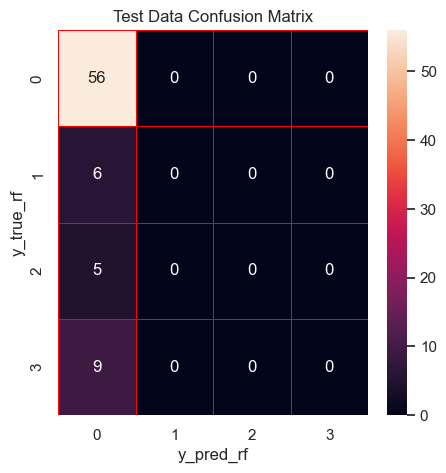

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for MLPClassifier:
              precision    recall  f1-score   support

           0       0.74      0.96      0.84        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.71        76
   macro avg       0.18      0.24      0.21        76
weighted avg       0.55      0.71      0.62        76

Test Accuracy: 71.05%


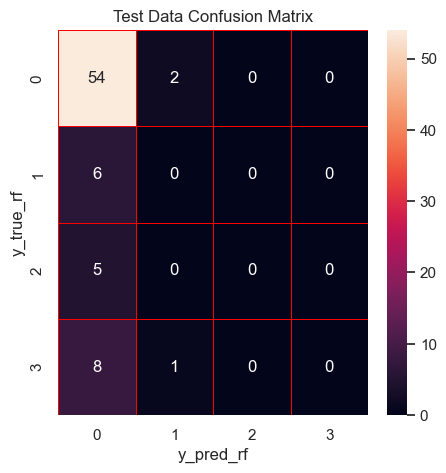

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for GaussianNB:
              precision    recall  f1-score   support

           0       0.76      0.93      0.84        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.68        76
   macro avg       0.19      0.23      0.21        76
weighted avg       0.56      0.68      0.62        76

Test Accuracy: 68.42%


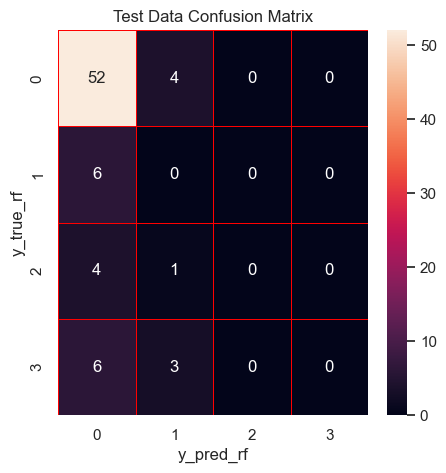

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.63        76
   macro avg       0.19      0.21      0.20        76
weighted avg       0.55      0.63      0.59        76

Test Accuracy: 63.16%


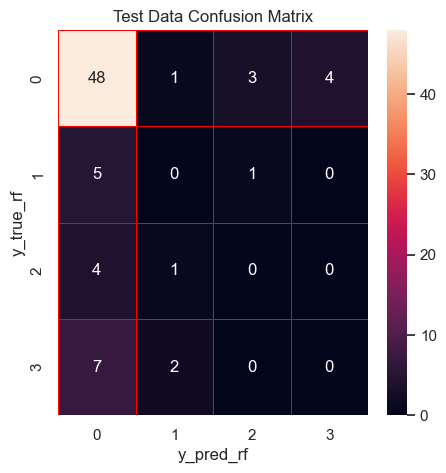

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.63        76
   macro avg       0.19      0.21      0.20        76
weighted avg       0.55      0.63      0.59        76

Test Accuracy: 63.16%


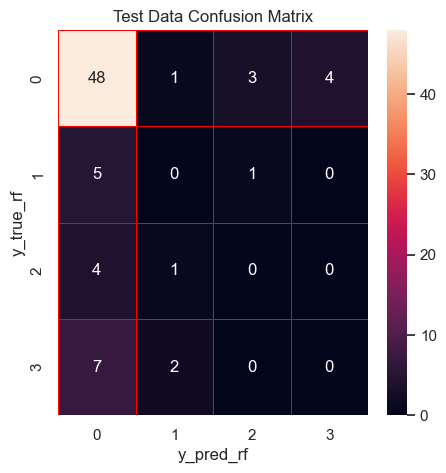

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for LogisticRegression:
              precision    recall  f1-score   support

           0       0.73      0.96      0.83        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.71        76
   macro avg       0.18      0.24      0.21        76
weighted avg       0.54      0.71      0.61        76

Test Accuracy: 71.05%


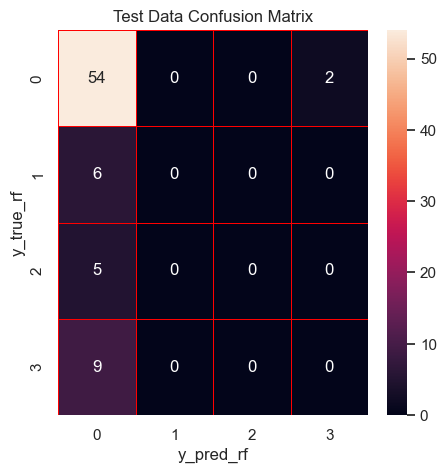

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.73      0.96      0.83        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.71        76
   macro avg       0.18      0.24      0.21        76
weighted avg       0.54      0.71      0.61        76

Test Accuracy: 71.05%


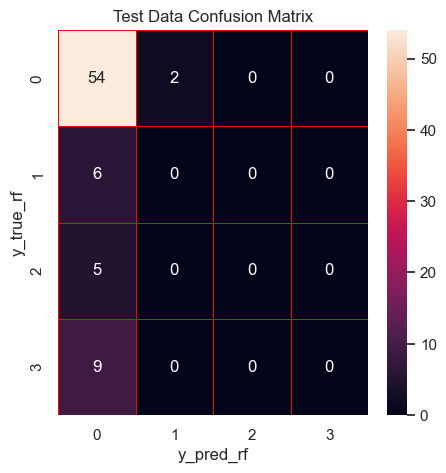

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for SVC:
              precision    recall  f1-score   support

           0       0.73      0.98      0.84        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.72        76
   macro avg       0.18      0.25      0.21        76
weighted avg       0.54      0.72      0.62        76

Test Accuracy: 72.37%


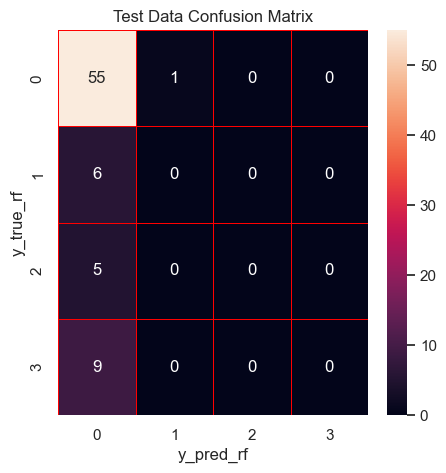

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for MLPClassifier:
              precision    recall  f1-score   support

           0       0.73      0.96      0.83        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.71        76
   macro avg       0.18      0.24      0.21        76
weighted avg       0.54      0.71      0.61        76

Test Accuracy: 71.05%


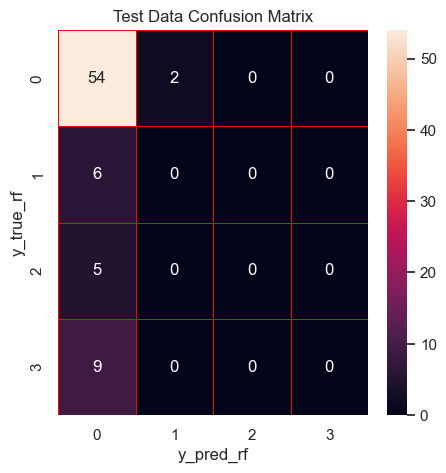

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for GaussianNB:
              precision    recall  f1-score   support

           0       0.77      0.95      0.85        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.70        76
   macro avg       0.19      0.24      0.21        76
weighted avg       0.57      0.70      0.62        76

Test Accuracy: 69.74%


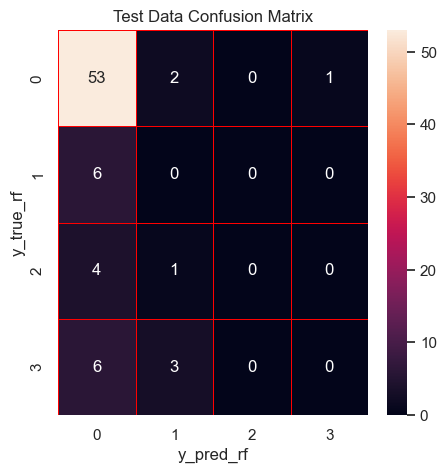

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.81      0.82      0.81        56
           1       0.00      0.00      0.00         6
           2       0.12      0.20      0.15         5
           3       0.25      0.11      0.15         9

    accuracy                           0.63        76
   macro avg       0.30      0.28      0.28        76
weighted avg       0.63      0.63      0.63        76

Test Accuracy: 63.16%


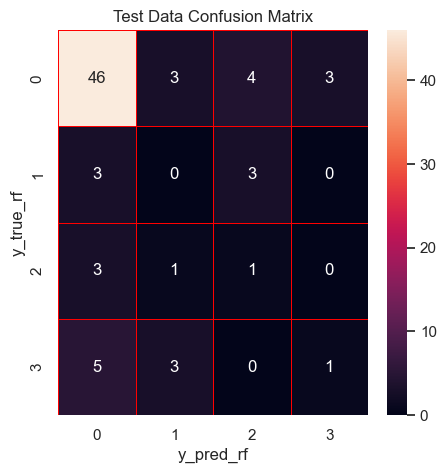

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.81      0.82      0.81        56
           1       0.00      0.00      0.00         6
           2       0.12      0.20      0.15         5
           3       0.25      0.11      0.15         9

    accuracy                           0.63        76
   macro avg       0.30      0.28      0.28        76
weighted avg       0.63      0.63      0.63        76

Test Accuracy: 63.16%


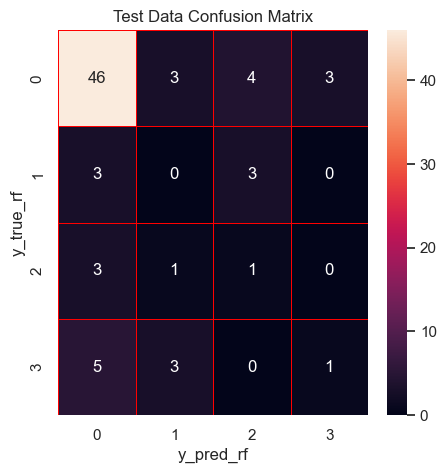

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for LogisticRegression:
              precision    recall  f1-score   support

           0       0.74      0.96      0.84        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.71        76
   macro avg       0.18      0.24      0.21        76
weighted avg       0.55      0.71      0.62        76

Test Accuracy: 71.05%


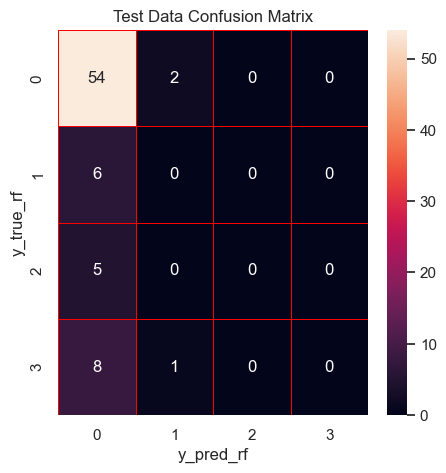

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.75      1.00      0.85        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       1.00      0.11      0.20         9

    accuracy                           0.75        76
   macro avg       0.44      0.28      0.26        76
weighted avg       0.67      0.75      0.65        76

Test Accuracy: 75.0%


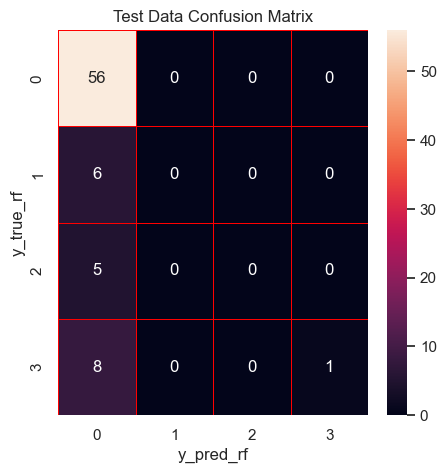

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for SVC:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.74        76
   macro avg       0.18      0.25      0.21        76
weighted avg       0.54      0.74      0.63        76

Test Accuracy: 73.68%


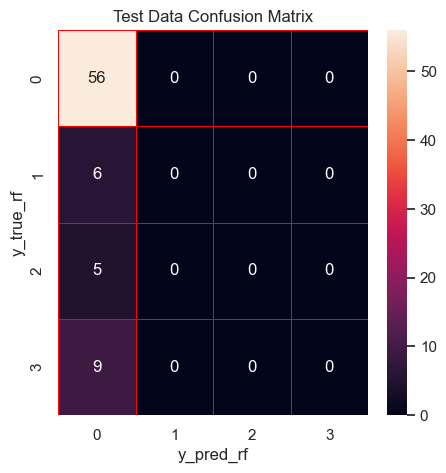

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for MLPClassifier:
              precision    recall  f1-score   support

           0       0.74      0.96      0.84        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.71        76
   macro avg       0.18      0.24      0.21        76
weighted avg       0.55      0.71      0.62        76

Test Accuracy: 71.05%


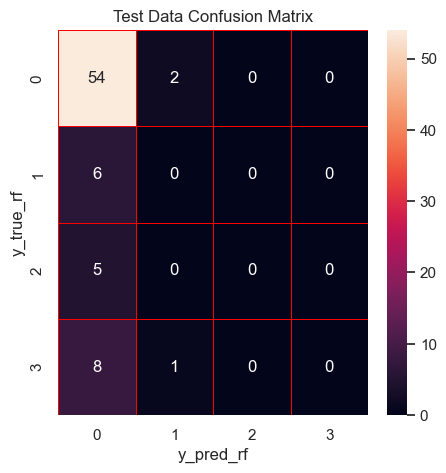

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for GaussianNB:
              precision    recall  f1-score   support

           0       0.77      0.95      0.85        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.70        76
   macro avg       0.19      0.24      0.21        76
weighted avg       0.57      0.70      0.62        76

Test Accuracy: 69.74%


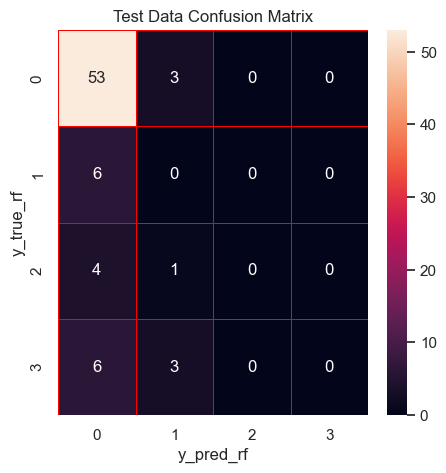

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.75      0.80      0.78        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.09      0.11      0.10         9

    accuracy                           0.61        76
   macro avg       0.21      0.23      0.22        76
weighted avg       0.56      0.61      0.58        76

Test Accuracy: 60.53%


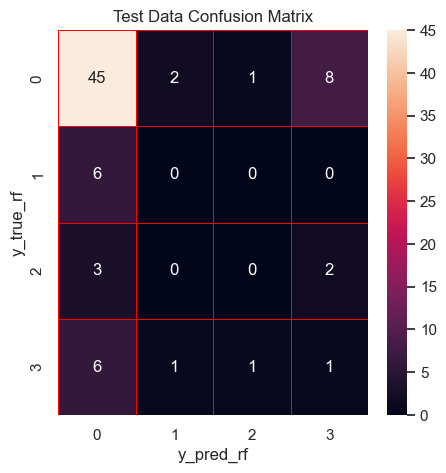

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.75      0.80      0.78        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.09      0.11      0.10         9

    accuracy                           0.61        76
   macro avg       0.21      0.23      0.22        76
weighted avg       0.56      0.61      0.58        76

Test Accuracy: 60.53%


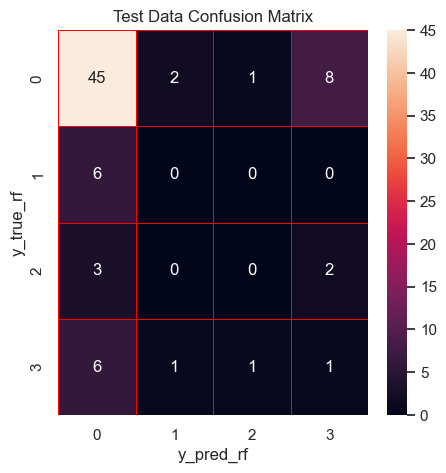

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for LogisticRegression:
              precision    recall  f1-score   support

           0       0.73      0.98      0.84        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.72        76
   macro avg       0.18      0.25      0.21        76
weighted avg       0.54      0.72      0.62        76

Test Accuracy: 72.37%


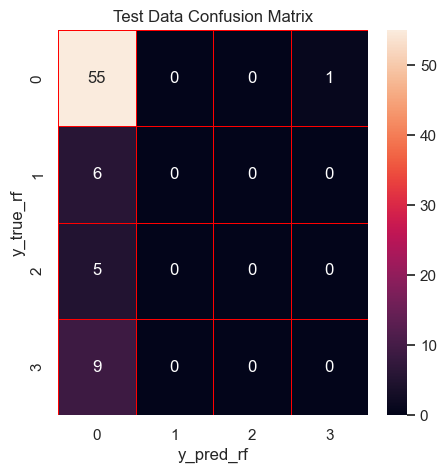

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.73      0.98      0.84        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.72        76
   macro avg       0.18      0.25      0.21        76
weighted avg       0.54      0.72      0.62        76

Test Accuracy: 72.37%


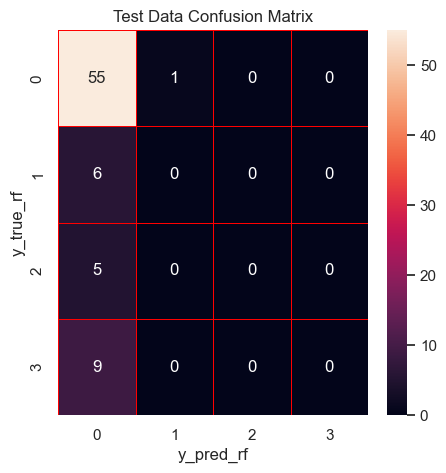

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for SVC:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.74        76
   macro avg       0.18      0.25      0.21        76
weighted avg       0.54      0.74      0.63        76

Test Accuracy: 73.68%


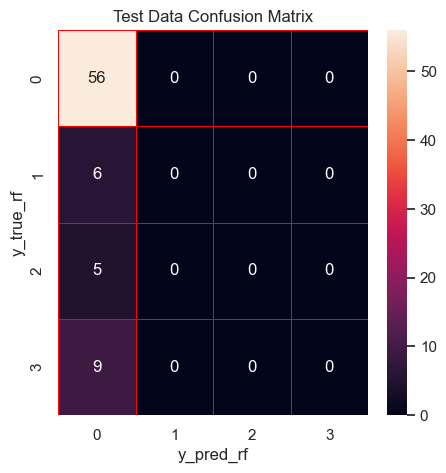

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for MLPClassifier:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.74        76
   macro avg       0.18      0.25      0.21        76
weighted avg       0.54      0.74      0.63        76

Test Accuracy: 73.68%


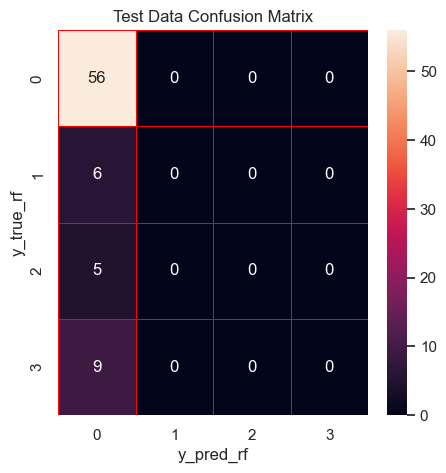

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for GaussianNB:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.55        76
   macro avg       0.18      0.19      0.18        76
weighted avg       0.52      0.55      0.54        76

Test Accuracy: 55.26%


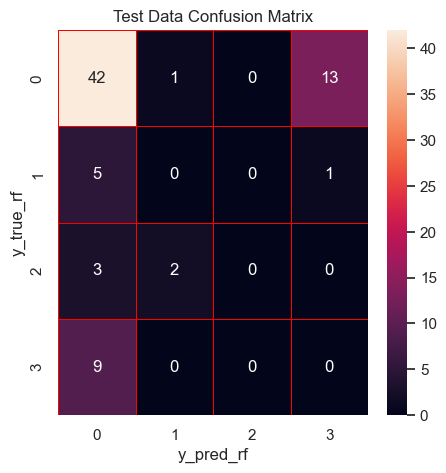

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.73      0.95      0.82        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.70        76
   macro avg       0.18      0.24      0.21        76
weighted avg       0.53      0.70      0.61        76

Test Accuracy: 69.74%


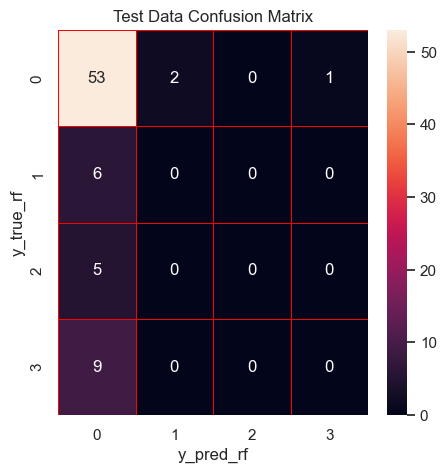

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.73      0.95      0.82        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.70        76
   macro avg       0.18      0.24      0.21        76
weighted avg       0.53      0.70      0.61        76

Test Accuracy: 69.74%


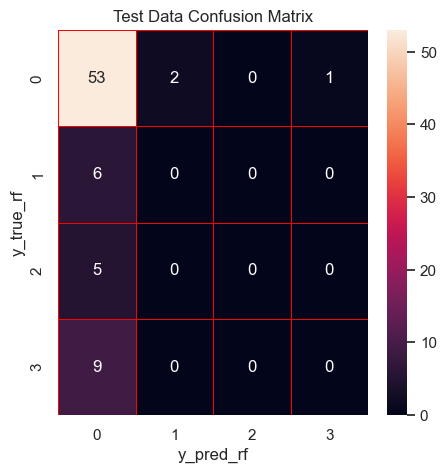

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for LogisticRegression:
              precision    recall  f1-score   support

           0       0.73      0.98      0.84        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.72        76
   macro avg       0.18      0.25      0.21        76
weighted avg       0.54      0.72      0.62        76

Test Accuracy: 72.37%


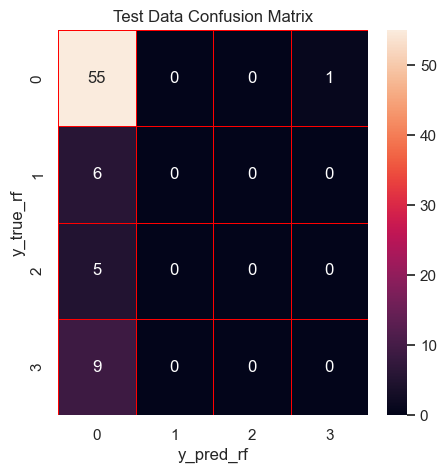

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.63        76
   macro avg       0.19      0.21      0.20        76
weighted avg       0.55      0.63      0.59        76

Test Accuracy: 63.16%


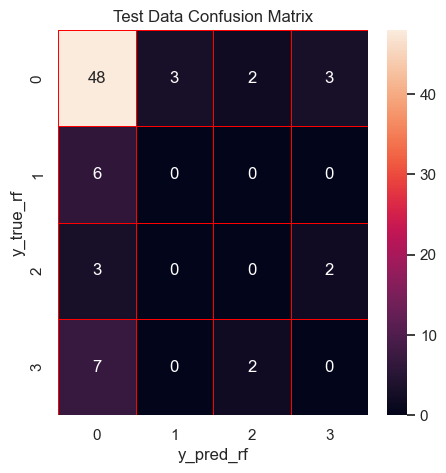

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for SVC:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.74        76
   macro avg       0.18      0.25      0.21        76
weighted avg       0.54      0.74      0.63        76

Test Accuracy: 73.68%


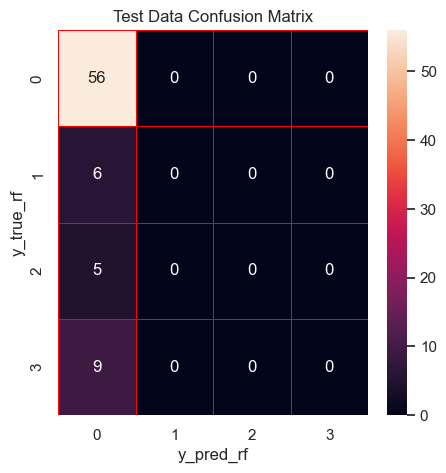

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for MLPClassifier:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.74        76
   macro avg       0.18      0.25      0.21        76
weighted avg       0.54      0.74      0.63        76

Test Accuracy: 73.68%


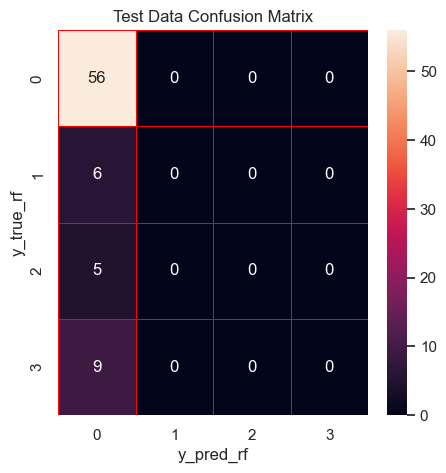

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for GaussianNB:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.74        76
   macro avg       0.18      0.25      0.21        76
weighted avg       0.54      0.74      0.63        76

Test Accuracy: 73.68%


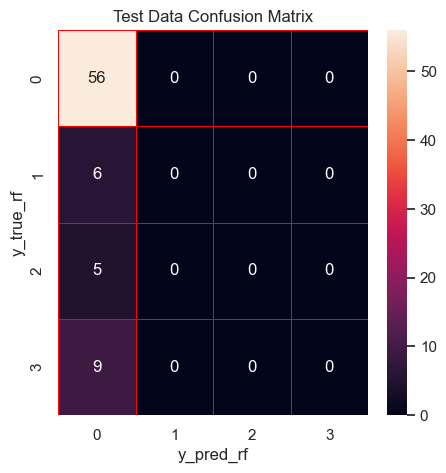

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.63        76
   macro avg       0.19      0.21      0.20        76
weighted avg       0.55      0.63      0.59        76

Test Accuracy: 63.16%


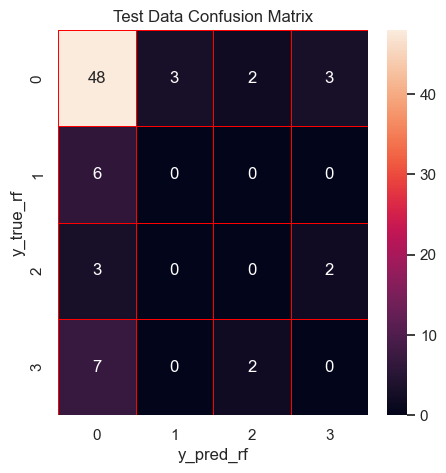

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.63        76
   macro avg       0.19      0.21      0.20        76
weighted avg       0.55      0.63      0.59        76

Test Accuracy: 63.16%


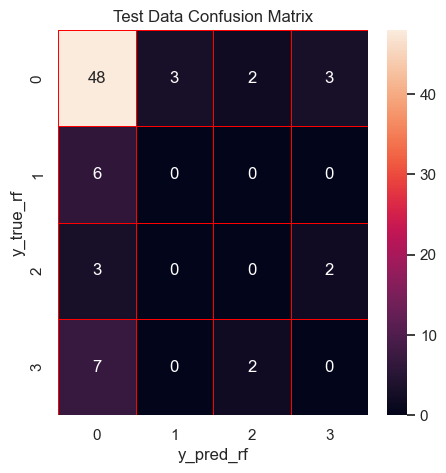

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for LogisticRegression:
              precision    recall  f1-score   support

           0       0.74      0.96      0.84        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.71        76
   macro avg       0.18      0.24      0.21        76
weighted avg       0.55      0.71      0.62        76

Test Accuracy: 71.05%


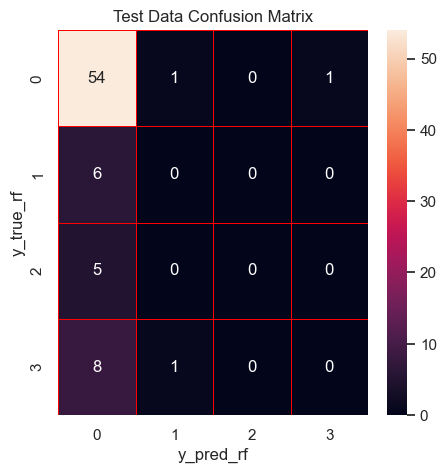

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.75      0.89      0.81        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.14      0.11      0.12         9

    accuracy                           0.67        76
   macro avg       0.22      0.25      0.23        76
weighted avg       0.57      0.67      0.61        76

Test Accuracy: 67.11%


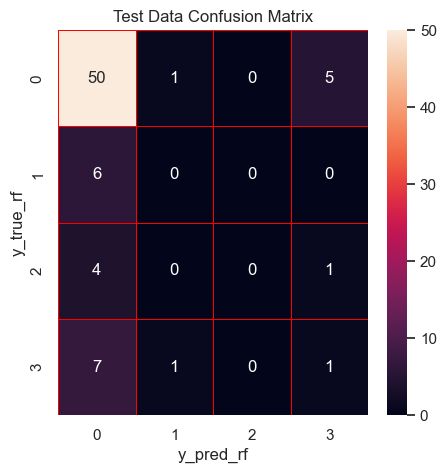

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for SVC:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.74        76
   macro avg       0.18      0.25      0.21        76
weighted avg       0.54      0.74      0.63        76

Test Accuracy: 73.68%


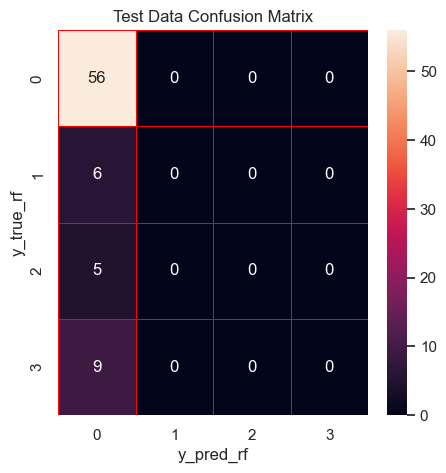

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for MLPClassifier:
              precision    recall  f1-score   support

           0       0.74      0.96      0.84        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.71        76
   macro avg       0.18      0.24      0.21        76
weighted avg       0.55      0.71      0.62        76

Test Accuracy: 71.05%


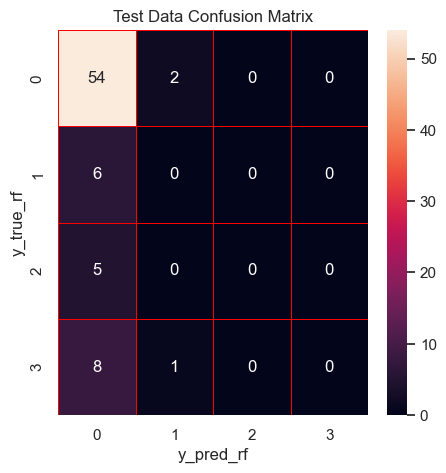

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for GaussianNB:
              precision    recall  f1-score   support

           0       0.74      0.93      0.83        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.68        76
   macro avg       0.19      0.23      0.21        76
weighted avg       0.55      0.68      0.61        76

Test Accuracy: 68.42%


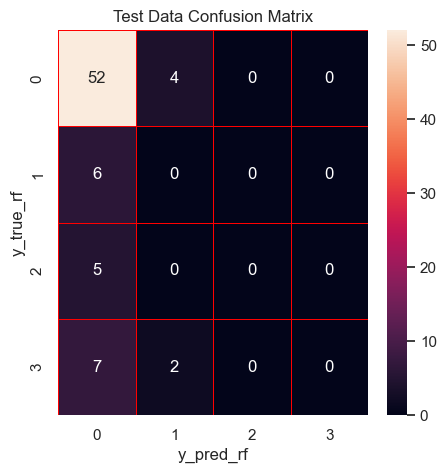

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.72      0.61      0.66        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.14      0.22      0.17         9

    accuracy                           0.47        76
   macro avg       0.22      0.21      0.21        76
weighted avg       0.55      0.47      0.51        76

Test Accuracy: 47.37%


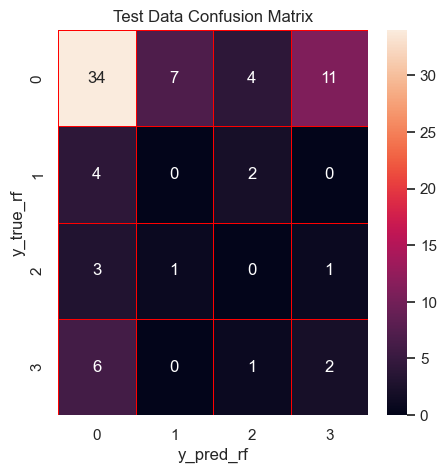

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.72      0.61      0.66        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.14      0.22      0.17         9

    accuracy                           0.47        76
   macro avg       0.22      0.21      0.21        76
weighted avg       0.55      0.47      0.51        76

Test Accuracy: 47.37%


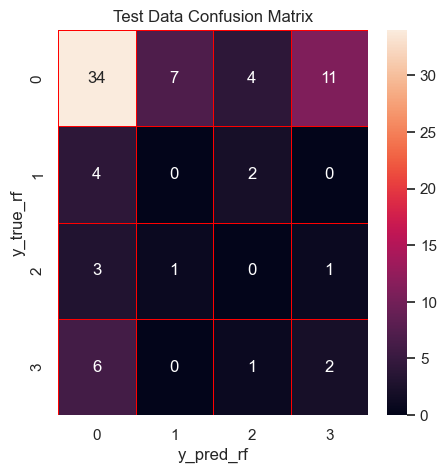

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for LogisticRegression:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.74        76
   macro avg       0.18      0.25      0.21        76
weighted avg       0.54      0.74      0.63        76

Test Accuracy: 73.68%


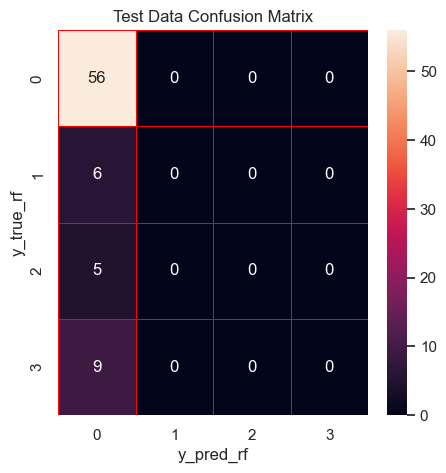

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.74        76
   macro avg       0.18      0.25      0.21        76
weighted avg       0.54      0.74      0.63        76

Test Accuracy: 73.68%


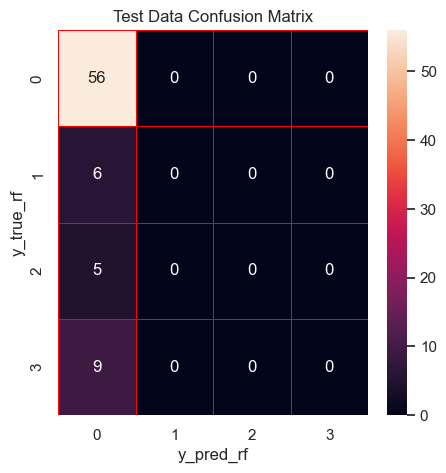

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for SVC:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.74        76
   macro avg       0.18      0.25      0.21        76
weighted avg       0.54      0.74      0.63        76

Test Accuracy: 73.68%


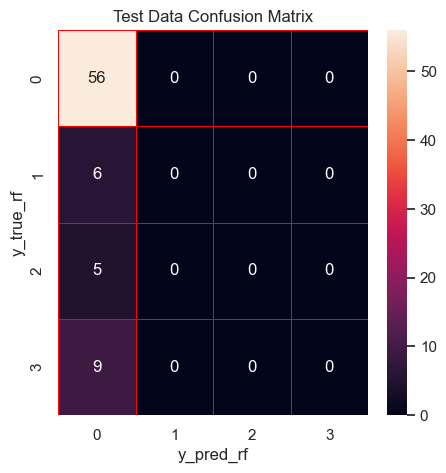

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for MLPClassifier:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.74        76
   macro avg       0.18      0.25      0.21        76
weighted avg       0.54      0.74      0.63        76

Test Accuracy: 73.68%


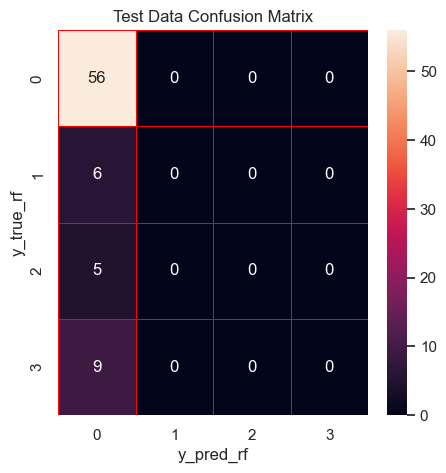

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for GaussianNB:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.74        76
   macro avg       0.18      0.25      0.21        76
weighted avg       0.54      0.74      0.63        76

Test Accuracy: 73.68%


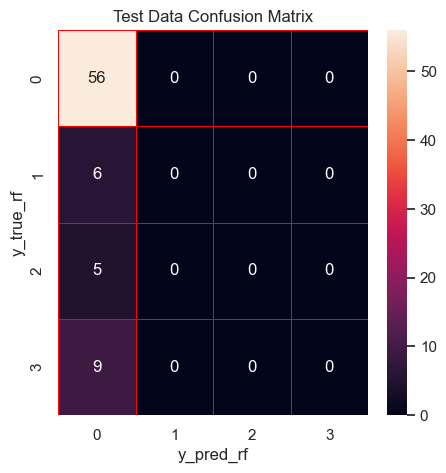

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.74        76
   macro avg       0.18      0.25      0.21        76
weighted avg       0.54      0.74      0.63        76

Test Accuracy: 73.68%


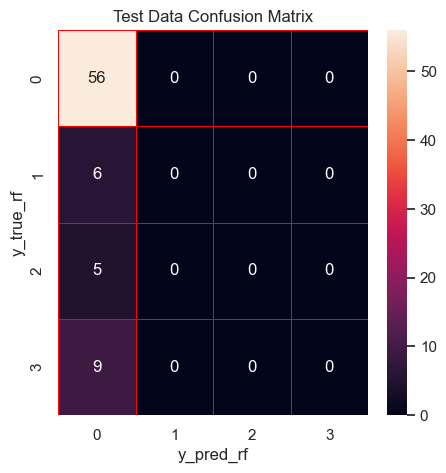

++++++++++++++++++++++++++++++++++++++++
****************************************
Results for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.74        76
   macro avg       0.18      0.25      0.21        76
weighted avg       0.54      0.74      0.63        76

Test Accuracy: 73.68%


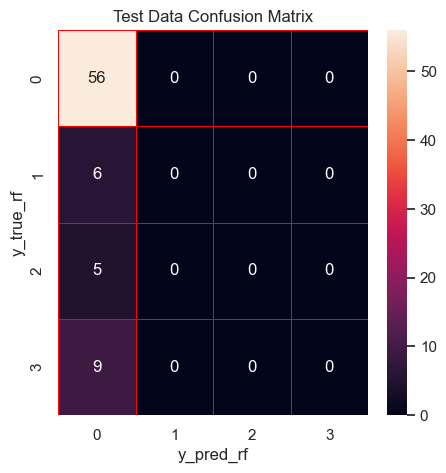

++++++++++++++++++++++++++++++++++++++++
Results for LogisticRegression:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.74        76
   macro avg       0.18      0.25      0.21        76
weighted avg       0.54      0.74      0.63        76

Test Accuracy: 73.68%


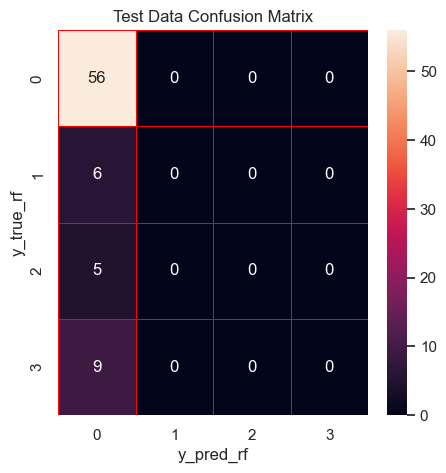

Results for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.76      0.95      0.84        56
           1       0.33      0.33      0.33         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.72        76
   macro avg       0.27      0.32      0.29        76
weighted avg       0.58      0.72      0.65        76

Test Accuracy: 72.37%


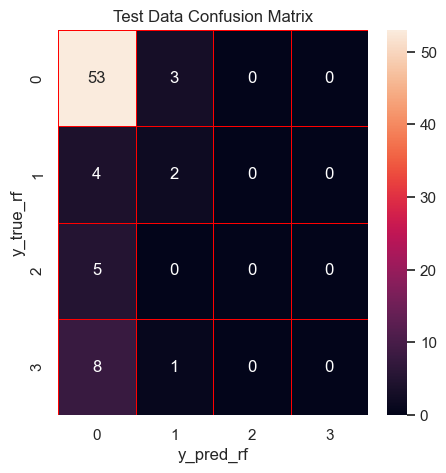

Results for SVC:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.74        76
   macro avg       0.18      0.25      0.21        76
weighted avg       0.54      0.74      0.63        76

Test Accuracy: 73.68%


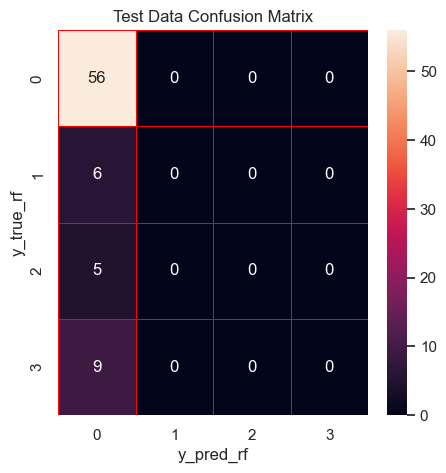

Results for MLPClassifier:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.74        76
   macro avg       0.18      0.25      0.21        76
weighted avg       0.54      0.74      0.63        76

Test Accuracy: 73.68%


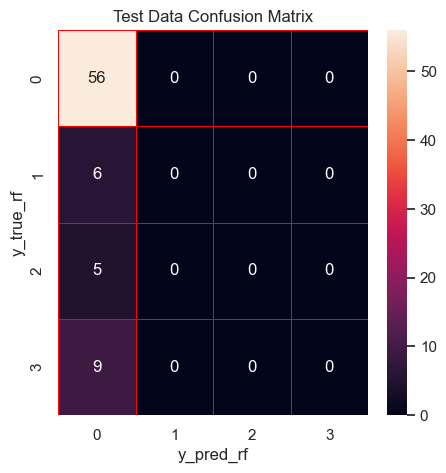

Results for GaussianNB:
              precision    recall  f1-score   support

           0       0.83      0.52      0.64        56
           1       0.12      0.83      0.22         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.45        76
   macro avg       0.24      0.34      0.21        76
weighted avg       0.62      0.45      0.49        76

Test Accuracy: 44.74%


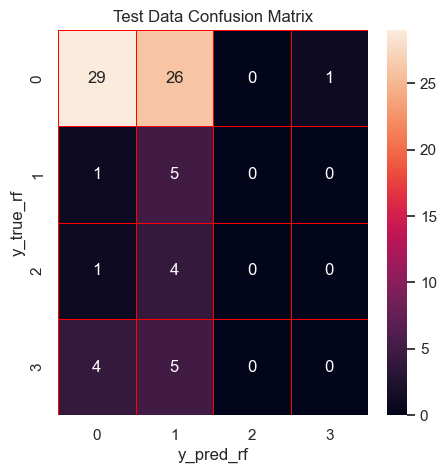

Results for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.73      0.77      0.75        56
           1       0.17      0.17      0.17         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.58        76
   macro avg       0.22      0.23      0.23        76
weighted avg       0.55      0.58      0.56        76

Test Accuracy: 57.89%


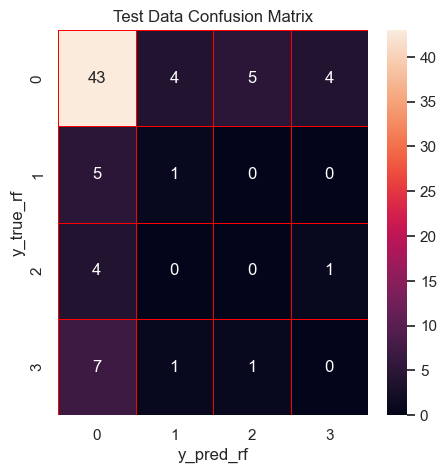

Results for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.73      0.77      0.75        56
           1       0.17      0.17      0.17         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.58        76
   macro avg       0.22      0.23      0.23        76
weighted avg       0.55      0.58      0.56        76

Test Accuracy: 57.89%


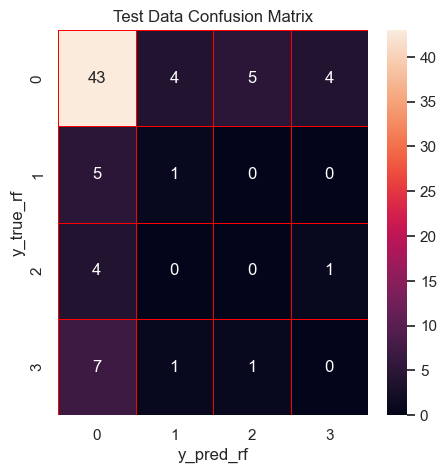

LogisticRegression  KNeighborsClassifier     SVC  \
bottleneck                     0.7105                0.7105  0.7368   
wasserstein                    0.7105                0.7105  0.7237   
landscape                      0.7105                0.7500  0.7368   
betti                          0.7237                0.7237  0.7368   
heat                           0.7237                0.6316  0.7368   
silhouette                     0.7105                0.6711  0.7368   
persistence_image              0.7368                0.7368  0.7368   
entropy                        0.7368                0.7237  0.7368   

                   MLPClassifier  GaussianNB  DecisionTreeClassifier  \
bottleneck                0.7105      0.6842                  0.6316   
wasserstein               0.7105      0.6974                  0.6316   
landscape                 0.7105      0.6974                  0.6053   
betti                     0.7368      0.5526                  0.6974   
heat                      0.7368      0.7368                  0.6316   
silhouette                0.7105      0.6842                  0.4737   
persistence_image         0.7368      0.7368                  0.7368   
entropy                   0.7368      0.4474                  0.5789   

                   RandomForestClassifier  
bottleneck                         0.6316  
wasserstein                        0.6316  
landscape                          0.6053  
betti                              0.6974  
heat                               0.6316  
silhouette                         0.4737  
persistence_image                  0.7368  
entropy                            0.5789

In [298]:
topologicalFeaturesComplete(pd.DataFrame(x_train_tael),y_train_tael,test=[pd.DataFrame(x_test_tael),y_test_tael])

In the context of the Random Forest algorithm for classification, both oob_score_ and score are metrics used to evaluate the performance of the model. However, they are calculated differently and serve different purposes.

oob_score_:
oob_score_ stands for "out-of-bag score." It is a metric used in Random Forest when applying the "Out-of-Bag" (OOB) evaluation method. In Random Forest, each decision tree is trained on a random subset of the data (bootstrapped sample) where about one-third of the data is left out, and this left-out data is referred to as "out-of-bag" data.
The OOB score is calculated by evaluating each individual tree in the Random Forest on the out-of-bag data that was not used during its training. This process is done for each tree, and the overall OOB score is obtained by aggregating the results from all the trees. It provides an estimate of the model's performance on unseen data without the need for a separate validation set.

score:
In the context of scikit-learn, the score method is used to calculate the accuracy of the Random Forest model on a specified test dataset. It is typically used after the model has been trained, and it evaluates the model's performance on data that it has not seen during training.
The score method computes the accuracy, which is the proportion of correct predictions made by the model over the total number of data points in the test dataset. It is a common evaluation metric for classification tasks but can be customized by using different scoring functions in scikit-learn.

In summary:

oob_score_ is an estimate of the model's performance on unseen data using the out-of-bag data from the training process.
score calculates the accuracy of the model on a specified test dataset.

In [ ]:
to

In [79]:
from gtda.diagrams import PersistenceEntropy
# Creating the diagram generation pipeline
diagram_steps = [
   VietorisRipsPersistence(homology_dimensions=[0, 1, 2]),
]

# Select a variety of metrics to calculate amplitudes
metric_list = [
    {"metric": metric}
    for metric in ["bottleneck", "wasserstein", "landscape", "betti", "heat", "silhouette", "persistence_image"]
]

# Concatenate to generate 3 + 3 + (4 x 3) = 18 topological features
feature_union = make_union(
    *[PersistenceEntropy(nan_fill_value=-1)]
    + [Amplitude(**metric, n_jobs=-1) for metric in metric_list]
)

# Create the diagram generation pipelines
pipeline_list = [
    make_pipeline(diagram_step, feature_union)
    for diagram_step in diagram_steps
]

# Create the final TDA union pipeline
tda_union = make_union(*pipeline_list, n_jobs=-1)

In [346]:
def tda_tranform(metrics,data):
    #daa must be of type numpy
    # Creating the diagram generation pipeline
    diagram_steps = [
       VietorisRipsPersistence(homology_dimensions=[0, 1, 2]),
    ]

    # Select a variety of metrics to calculate amplitudes
    metric_list = [
        {"metric": metric}
        for metric in metrics
    ]

    # Concatenate to generate 3 + 3 + (4 x 3) = 18 topological features
    feature_union = make_union(
        *[PersistenceEntropy(nan_fill_value=-1)]
        + [Amplitude(**metric, n_jobs=-1) for metric in metric_list]
    )

    # Create the diagram generation pipelines
    pipeline_list = [
        make_pipeline(diagram_step, feature_union)
        for diagram_step in diagram_steps
    ]

    # Create the final TDA union pipeline
    tda_union = make_union(*pipeline_list, n_jobs=-1)
    data = data.reshape(data.shape[0],data.shape[1],1)
    return tda_union.fit_transform(data)
    

In [86]:
from sklearn import set_config
set_config(display='diagram')

tda_union

FeatureUnion(n_jobs=-1,
             transformer_list=[('pipeline',
                                Pipeline(steps=[('vietorisripspersistence',
                                                 VietorisRipsPersistence(homology_dimensions=[0,
                                                                                              1,
                                                                                              2])),
                                                ('featureunion',
                                                 FeatureUnion(transformer_list=[('persistenceentropy',
                                                                                 PersistenceEntropy(nan_fill_value=-1)),
                                                                                ('amplitude-1',
                                                                                 Amplitude(metric='bottleneck',
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-2',
                                                                                 Amplitude(metric='wasserstein',
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-3',
                                                                                 Amplitude(n_jobs=-1)),
                                                                                ('amplitude-4',
                                                                                 Amplitude(metric='betti',
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-5',
                                                                                 Amplitude(metric='heat',
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-6',
                                                                                 Amplitude(metric='silhouette',
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-7',
                                                                                 Amplitude(metric='persistence_image',
                                                                                           n_jobs=-1))]))]))])

In [343]:
y_train.columns

Index(['mortalité à J30', 'mortalité à 90j', 'mortalité à un an', 'target'], dtype='object')

In [330]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled,Y,
                                test_size = 0.3, random_state = 7)

In [344]:
topologicalFeaturesComplete(pd.DataFrame(x_train),y_train["target"])

LogisticRegression  KNeighborsClassifier     SVC  \
bottleneck                     0.7670                0.7614  0.7784   
wasserstein                    0.7670                0.7614  0.7784   
landscape                      0.7614                0.7557  0.7784   
betti                          0.7500                0.7727  0.7500   
heat                           0.7330                0.7614  0.7500   
silhouette                     0.7614                0.7727  0.7727   
persistence_image              0.7500                0.7500  0.7500   
entropy                        0.7500                0.7784  0.7500   

                   MLPClassifier  GaussianNB  DecisionTreeClassifier  \
bottleneck                0.7670      0.7670                  0.9148   
wasserstein               0.7727      0.7557                  1.0000   
landscape                 0.7727      0.7670                  0.8807   
betti                     0.7500      0.7614                  0.8466   
heat                      0.7500      0.7443                  0.7727   
silhouette                0.7727      0.7727                  0.9205   
persistence_image         0.7500      0.7500                  0.7500   
entropy                   0.7557      0.7500                  1.0000   

                   RandomForestClassifier  
bottleneck                         0.9148  
wasserstein                        1.0000  
landscape                          0.8807  
betti                              0.8466  
heat                               0.7727  
silhouette                         0.9205  
persistence_image                  0.7500  
entropy                            1.0000

In [357]:
#Best result with SVC, MLP and and KNeighborsClassifier
#SVC
svc_train_data=tda_tranform(['bottleneck','wasserstein','landscape'],x_train.to_numpy())
svc_test_data=tda_tranform(['bottleneck','wasserstein','landscape'],x_test.to_numpy())
#MLP
mlp_train_data=tda_tranform(['wasserstein','landscape','silhouette'],x_train.to_numpy())
mlp_test_data=tda_tranform(['wasserstein','landscape','silhouette'],x_test.to_numpy())

In [387]:
from imblearn.over_sampling import RandomOverSampler
# Initialize RandomOverSampler
ros = RandomOverSampler(random_state=42)

In [358]:
MLPmod = classification(MLPClassifier,mlp_train_data,y_train["target"], model_out=True,
                        random_state = 7, results=False)

In [359]:
#Cross validation
print("MLP cross val score accuracy is:",
      np.mean(cross_val_score(MLPmod, mlp_test_data, y_test['target'], cv = 5)).round(5))

MLP cross val score accuracy is: 0.73667


In [389]:
params = {
    'hidden_layer_sizes': [(100,), (50,50), (50,50,50),
                           (50,100,50), (100,100,50)],
    'activation': ['relu', 'logistic', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.0005, 0.005, 0.01, 0.05, 0.1],
    'learning_rate': ['constant','adaptive'],
    'max_iter': [100,200,400]
}

In [390]:
gscv_MLP_accuracy = GridSearchCV(estimator=MLPClassifier(),param_grid=params,
                                 n_jobs=3, scoring = 'accuracy')
gscv_MLP_accuracy.fit(mlp_train_data,y_train['target'])

print(gscv_MLP_accuracy.best_estimator_)
print(gscv_MLP_accuracy.best_params_)

MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 100, 50),
              learning_rate='adaptive', max_iter=400)
{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'max_iter': 400, 'solver': 'adam'}


Results for Accuracy Optimized Multi-Layer Perceptron GSCV
              precision    recall  f1-score   support

           0       0.80      0.98      0.88       132
           1       0.75      0.38      0.50        16
           2       0.50      0.08      0.13        13
           3       1.00      0.20      0.33        15

    accuracy                           0.80       176
   macro avg       0.76      0.41      0.46       176
weighted avg       0.79      0.80      0.74       176

Training Accuracy: 0.7955
Training Recall: 0.375


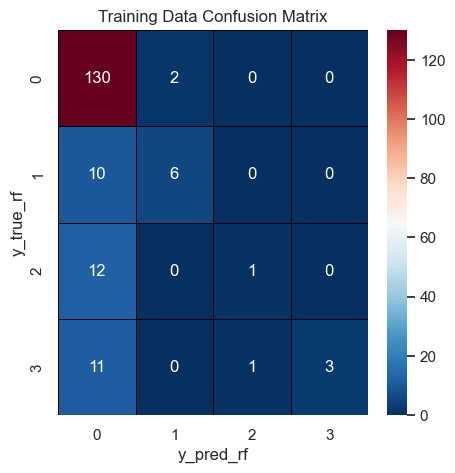

In [392]:
y_pred_accuracy = gscv_MLP_accuracy.predict(mlp_train_data)

print("Results for Accuracy Optimized Multi-Layer Perceptron GSCV")
classification_results(mlp_train_data,y_train["target"],y_pred_accuracy,gscv_MLP_accuracy)

In [394]:
gscv_MLP_recall = GridSearchCV(estimator=MLPClassifier(),param_grid=params,
                               n_jobs=3, scoring = 'recall_macro',pre_dispatch='2*n_jobs')
# Fit the grid search to the data using oversampling
X_train_resampled, y_train_resampled = ros.fit_resample(mlp_train_data, y_train['target'])

gscv_MLP_recall.fit(X_train_resampled, y_train_resampled)

print(gscv_MLP_recall.best_estimator_)
print(gscv_MLP_recall.best_params_)

MLPClassifier(hidden_layer_sizes=(50, 100, 50), learning_rate='adaptive',
              max_iter=400)
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'max_iter': 400, 'solver': 'adam'}


Results for Recall Optimized Multi-Layer Perceptron GSCV
              precision    recall  f1-score   support

           0       0.87      0.61      0.72       132
           1       0.62      0.81      0.70        16
           2       0.44      0.62      0.52        13
           3       0.18      0.53      0.27        15

    accuracy                           0.62       176
   macro avg       0.53      0.64      0.55       176
weighted avg       0.76      0.62      0.67       176

Training Accuracy: 0.625
Training Recall: 0.8125


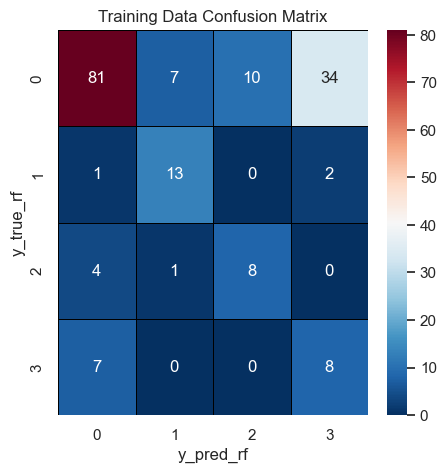

In [395]:
y_pred_recall = gscv_MLP_recall.predict(mlp_train_data)

print("Results for Recall Optimized Multi-Layer Perceptron GSCV")
classification_results(mlp_train_data,y_train['target'],y_pred_recall,gscv_MLP_recall)

__________________________________________________
--------------------------------------------------
Results for: 0.3
              precision    recall  f1-score   support

           0       0.81      0.94      0.87       132
           1       0.59      0.81      0.68        16
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00        15

    accuracy                           0.78       176
   macro avg       0.35      0.44      0.39       176
weighted avg       0.66      0.78      0.71       176

Training Accuracy: 0.7784
Training Recall: 0.8125


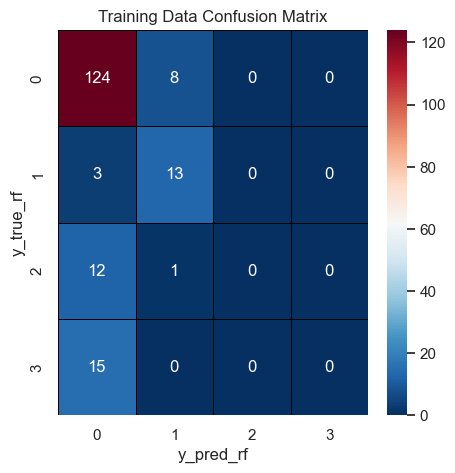

__________________________________________________
--------------------------------------------------
Results for: 0.35
              precision    recall  f1-score   support

           0       0.81      0.95      0.87       132
           1       0.62      0.81      0.70        16
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00        15

    accuracy                           0.78       176
   macro avg       0.36      0.44      0.39       176
weighted avg       0.66      0.78      0.72       176

Training Accuracy: 0.7841
Training Recall: 0.8125


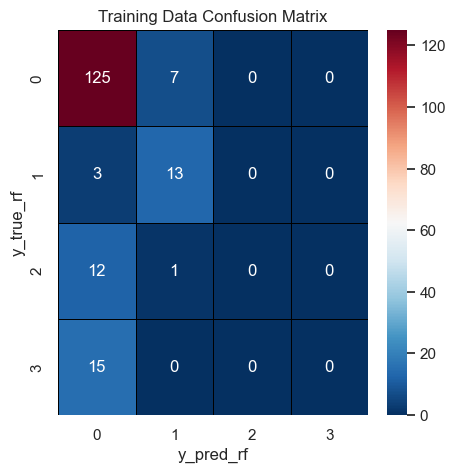

__________________________________________________
--------------------------------------------------
Results for: 0.4
              precision    recall  f1-score   support

           0       0.81      0.95      0.87       132
           1       0.62      0.81      0.70        16
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00        15

    accuracy                           0.78       176
   macro avg       0.36      0.44      0.39       176
weighted avg       0.66      0.78      0.72       176

Training Accuracy: 0.7841
Training Recall: 0.8125


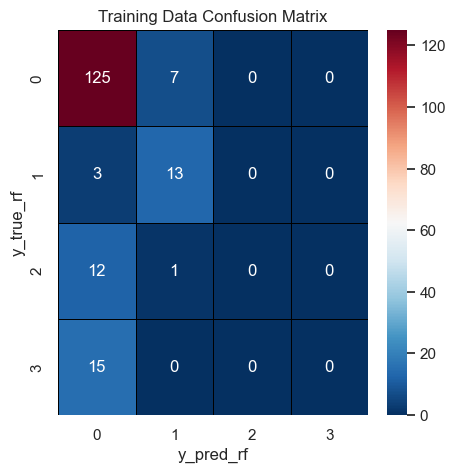

__________________________________________________
--------------------------------------------------
Results for: 0.45
              precision    recall  f1-score   support

           0       0.81      0.95      0.87       132
           1       0.62      0.81      0.70        16
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00        15

    accuracy                           0.78       176
   macro avg       0.36      0.44      0.39       176
weighted avg       0.66      0.78      0.72       176

Training Accuracy: 0.7841
Training Recall: 0.8125


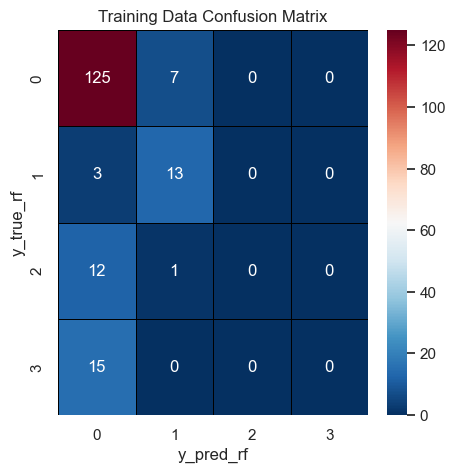

__________________________________________________
--------------------------------------------------
Results for: 0.5
              precision    recall  f1-score   support

           0       0.80      0.95      0.87       132
           1       0.61      0.69      0.65        16
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00        15

    accuracy                           0.78       176
   macro avg       0.35      0.41      0.38       176
weighted avg       0.65      0.78      0.71       176

Training Accuracy: 0.7784
Training Recall: 0.6875


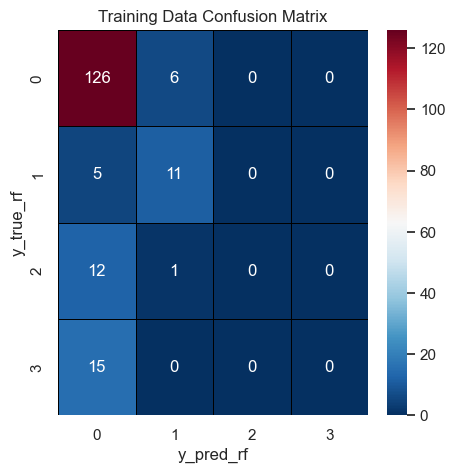

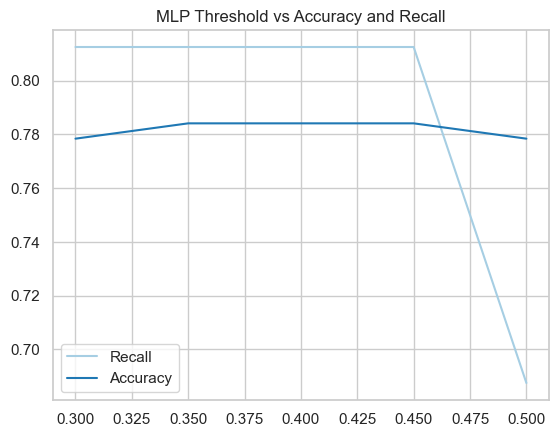

In [397]:
#thresholds
thresh = [0.3,0.35,0.4,0.45,0.5]

accuracy=[]
recall=[]

# Using the MLP GSCV Recall Optimized Model
for t in thresh:
    print('_' * 50)
    print('-' * 50)
    y_pred_thresh = (gscv_MLP_recall.predict_proba(mlp_train_data)[:,1] >= t).astype(bool)
    classification_results(mlp_train_data,y_train['target'],y_pred_thresh,gscv_MLP_recall, title=t)

    accuracy.append(round(classification_report(y_train['target'], y_pred_thresh, output_dict=True)['accuracy'],4))
    recall.append(round(classification_report(y_train['target'], y_pred_thresh, output_dict=True)['1']['recall'],4))
    

plt.plot(thresh,recall, label="Recall")
plt.plot(thresh,accuracy, label = 'Accuracy')
plt.title("MLP Threshold vs Accuracy and Recall")
plt.legend()
plt.show()   

Results for: MLP Recall Optimized Model
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.74        76
   macro avg       0.18      0.25      0.21        76
weighted avg       0.54      0.74      0.63        76

Training Accuracy: 0.7368
Training Recall: 0.0


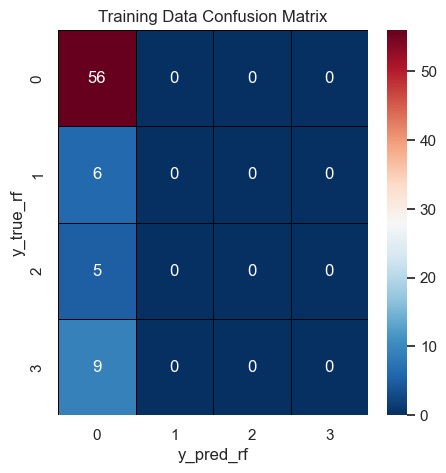

In [420]:
my_thresh = 0.4

y_pred_test_thresh = (gscv_MLP_accuracy.predict_proba(mlp_test_data)[:,1] >= my_thresh).astype(bool)

final_mlp = classification_results(mlp_test_data,y_test['target'],y_pred_test_thresh,gscv_MLP_accuracy, title="MLP Recall Optimized Model")


In [345]:
topologicalFeaturesComplete(pd.DataFrame(x_train),y_train["mortalité à un an"],test=[])

LogisticRegression  KNeighborsClassifier     SVC  \
bottleneck                     0.7898                0.7955  0.7841   
wasserstein                    0.7898                0.8352  0.7841   
landscape                      0.7898                0.8011  0.7784   
betti                          0.7557                0.7784  0.7500   
heat                           0.7614                0.7841  0.7784   
silhouette                     0.7841                0.8295  0.7784   
persistence_image              0.7500                0.7500  0.7500   
entropy                        0.7670                0.8239  0.7500   

                   MLPClassifier  GaussianNB  DecisionTreeClassifier  \
bottleneck                0.7898      0.7898                  0.9205   
wasserstein               0.7898      0.7898                  1.0000   
landscape                 0.7898      0.7898                  0.8807   
betti                     0.7500      0.7727                  0.8693   
heat                      0.7614      0.7614                  0.7841   
silhouette                0.7898      0.7955                  0.9205   
persistence_image         0.7500      0.7500                  0.7500   
entropy                   0.7500      0.7670                  1.0000   

                   RandomForestClassifier  
bottleneck                         0.9205  
wasserstein                        1.0000  
landscape                          0.8807  
betti                              0.8693  
heat                               0.7841  
silhouette                         0.9205  
persistence_image                  0.7500  
entropy                            1.0000

In [410]:
#Best result with KNeighborsClassifier,LogisticRegression,GaussianNB,SVC,, MLP and and KNeighborsClassifier
#SVC
knn_train_data=tda_tranform(['wasserstein','landscape','silhouette'],x_train.to_numpy())
knn_test_data=tda_tranform(['wasserstein','landscape','silhouette'],x_test.to_numpy())


In [418]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],  # L1 and L2 distances
    'leaf_size': [10, 20, 30],  # Additional parameter: leaf_size
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']  # Additional parameter: algorithm
}

# Initialize the KNN classifier
knn = KNeighborsClassifier()

# Initialize GridSearchCV
knn_grid_search_accuracy = GridSearchCV(knn, param_grid, cv=3, scoring='accuracy')
knn_grid_search_accuracy.fit(knn_train_data,y_train["mortalité à un an"])
print(knn_grid_search_accuracy.best_estimator_)
print(knn_grid_search_accuracy.best_params_)

KNeighborsClassifier(leaf_size=10, n_neighbors=7)
{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}


Results for Accuracy Optimized Multi-Layer Perceptron GSCV
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       132
           1       0.71      0.50      0.59        44

    accuracy                           0.82       176
   macro avg       0.78      0.72      0.74       176
weighted avg       0.81      0.82      0.81       176

Training Accuracy: 0.8239
Training Recall: 0.5


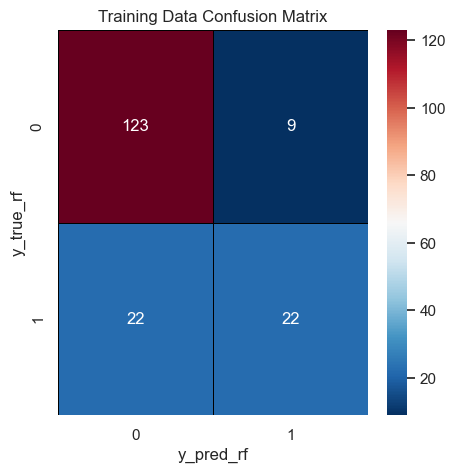

In [419]:
y_pred_accuracy = knn_grid_search_accuracy.predict(knn_train_data)

print("Results for Accuracy Optimized Multi-Layer Perceptron GSCV")
classification_results(knn_train_data,y_train["mortalité à un an"],y_pred_accuracy,knn_grid_search_accuracy)

In [331]:
X_new = x_train.to_numpy()
X_new = X_new.reshape(X_new.shape[0],X_new.shape[1],1)

In [332]:
X_new.shape

(176, 40, 1)

In [333]:
X_train_tda1 = tda_union.fit_transform(X_new)
X_train_tda1.shape

(176, 24)

In [334]:
X_new_test = x_test.to_numpy()
X_new_test = X_new_test.reshape(X_new_test.shape[0],X_new_test.shape[1],1)

In [335]:
X_test_tda1 = tda_union.transform(X_new_test)

__________________________________________________
--------------------------------------------------
Results for: LogisticRegression
              precision    recall  f1-score   support

           0       0.78      0.98      0.87       132
           1       0.50      0.19      0.27        16
           2       1.00      0.08      0.14        13
           3       1.00      0.13      0.24        15

    accuracy                           0.77       176
   macro avg       0.82      0.35      0.38       176
weighted avg       0.79      0.77      0.71       176

Training Accuracy: 0.7727
Training Recall: 0.1875


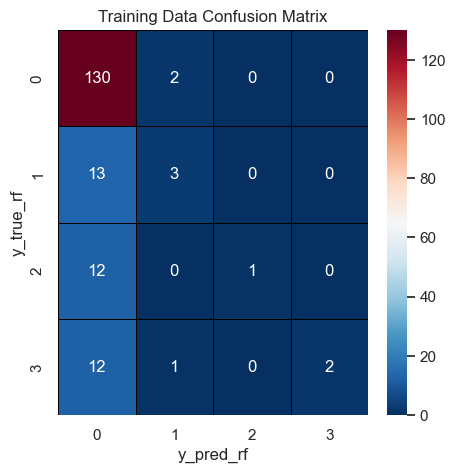

__________________________________________________
--------------------------------------------------
Results for: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.79      0.96      0.87       132
           1       0.44      0.25      0.32        16
           2       1.00      0.08      0.14        13
           3       0.40      0.13      0.20        15

    accuracy                           0.76       176
   macro avg       0.66      0.36      0.38       176
weighted avg       0.74      0.76      0.71       176

Training Accuracy: 0.7614
Training Recall: 0.25


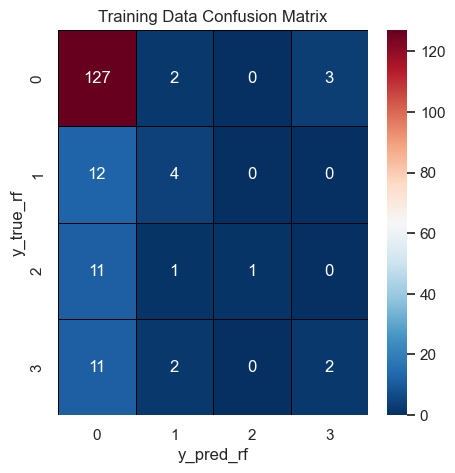

__________________________________________________
--------------------------------------------------
Results for: SVC
              precision    recall  f1-score   support

           0       0.77      1.00      0.87       132
           1       1.00      0.12      0.22        16
           2       1.00      0.08      0.14        13
           3       1.00      0.13      0.24        15

    accuracy                           0.78       176
   macro avg       0.94      0.33      0.37       176
weighted avg       0.83      0.78      0.70       176

Training Accuracy: 0.7784
Training Recall: 0.125


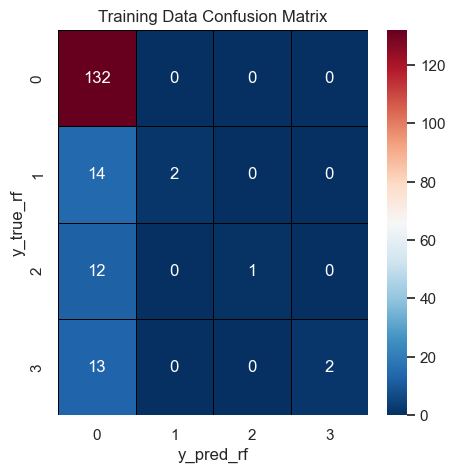

__________________________________________________
--------------------------------------------------
Results for: MLPClassifier
              precision    recall  f1-score   support

           0       0.78      0.98      0.87       132
           1       0.57      0.25      0.35        16
           2       1.00      0.08      0.14        13
           3       1.00      0.13      0.24        15

    accuracy                           0.78       176
   macro avg       0.84      0.36      0.40       176
weighted avg       0.80      0.78      0.72       176

Training Accuracy: 0.7784
Training Recall: 0.25


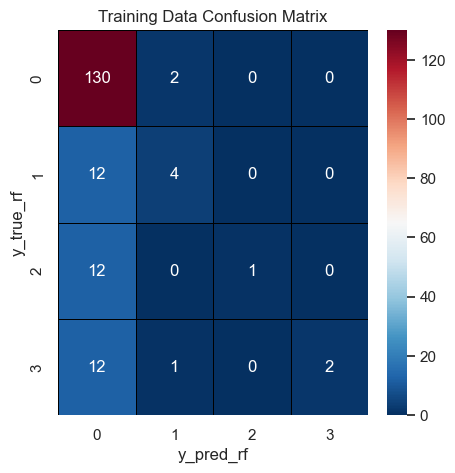

__________________________________________________
--------------------------------------------------
Results for: GaussianNB
              precision    recall  f1-score   support

           0       0.80      0.97      0.87       132
           1       0.40      0.25      0.31        16
           2       0.00      0.00      0.00        13
           3       0.40      0.13      0.20        15

    accuracy                           0.76       176
   macro avg       0.40      0.34      0.35       176
weighted avg       0.67      0.76      0.70       176

Training Accuracy: 0.7614
Training Recall: 0.25


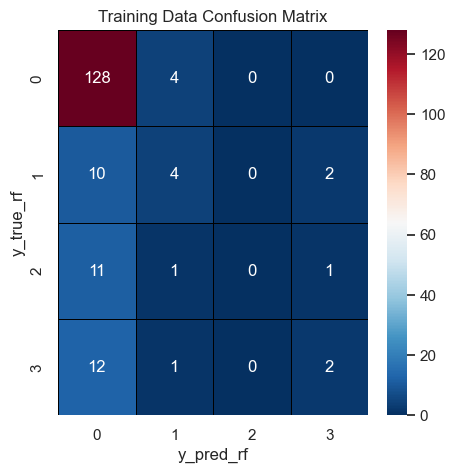

__________________________________________________
--------------------------------------------------
Results for: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       132
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00        15

    accuracy                           1.00       176
   macro avg       1.00      1.00      1.00       176
weighted avg       1.00      1.00      1.00       176

Training Accuracy: 1.0
Training Recall: 1.0


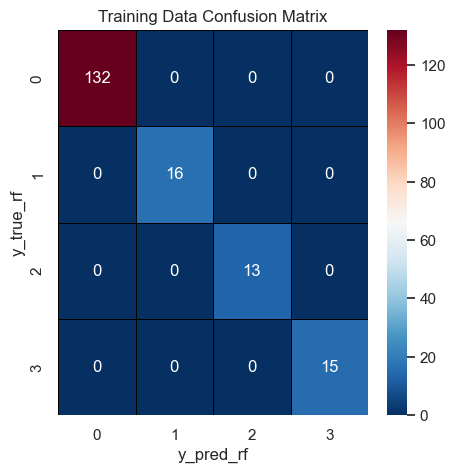

__________________________________________________
--------------------------------------------------
Results for: RandomForestClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       132
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00        15

    accuracy                           1.00       176
   macro avg       1.00      1.00      1.00       176
weighted avg       1.00      1.00      1.00       176

Training Accuracy: 1.0
Training Recall: 1.0


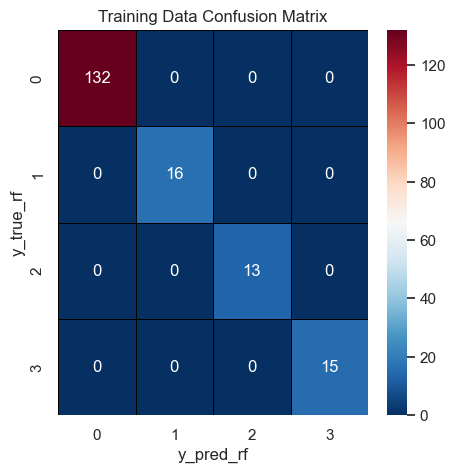

LogisticRegression  KNeighborsClassifier     SVC  MLPClassifier  \
0              0.7727                0.7614  0.7784         0.7784   

   GaussianNB  DecisionTreeClassifier  RandomForestClassifier  
0      0.7614                     1.0                     1.0

In [336]:
showResult(classifiers,X_train_tda1,y_train['target'])

__________________________________________________
--------------------------------------------------
Results for LogisticRegression:
              precision    recall  f1-score   support

           0       0.73      0.96      0.83        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.71        76
   macro avg       0.18      0.24      0.21        76
weighted avg       0.54      0.71      0.61        76

Test Accuracy: 71.05%


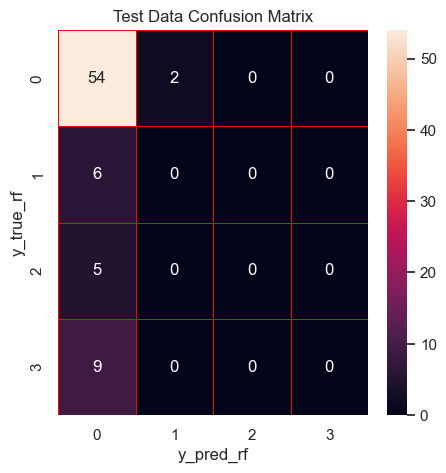

__________________________________________________
--------------------------------------------------
Results for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.75      1.00      0.85        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.74        76
   macro avg       0.19      0.25      0.21        76
weighted avg       0.55      0.74      0.63        76

Test Accuracy: 73.68%


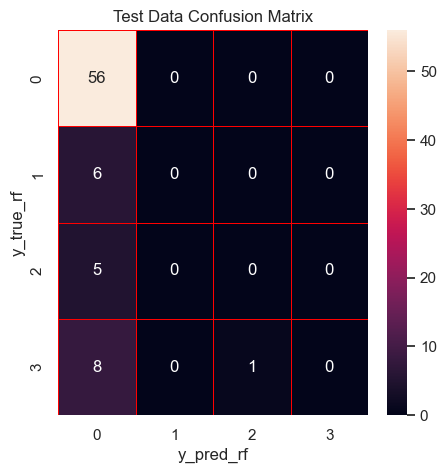

__________________________________________________
--------------------------------------------------
Results for SVC:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.74        76
   macro avg       0.18      0.25      0.21        76
weighted avg       0.54      0.74      0.63        76

Test Accuracy: 73.68%


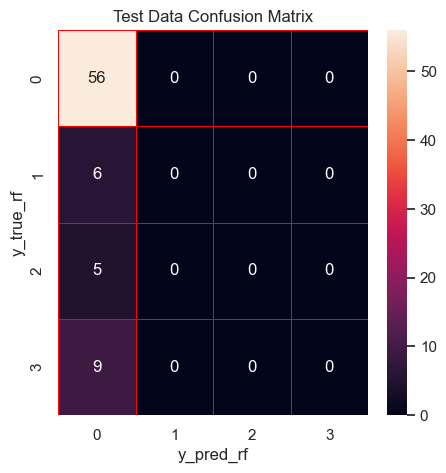

__________________________________________________
--------------------------------------------------
Results for MLPClassifier:
              precision    recall  f1-score   support

           0       0.73      0.96      0.83        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.71        76
   macro avg       0.18      0.24      0.21        76
weighted avg       0.54      0.71      0.61        76

Test Accuracy: 71.05%


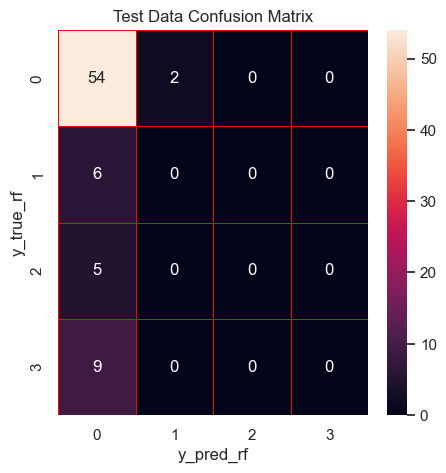

__________________________________________________
--------------------------------------------------
Results for GaussianNB:
              precision    recall  f1-score   support

           0       0.74      0.95      0.83        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.70        76
   macro avg       0.18      0.24      0.21        76
weighted avg       0.54      0.70      0.61        76

Test Accuracy: 69.74%


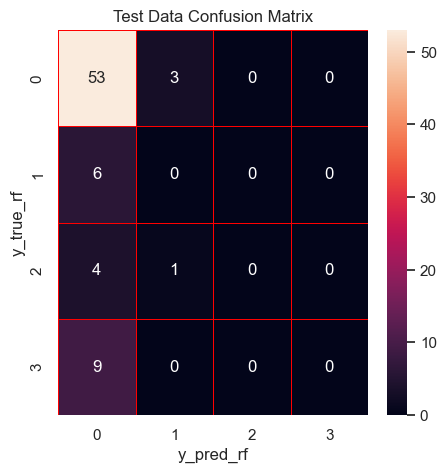

__________________________________________________
--------------------------------------------------
Results for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.74      0.86      0.79        56
           1       0.00      0.00      0.00         6
           2       0.50      0.20      0.29         5
           3       0.33      0.22      0.27         9

    accuracy                           0.67        76
   macro avg       0.39      0.32      0.34        76
weighted avg       0.62      0.67      0.63        76

Test Accuracy: 67.11%


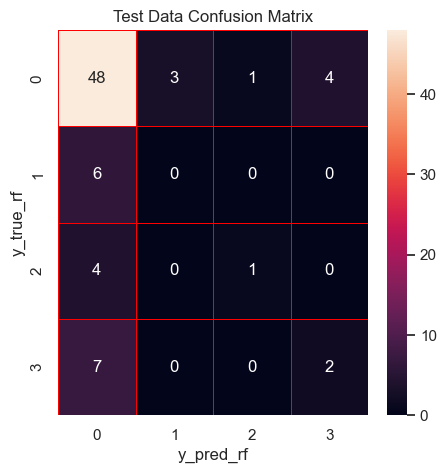

__________________________________________________
--------------------------------------------------
Results for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.76      0.96      0.85        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.71        76
   macro avg       0.19      0.24      0.21        76
weighted avg       0.56      0.71      0.63        76

Test Accuracy: 71.05%


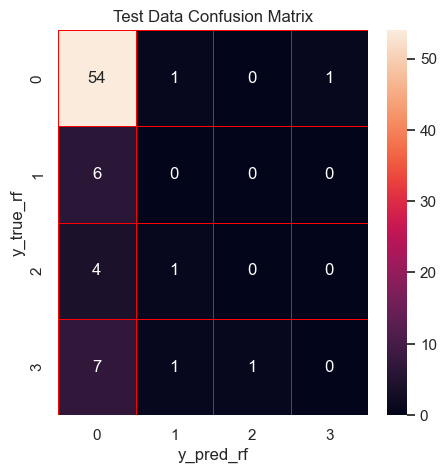

LogisticRegression  KNeighborsClassifier     SVC  MLPClassifier  \
0              0.7105                0.7368  0.7368         0.7105   

   GaussianNB  DecisionTreeClassifier  RandomForestClassifier  
0      0.6974                  0.6711                  0.7105

In [337]:
showResult(classifiers,X_train_tda1,y_train['target'],test=[X_test_tda1,y_test["target"]])

__________________________________________________
--------------------------------------------------
Results for: LogisticRegression
              precision    recall  f1-score   support

           0       0.79      0.96      0.87       132
           1       0.67      0.23      0.34        44

    accuracy                           0.78       176
   macro avg       0.73      0.59      0.60       176
weighted avg       0.76      0.78      0.73       176

Training Accuracy: 0.7784
Training Recall: 0.2273


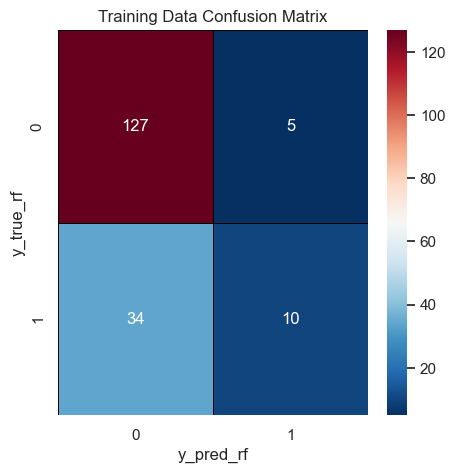

__________________________________________________
--------------------------------------------------
Results for: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       132
           1       0.65      0.45      0.53        44

    accuracy                           0.80       176
   macro avg       0.74      0.69      0.70       176
weighted avg       0.79      0.80      0.79       176

Training Accuracy: 0.8011
Training Recall: 0.4545


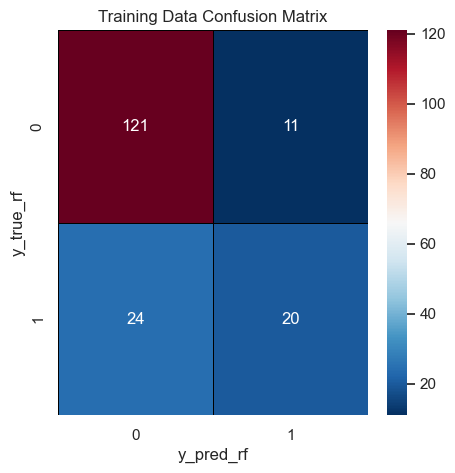

__________________________________________________
--------------------------------------------------
Results for: SVC
              precision    recall  f1-score   support

           0       0.77      1.00      0.87       132
           1       1.00      0.11      0.20        44

    accuracy                           0.78       176
   macro avg       0.89      0.56      0.54       176
weighted avg       0.83      0.78      0.70       176

Training Accuracy: 0.7784
Training Recall: 0.1136


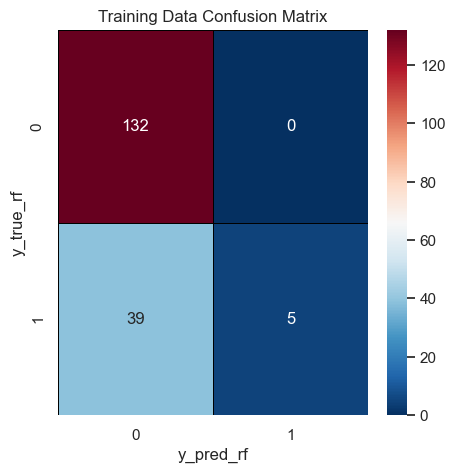

__________________________________________________
--------------------------------------------------
Results for: MLPClassifier
              precision    recall  f1-score   support

           0       0.79      0.96      0.87       132
           1       0.69      0.25      0.37        44

    accuracy                           0.78       176
   macro avg       0.74      0.61      0.62       176
weighted avg       0.77      0.78      0.74       176

Training Accuracy: 0.7841
Training Recall: 0.25


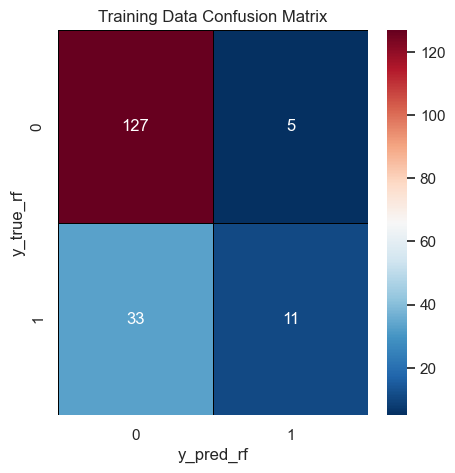

__________________________________________________
--------------------------------------------------
Results for: GaussianNB
              precision    recall  f1-score   support

           0       0.80      0.98      0.88       132
           1       0.79      0.25      0.38        44

    accuracy                           0.80       176
   macro avg       0.79      0.61      0.63       176
weighted avg       0.79      0.80      0.75       176

Training Accuracy: 0.7955
Training Recall: 0.25


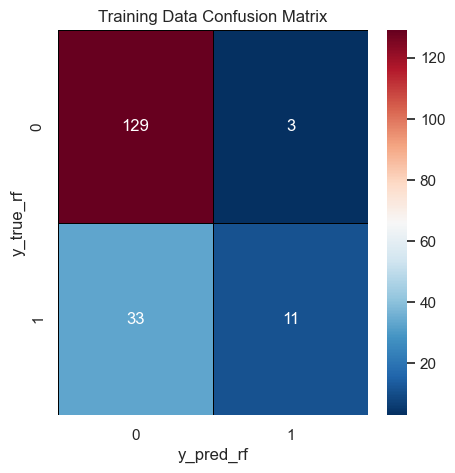

__________________________________________________
--------------------------------------------------
Results for: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       132
           1       1.00      1.00      1.00        44

    accuracy                           1.00       176
   macro avg       1.00      1.00      1.00       176
weighted avg       1.00      1.00      1.00       176

Training Accuracy: 1.0
Training Recall: 1.0


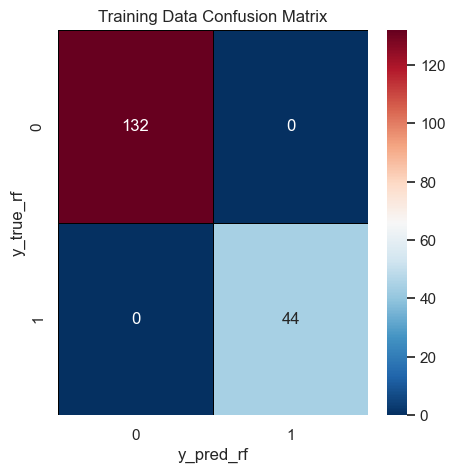

__________________________________________________
--------------------------------------------------
Results for: RandomForestClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       132
           1       1.00      1.00      1.00        44

    accuracy                           1.00       176
   macro avg       1.00      1.00      1.00       176
weighted avg       1.00      1.00      1.00       176

Training Accuracy: 1.0
Training Recall: 1.0


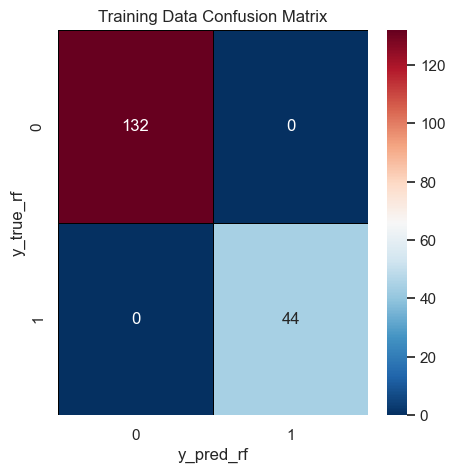

LogisticRegression  KNeighborsClassifier     SVC  MLPClassifier  \
0              0.7784                0.8011  0.7784         0.7841   

   GaussianNB  DecisionTreeClassifier  RandomForestClassifier  
0      0.7955                     1.0                     1.0

In [339]:
showResult(classifiers,X_train_tda1,y_train['mortalité à un an'])

__________________________________________________
--------------------------------------------------
Results for LogisticRegression:
              precision    recall  f1-score   support

           0       0.76      0.96      0.85        57
           1       0.50      0.11      0.17        19

    accuracy                           0.75        76
   macro avg       0.63      0.54      0.51        76
weighted avg       0.70      0.75      0.68        76

Test Accuracy: 75.0%


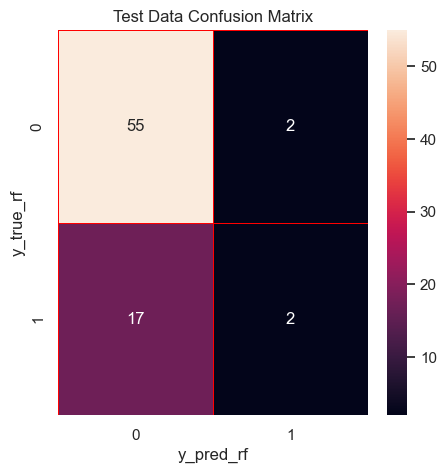

__________________________________________________
--------------------------------------------------
Results for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.77      0.96      0.86        57
           1       0.60      0.16      0.25        19

    accuracy                           0.76        76
   macro avg       0.69      0.56      0.55        76
weighted avg       0.73      0.76      0.71        76

Test Accuracy: 76.32%


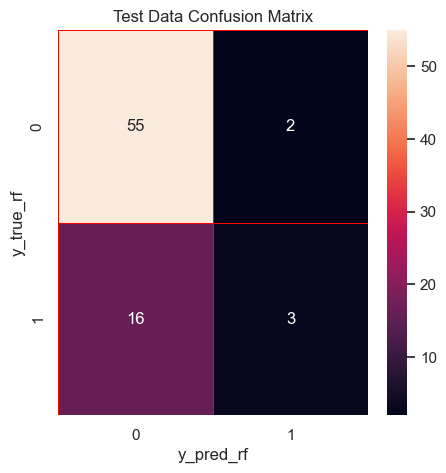

__________________________________________________
--------------------------------------------------
Results for SVC:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        57
           1       0.00      0.00      0.00        19

    accuracy                           0.75        76
   macro avg       0.38      0.50      0.43        76
weighted avg       0.56      0.75      0.64        76

Test Accuracy: 75.0%


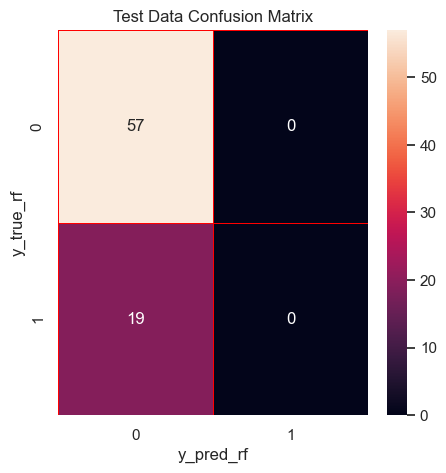

__________________________________________________
--------------------------------------------------
Results for MLPClassifier:
              precision    recall  f1-score   support

           0       0.76      0.96      0.85        57
           1       0.50      0.11      0.17        19

    accuracy                           0.75        76
   macro avg       0.63      0.54      0.51        76
weighted avg       0.70      0.75      0.68        76

Test Accuracy: 75.0%


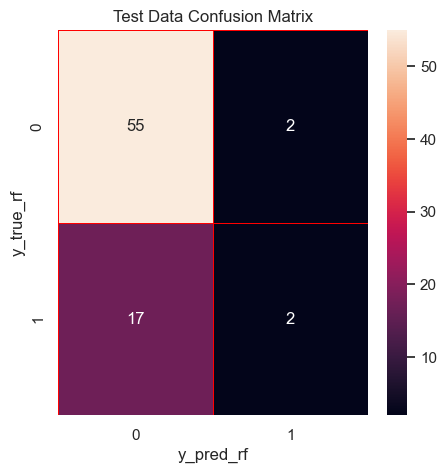

__________________________________________________
--------------------------------------------------
Results for GaussianNB:
              precision    recall  f1-score   support

           0       0.74      0.96      0.84        57
           1       0.00      0.00      0.00        19

    accuracy                           0.72        76
   macro avg       0.37      0.48      0.42        76
weighted avg       0.56      0.72      0.63        76

Test Accuracy: 72.37%


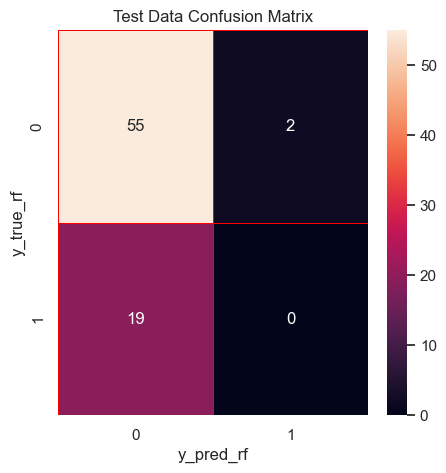

__________________________________________________
--------------------------------------------------
Results for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.77      0.88      0.82        57
           1       0.36      0.21      0.27        19

    accuracy                           0.71        76
   macro avg       0.57      0.54      0.54        76
weighted avg       0.67      0.71      0.68        76

Test Accuracy: 71.05%


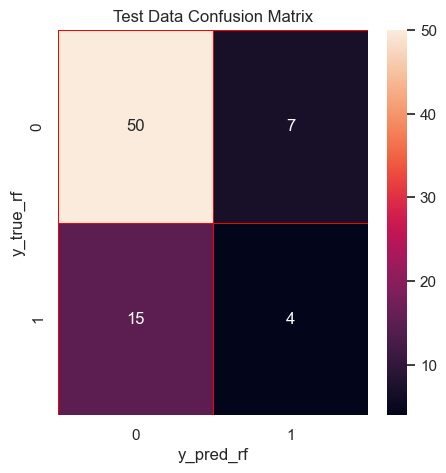

__________________________________________________
--------------------------------------------------
Results for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.78      0.91      0.84        57
           1       0.44      0.21      0.29        19

    accuracy                           0.74        76
   macro avg       0.61      0.56      0.56        76
weighted avg       0.69      0.74      0.70        76

Test Accuracy: 73.68%


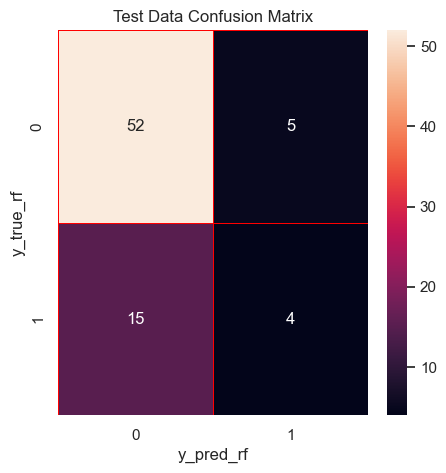

LogisticRegression  KNeighborsClassifier   SVC  MLPClassifier  GaussianNB  \
0                0.75                0.7632  0.75           0.75      0.7237   

   DecisionTreeClassifier  RandomForestClassifier  
0                  0.7105                  0.7368

In [338]:
showResult(classifiers,X_train_tda1,y_train['mortalité à un an'],test=[X_test_tda1,y_test["mortalité à un an"]])

In [125]:
#with pca
X_new = x_train_pca.to_numpy()
X_new = X_new.reshape(X_new.shape[0],X_new.shape[1],1)

In [126]:
X_new_test = x_test_pca.to_numpy()
X_new_test = X_new_test.reshape(X_new_test.shape[0],X_new_test.shape[1],1)

In [127]:
X_train_tda2 = tda_union.transform(X_new)

In [128]:
X_test_tda2 = tda_union.transform(X_new_test)

__________________________________________________
--------------------------------------------------
Results for: LogisticRegression
              precision    recall  f1-score   support

           0       0.78      0.98      0.87       132
           1       0.40      0.12      0.19        16
           2       1.00      0.15      0.27        13
           3       1.00      0.13      0.24        15

    accuracy                           0.77       176
   macro avg       0.79      0.35      0.39       176
weighted avg       0.78      0.77      0.71       176

Training Accuracy: 0.7727
Training Recall: 0.125


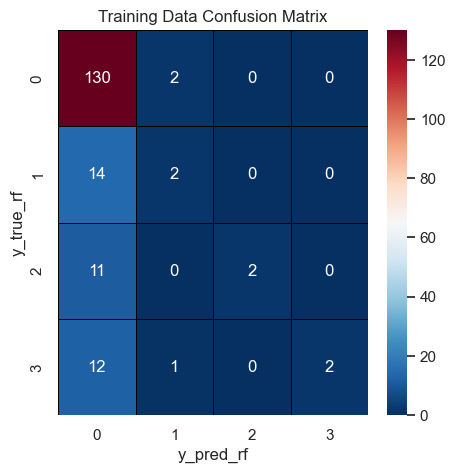

__________________________________________________
--------------------------------------------------
Results for: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.81      0.99      0.89       132
           1       0.43      0.38      0.40        16
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00        15

    accuracy                           0.78       176
   macro avg       0.31      0.34      0.32       176
weighted avg       0.65      0.78      0.70       176

Training Accuracy: 0.7784
Training Recall: 0.375


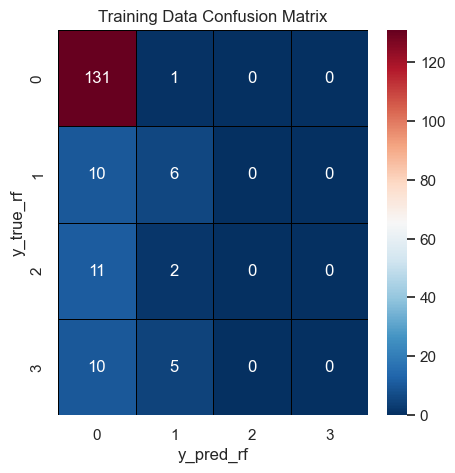

__________________________________________________
--------------------------------------------------
Results for: SVC
              precision    recall  f1-score   support

           0       0.77      1.00      0.87       132
           1       0.67      0.12      0.21        16
           2       0.00      0.00      0.00        13
           3       1.00      0.13      0.24        15

    accuracy                           0.77       176
   macro avg       0.61      0.31      0.33       176
weighted avg       0.72      0.77      0.69       176

Training Accuracy: 0.7727
Training Recall: 0.125


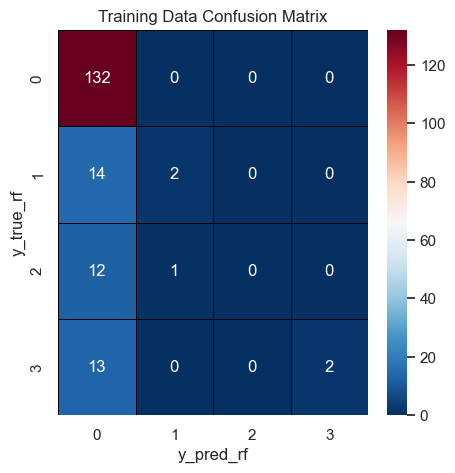

__________________________________________________
--------------------------------------------------
Results for: MLPClassifier
              precision    recall  f1-score   support

           0       0.78      0.99      0.87       132
           1       0.50      0.12      0.20        16
           2       1.00      0.15      0.27        13
           3       1.00      0.13      0.24        15

    accuracy                           0.78       176
   macro avg       0.82      0.35      0.39       176
weighted avg       0.79      0.78      0.71       176

Training Accuracy: 0.7784
Training Recall: 0.125


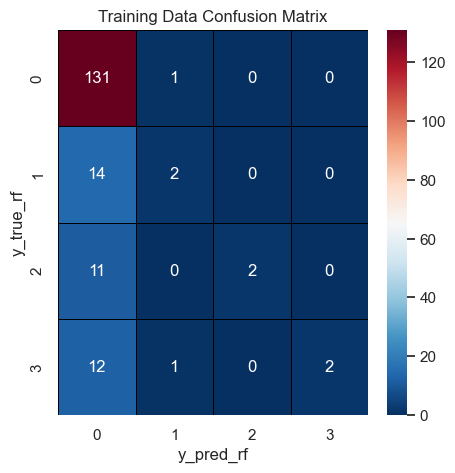

__________________________________________________
--------------------------------------------------
Results for: GaussianNB
              precision    recall  f1-score   support

           0       0.81      0.95      0.88       132
           1       0.31      0.25      0.28        16
           2       0.00      0.00      0.00        13
           3       0.40      0.13      0.20        15

    accuracy                           0.75       176
   macro avg       0.38      0.33      0.34       176
weighted avg       0.67      0.75      0.70       176

Training Accuracy: 0.75
Training Recall: 0.25


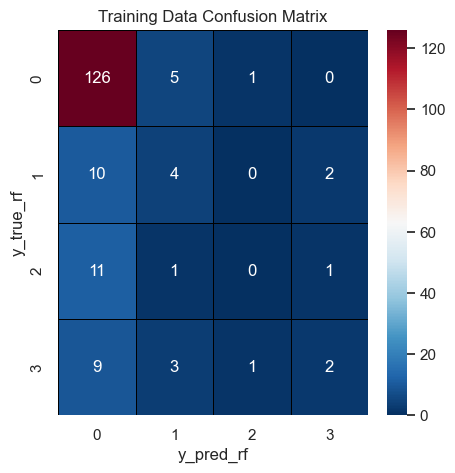

__________________________________________________
--------------------------------------------------
Results for: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       132
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00        15

    accuracy                           1.00       176
   macro avg       1.00      1.00      1.00       176
weighted avg       1.00      1.00      1.00       176

Training Accuracy: 1.0
Training Recall: 1.0


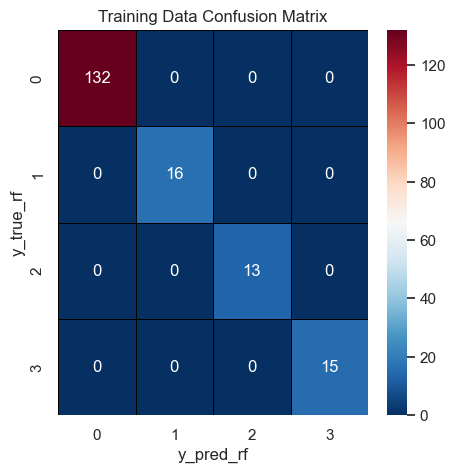

__________________________________________________
--------------------------------------------------
Results for: RandomForestClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       132
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00        15

    accuracy                           1.00       176
   macro avg       1.00      1.00      1.00       176
weighted avg       1.00      1.00      1.00       176

Training Accuracy: 1.0
Training Recall: 1.0


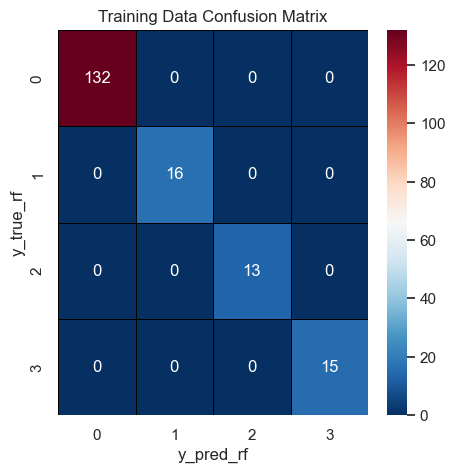

LogisticRegression  KNeighborsClassifier     SVC  MLPClassifier  \
0              0.7727                0.7784  0.7727         0.7784   

   GaussianNB  DecisionTreeClassifier  RandomForestClassifier  
0        0.75                     1.0                     1.0

In [129]:
showResult(classifiers,X_train_tda2,y_train['target'])

__________________________________________________
--------------------------------------------------
Results for LogisticRegression:
              precision    recall  f1-score   support

           0       0.75      0.95      0.83        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.70        76
   macro avg       0.19      0.24      0.21        76
weighted avg       0.55      0.70      0.62        76

Test Accuracy: 69.74%


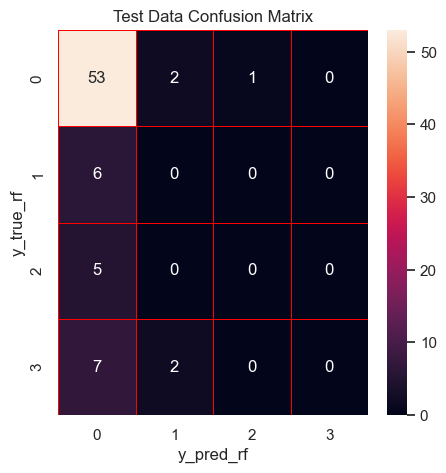

__________________________________________________
--------------------------------------------------
Results for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.75      0.96      0.84        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.71        76
   macro avg       0.19      0.24      0.21        76
weighted avg       0.55      0.71      0.62        76

Test Accuracy: 71.05%


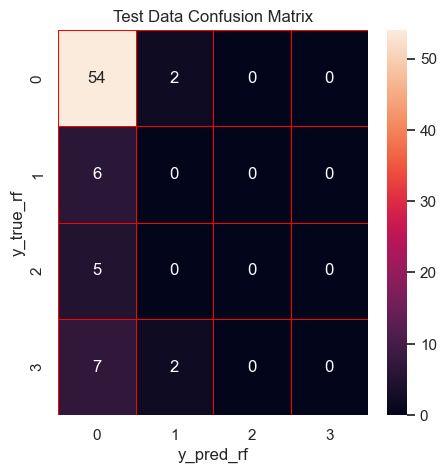

__________________________________________________
--------------------------------------------------
Results for SVC:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.74        76
   macro avg       0.18      0.25      0.21        76
weighted avg       0.54      0.74      0.63        76

Test Accuracy: 73.68%


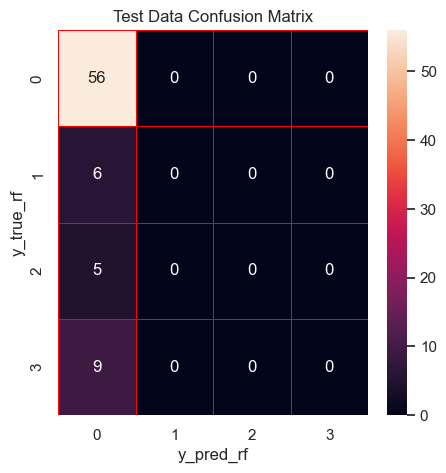

__________________________________________________
--------------------------------------------------
Results for MLPClassifier:
              precision    recall  f1-score   support

           0       0.74      0.95      0.83        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.70        76
   macro avg       0.18      0.24      0.21        76
weighted avg       0.54      0.70      0.61        76

Test Accuracy: 69.74%


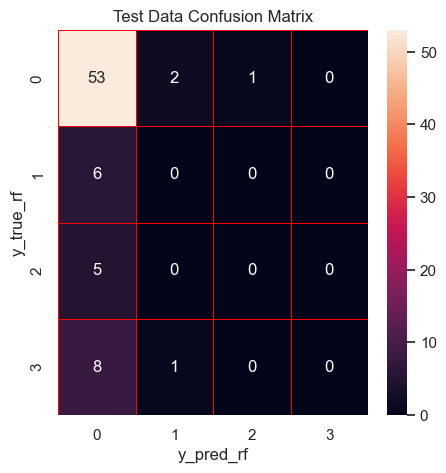

__________________________________________________
--------------------------------------------------
Results for GaussianNB:
              precision    recall  f1-score   support

           0       0.76      0.96      0.85        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.71        76
   macro avg       0.19      0.24      0.21        76
weighted avg       0.56      0.71      0.63        76

Test Accuracy: 71.05%


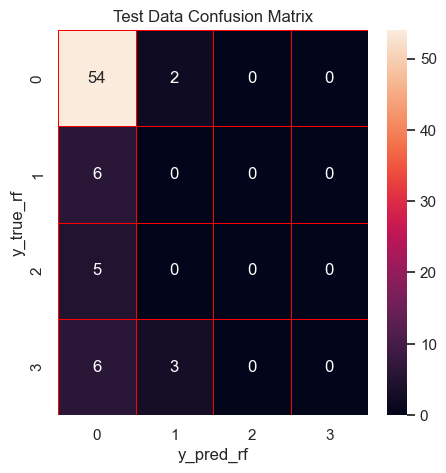

__________________________________________________
--------------------------------------------------
Results for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.74      0.82      0.78        56
           1       0.00      0.00      0.00         6
           2       0.50      0.60      0.55         5
           3       0.00      0.00      0.00         9

    accuracy                           0.64        76
   macro avg       0.31      0.36      0.33        76
weighted avg       0.58      0.64      0.61        76

Test Accuracy: 64.47%


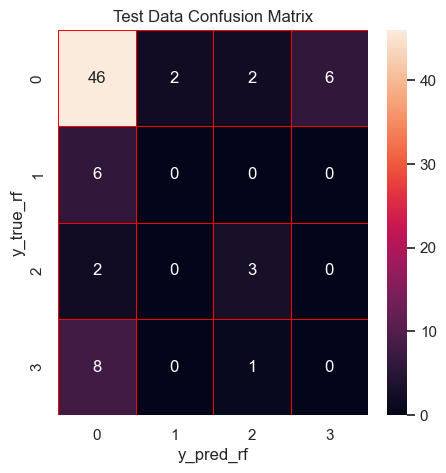

__________________________________________________
--------------------------------------------------
Results for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.75      0.96      0.84        56
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         9

    accuracy                           0.71        76
   macro avg       0.19      0.24      0.21        76
weighted avg       0.55      0.71      0.62        76

Test Accuracy: 71.05%


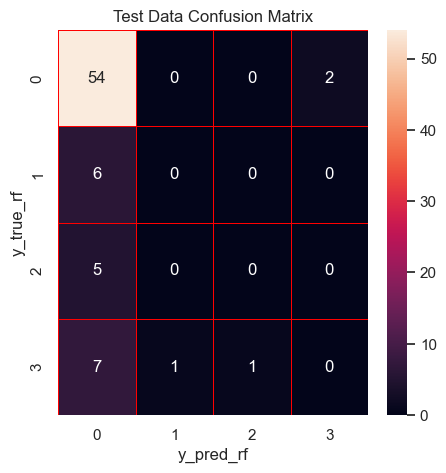

LogisticRegression  KNeighborsClassifier     SVC  MLPClassifier  \
0              0.6974                0.7105  0.7368         0.6974   

   GaussianNB  DecisionTreeClassifier  RandomForestClassifier  
0      0.7105                  0.6447                  0.7105

In [131]:
showResult(classifiers,X_train_tda2,y_train['target'],test=[X_test_tda2,y_test["target"]])

In [116]:
y_train["mortalité à un an"].shape

(176,)

__________________________________________________
--------------------------------------------------
Results for LogisticRegression:
              precision    recall  f1-score   support

           0       0.77      0.95      0.85        57
           1       0.50      0.16      0.24        19

    accuracy                           0.75        76
   macro avg       0.64      0.55      0.55        76
weighted avg       0.70      0.75      0.70        76

Test Accuracy: 75.0%


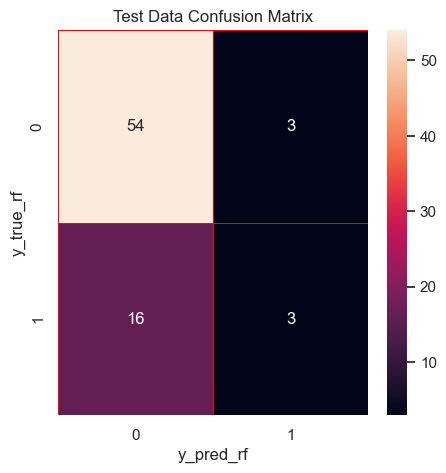

__________________________________________________
--------------------------------------------------
Results for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.76      0.93      0.83        57
           1       0.33      0.11      0.16        19

    accuracy                           0.72        76
   macro avg       0.55      0.52      0.50        76
weighted avg       0.65      0.72      0.67        76

Test Accuracy: 72.37%


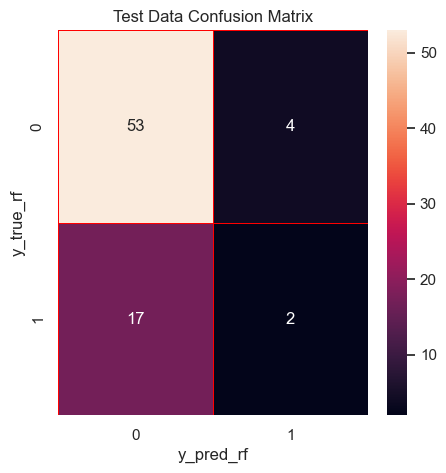

__________________________________________________
--------------------------------------------------
Results for SVC:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        57
           1       0.00      0.00      0.00        19

    accuracy                           0.75        76
   macro avg       0.38      0.50      0.43        76
weighted avg       0.56      0.75      0.64        76

Test Accuracy: 75.0%


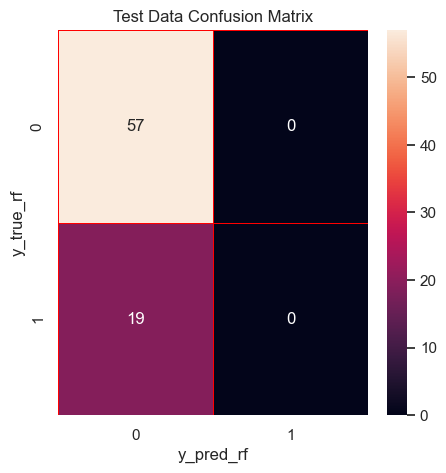

__________________________________________________
--------------------------------------------------
Results for MLPClassifier:
              precision    recall  f1-score   support

           0       0.77      0.96      0.86        57
           1       0.60      0.16      0.25        19

    accuracy                           0.76        76
   macro avg       0.69      0.56      0.55        76
weighted avg       0.73      0.76      0.71        76

Test Accuracy: 76.32%


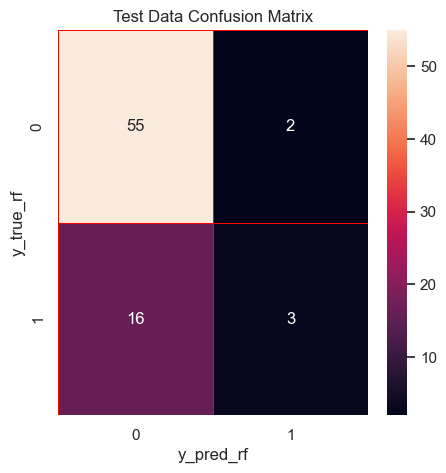

__________________________________________________
--------------------------------------------------
Results for GaussianNB:
              precision    recall  f1-score   support

           0       0.77      0.96      0.86        57
           1       0.60      0.16      0.25        19

    accuracy                           0.76        76
   macro avg       0.69      0.56      0.55        76
weighted avg       0.73      0.76      0.71        76

Test Accuracy: 76.32%


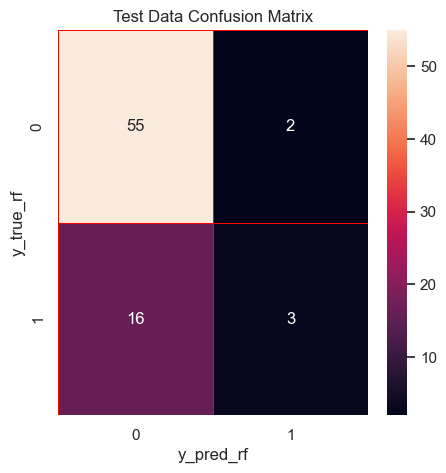

__________________________________________________
--------------------------------------------------
Results for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.78      0.79      0.78        57
           1       0.33      0.32      0.32        19

    accuracy                           0.67        76
   macro avg       0.55      0.55      0.55        76
weighted avg       0.67      0.67      0.67        76

Test Accuracy: 67.11%


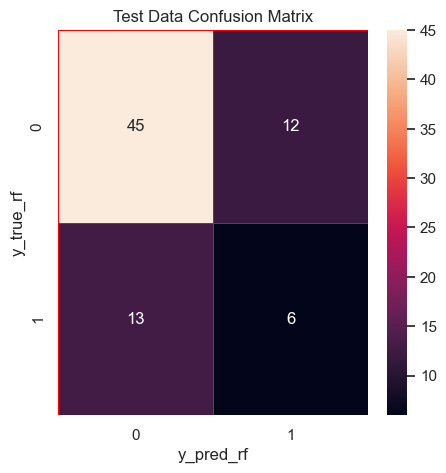

__________________________________________________
--------------------------------------------------
Results for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.77      0.93      0.84        57
           1       0.43      0.16      0.23        19

    accuracy                           0.74        76
   macro avg       0.60      0.54      0.54        76
weighted avg       0.68      0.74      0.69        76

Test Accuracy: 73.68%


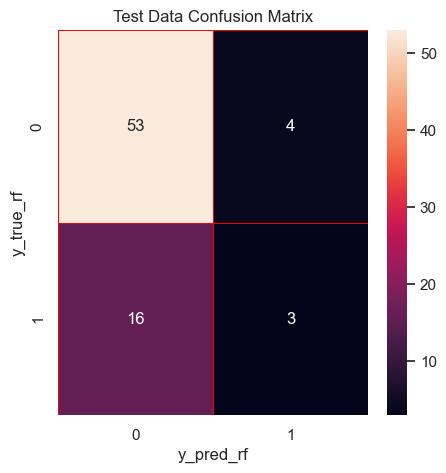

LogisticRegression  KNeighborsClassifier   SVC  MLPClassifier  GaussianNB  \
0                0.75                0.7237  0.75         0.7632      0.7632   

   DecisionTreeClassifier  RandomForestClassifier  
0                  0.6711                  0.7368

In [162]:
showResult(classifiers,X_train_tda2,y_train['mortalité à un an'],test=[X_test_tda2,y_test["mortalité à un an"]])

In [ ]:
#taelcore analysis
#x_train_tael, x_test_tael, y_train_tael, y_test_tael

In [283]:
X_new = x_train_tael
X_new = X_new.reshape(X_new.shape[0],X_new.shape[1],1)

In [284]:
X_new_test = x_test_tael
X_new_test = X_new_test.reshape(X_new_test.shape[0],X_new_test.shape[1],1)

In [285]:
X_train_tda_tael = tda_union.transform(X_new)

In [286]:
X_test_tda_tael = tda_union.transform(X_new_test)

In [299]:
y_train_tael.columns

Index(['mortalité à J30', 'mortalité à 90j', 'mortalité à un an', 'target'], dtype='object')

__________________________________________________
--------------------------------------------------
Results for: LogisticRegression
              precision    recall  f1-score   support

           0       0.80      0.98      0.88       132
           1       0.79      0.25      0.38        44

    accuracy                           0.80       176
   macro avg       0.79      0.61      0.63       176
weighted avg       0.79      0.80      0.75       176

Training Accuracy: 0.7955
Training Recall: 0.25


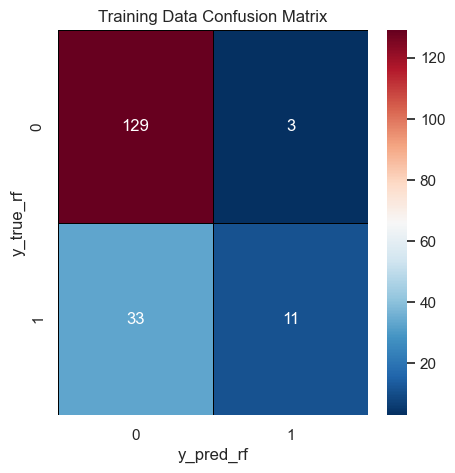

__________________________________________________
--------------------------------------------------
Results for: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.82      0.98      0.89       132
           1       0.83      0.34      0.48        44

    accuracy                           0.82       176
   macro avg       0.82      0.66      0.69       176
weighted avg       0.82      0.82      0.79       176

Training Accuracy: 0.8182
Training Recall: 0.3409


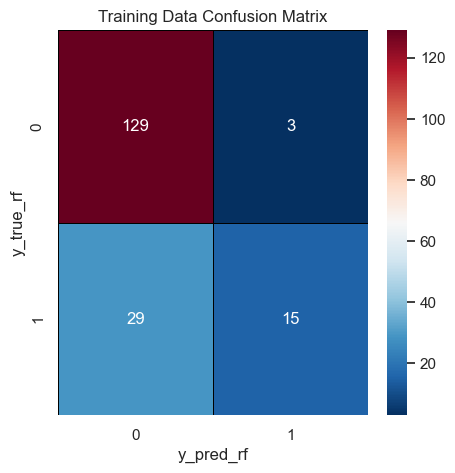

__________________________________________________
--------------------------------------------------
Results for: SVC
              precision    recall  f1-score   support

           0       0.78      1.00      0.87       132
           1       1.00      0.14      0.24        44

    accuracy                           0.78       176
   macro avg       0.89      0.57      0.56       176
weighted avg       0.83      0.78      0.72       176

Training Accuracy: 0.7841
Training Recall: 0.1364


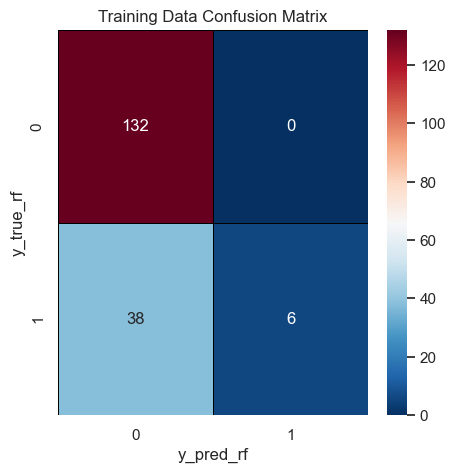

__________________________________________________
--------------------------------------------------
Results for: MLPClassifier
              precision    recall  f1-score   support

           0       0.80      0.98      0.88       132
           1       0.79      0.25      0.38        44

    accuracy                           0.80       176
   macro avg       0.79      0.61      0.63       176
weighted avg       0.79      0.80      0.75       176

Training Accuracy: 0.7955
Training Recall: 0.25


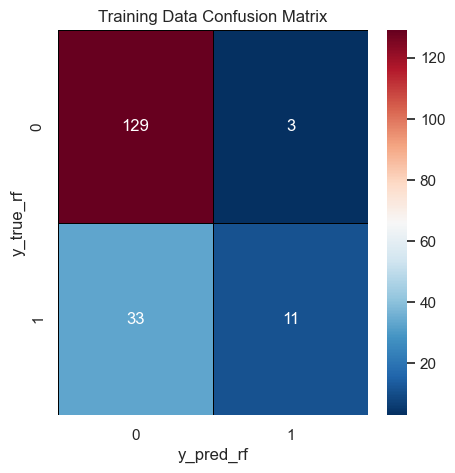

__________________________________________________
--------------------------------------------------
Results for: GaussianNB
              precision    recall  f1-score   support

           0       0.80      0.95      0.87       132
           1       0.63      0.27      0.38        44

    accuracy                           0.78       176
   macro avg       0.71      0.61      0.62       176
weighted avg       0.76      0.78      0.74       176

Training Accuracy: 0.7784
Training Recall: 0.2727


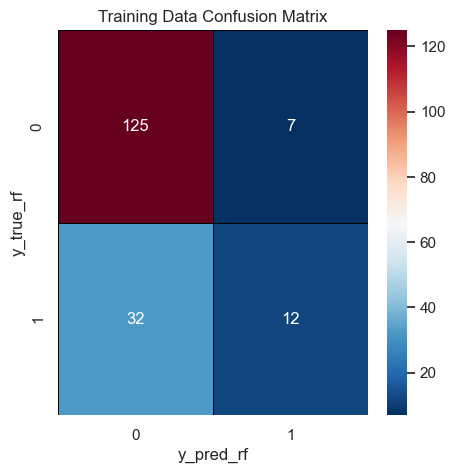

__________________________________________________
--------------------------------------------------
Results for: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       132
           1       1.00      1.00      1.00        44

    accuracy                           1.00       176
   macro avg       1.00      1.00      1.00       176
weighted avg       1.00      1.00      1.00       176

Training Accuracy: 1.0
Training Recall: 1.0


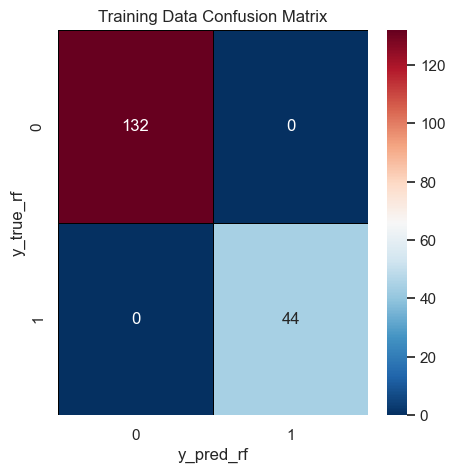

__________________________________________________
--------------------------------------------------
Results for: RandomForestClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       132
           1       1.00      1.00      1.00        44

    accuracy                           1.00       176
   macro avg       1.00      1.00      1.00       176
weighted avg       1.00      1.00      1.00       176

Training Accuracy: 1.0
Training Recall: 1.0


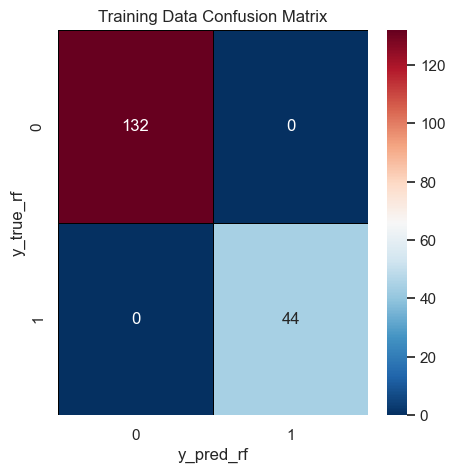

LogisticRegression  KNeighborsClassifier     SVC  MLPClassifier  \
0              0.7955                0.8182  0.7841         0.7955   

   GaussianNB  DecisionTreeClassifier  RandomForestClassifier  
0      0.7784                     1.0                     1.0

In [300]:
showResult(classifiers,X_train_tda_tael,y_train_tael["mortalité à un an"])

__________________________________________________
--------------------------------------------------
Results for LogisticRegression:
              precision    recall  f1-score   support

           0       0.77      0.95      0.85        57
           1       0.50      0.16      0.24        19

    accuracy                           0.75        76
   macro avg       0.64      0.55      0.55        76
weighted avg       0.70      0.75      0.70        76

Test Accuracy: 75.0%


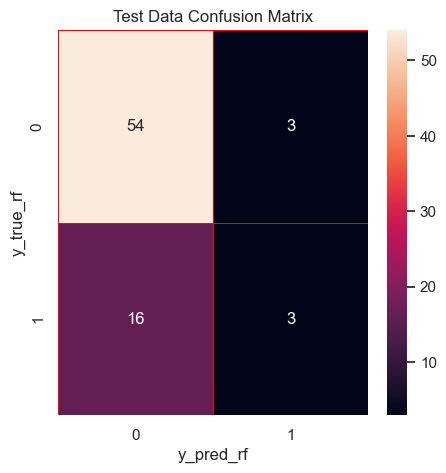

__________________________________________________
--------------------------------------------------
Results for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.80      0.93      0.86        57
           1       0.60      0.32      0.41        19

    accuracy                           0.78        76
   macro avg       0.70      0.62      0.64        76
weighted avg       0.75      0.78      0.75        76

Test Accuracy: 77.63%


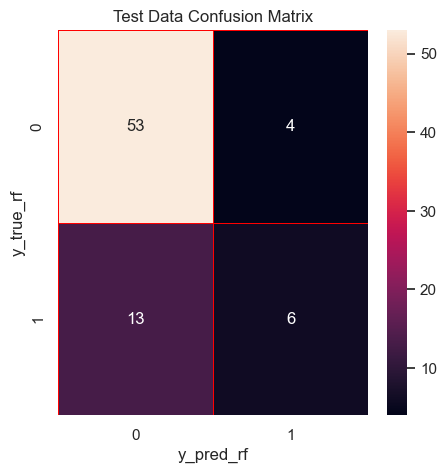

__________________________________________________
--------------------------------------------------
Results for SVC:
              precision    recall  f1-score   support

           0       0.74      0.96      0.84        57
           1       0.00      0.00      0.00        19

    accuracy                           0.72        76
   macro avg       0.37      0.48      0.42        76
weighted avg       0.56      0.72      0.63        76

Test Accuracy: 72.37%


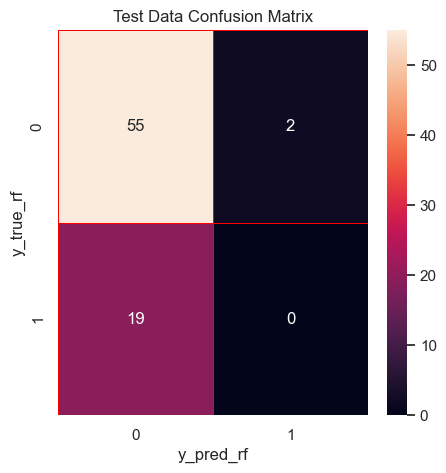

__________________________________________________
--------------------------------------------------
Results for MLPClassifier:
              precision    recall  f1-score   support

           0       0.77      0.95      0.85        57
           1       0.50      0.16      0.24        19

    accuracy                           0.75        76
   macro avg       0.64      0.55      0.55        76
weighted avg       0.70      0.75      0.70        76

Test Accuracy: 75.0%


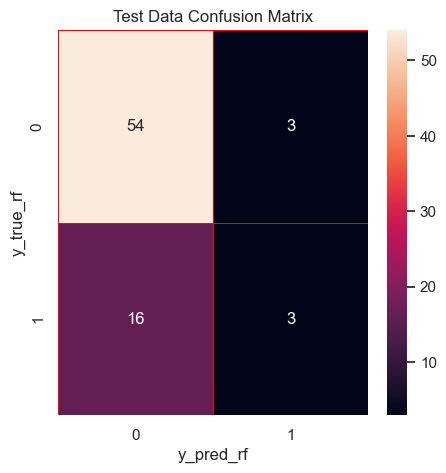

__________________________________________________
--------------------------------------------------
Results for GaussianNB:
              precision    recall  f1-score   support

           0       0.79      0.93      0.85        57
           1       0.56      0.26      0.36        19

    accuracy                           0.76        76
   macro avg       0.67      0.60      0.61        76
weighted avg       0.73      0.76      0.73        76

Test Accuracy: 76.32%


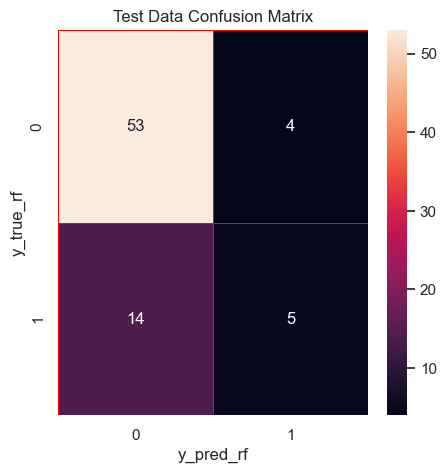

__________________________________________________
--------------------------------------------------
Results for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.81      0.95      0.87        57
           1       0.67      0.32      0.43        19

    accuracy                           0.79        76
   macro avg       0.74      0.63      0.65        76
weighted avg       0.77      0.79      0.76        76

Test Accuracy: 78.95%


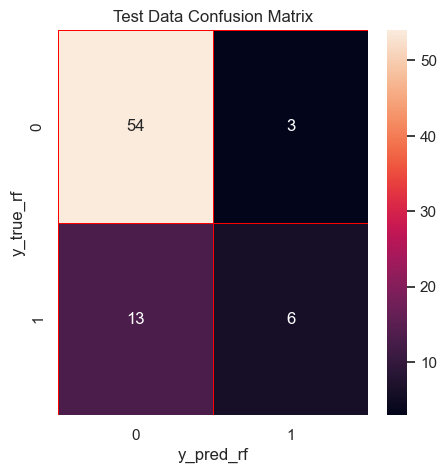

__________________________________________________
--------------------------------------------------
Results for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        57
           1       0.50      0.21      0.30        19

    accuracy                           0.75        76
   macro avg       0.64      0.57      0.57        76
weighted avg       0.71      0.75      0.71        76

Test Accuracy: 75.0%


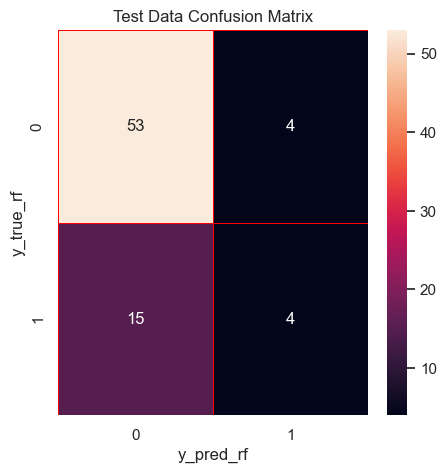

LogisticRegression  KNeighborsClassifier     SVC  MLPClassifier  \
0                0.75                0.7763  0.7237           0.75   

   GaussianNB  DecisionTreeClassifier  RandomForestClassifier  
0      0.7632                  0.7895                    0.75

In [306]:
showResult(classifiers,X_train_tda_tael,y_train_tael["mortalité à un an"],test=[X_test_tda_tael,y_test_tael["mortalité à un an"]])

# Model Tuning - MLP# 

In [304]:
### Changing the test variable to a tuple of the test data allows one to train
# test the data in one line. Changing model_out to True returns the fit model

RFmod = classification(RandomForestClassifier,X_train_tda_tael,y_train_tael["mortalité à un an"], model_out=True,
                        random_state = 7, results=False)
# print('_' * 50)
# print('-' * 50)
MLPmod = classification(MLPClassifier,X_train_tda_tael,y_train_tael["mortalité à un an"], model_out=True,
                        random_state = 7, results=False)
# print('_' * 50)
# print('-' * 50)
Logmod = classification(LogisticRegression,X_train_tda_tael,y_train_tael["mortalité à un an"], model_out=True,
                        random_state = 7, results=False)

SVCmod = classification(SVC,X_train_tda_tael,y_train_tael["mortalité à un an"], model_out=True,
                        random_state = 7, results=False)

# Constructing these models in case we want them later

In [277]:
### Changing the test variable to a tuple of the test data allows one to train
# test the data in one line. Changing model_out to True returns the fit model

RFmod = classification(RandomForestClassifier,X_train_tda1,y_train["mortalité à un an"], model_out=True,
                        random_state = 7, results=False)
# print('_' * 50)
# print('-' * 50)
MLPmod = classification(MLPClassifier,X_train_tda1,y_train["mortalité à un an"], model_out=True,
                        random_state = 7, results=False)
# print('_' * 50)
# print('-' * 50)
Logmod = classification(LogisticRegression,X_train_tda1,y_train["mortalité à un an"], model_out=True,
                        random_state = 7, results=False)

SVCmod = classification(SVC,X_train_tda1,y_train["mortalité à un an"], model_out=True,
                        random_state = 7, results=False)

# Constructing these models in case we want them later

# Cross Validation

In [305]:
print("Random Forest cross val score accuracy is:", np.mean(cross_val_score(RFmod, X_test_tda_tael, y_test_tael["mortalité à un an"], cv = 5)).round(5))
print("MLP cross val score accuracy is:", np.mean(cross_val_score(MLPmod, X_test_tda_tael, y_test_tael["mortalité à un an"], cv = 5)).round(5))
print("Logistic Regression cross val score accuracy is:", np.mean(cross_val_score(Logmod, X_test_tda_tael, y_test_tael["mortalité à un an"], cv = 5)).round(5))
print("Support vector machine cross val score accuracy is:", np.mean(cross_val_score(SVCmod, X_test_tda_tael, y_test_tael["mortalité à un an"], cv = 5)).round(5))

Random Forest cross val score accuracy is: 0.7875
MLP cross val score accuracy is: 0.7225
Logistic Regression cross val score accuracy is: 0.71
Support vector machine cross val score accuracy is: 0.72333


In [278]:
print("Random Forest cross val score accuracy is:", np.mean(cross_val_score(RFmod, X_test_tda1, y_test["mortalité à un an"], cv = 5)).round(5))
print("MLP cross val score accuracy is:", np.mean(cross_val_score(MLPmod, X_test_tda1, y_test["mortalité à un an"], cv = 5)).round(5))
print("Logistic Regression cross val score accuracy is:", np.mean(cross_val_score(Logmod, X_test_tda1, y_test["mortalité à un an"], cv = 5)).round(5))
print("Support vector machine cross val score accuracy is:", np.mean(cross_val_score(SVCmod, X_test_tda1, y_test["mortalité à un an"], cv = 5)).round(5))

Random Forest cross val score accuracy is: 0.77583
MLP cross val score accuracy is: 0.75
Logistic Regression cross val score accuracy is: 0.75
Support vector machine cross val score accuracy is: 0.75


# Support vector machine

In [307]:

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
svc_grid = GridSearchCV(SVC(), param_grid, refit = True)
  
# fitting the model for grid search
svc_grid.fit(X_train_tda_tael, y_train_tael["mortalité à un an"])

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']})

In [308]:
# print best parameter after tuning
print(svc_grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(svc_grid.best_estimator_)

{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=1, gamma=0.01)


In [309]:
y_pred_recall = svc_grid.predict(X_train_tda_tael)

Results for Accuracy Optimized Multi-Layer Perceptron GSCV
              precision    recall  f1-score   support

           0       0.78      1.00      0.87       132
           1       1.00      0.14      0.24        44

    accuracy                           0.78       176
   macro avg       0.89      0.57      0.56       176
weighted avg       0.83      0.78      0.72       176

Training Accuracy: 0.7841
Training Recall: 0.1364


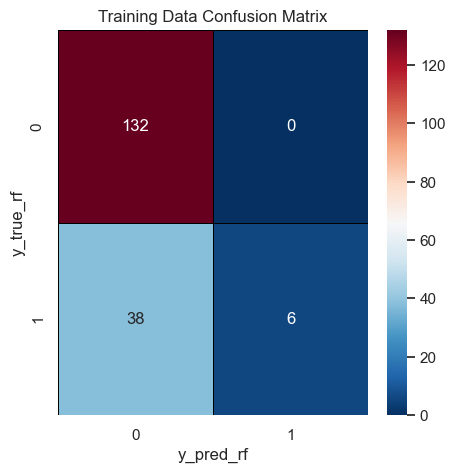

In [310]:
print("Results for Accuracy Optimized Multi-Layer Perceptron GSCV")
classification_results(X_train_tda_tael,y_train_tael["mortalité à un an"],y_pred_recall,svc_grid)

In [311]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [312]:
rfc=RandomForestClassifier(random_state=42)

In [313]:
gscv_Log_accuracy = GridSearchCV(estimator=rfc,param_grid=param_grid,
                                 cv=5, scoring = 'accuracy')
gscv_Log_accuracy.fit(X_train_tda_tael,y_train_tael["mortalité à un an"])

print(gscv_Log_accuracy.best_estimator_)
print(gscv_Log_accuracy.best_params_)

RandomForestClassifier(criterion='entropy', max_depth=4, n_estimators=500,
                       random_state=42)
{'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 500}


In [314]:
print(gscv_Log_accuracy.best_params_)

{'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 500}


In [233]:
#rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 200, max_depth=6, criterion='gini')

In [234]:
#rfc1.fit(X_train_tda_tael,y_train_tael)

RandomForestClassifier(max_depth=6, n_estimators=200, random_state=42)

In [257]:
#pred=rfc1.predict(X_train_tda_tael)

In [259]:
#print("Accuracy for Random Forest on CV data: ",accuracy_score(y_train_tael,pred))

Accuracy for Random Forest on CV data:  0.8579545454545454


In [315]:
y_pred_recall = gscv_Log_accuracy.predict(X_train_tda_tael)

              precision    recall  f1-score   support

           0       0.83      1.00      0.91       132
           1       1.00      0.39      0.56        44

    accuracy                           0.85       176
   macro avg       0.92      0.69      0.73       176
weighted avg       0.87      0.85      0.82       176

Training Accuracy: 0.8466
Training Recall: 0.3864


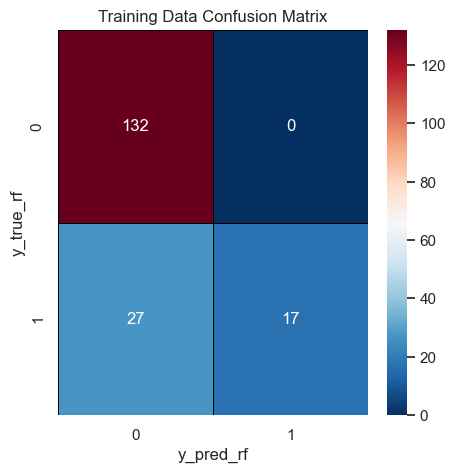

In [316]:
classification_results(X_train_tda_tael,y_train_tael["mortalité à un an"],y_pred_recall,gscv_Log_accuracy)

__________________________________________________
--------------------------------------------------
Results for: 0.1
              precision    recall  f1-score   support

           0       1.00      0.23      0.37       132
           1       0.30      1.00      0.46        44

    accuracy                           0.42       176
   macro avg       0.65      0.61      0.42       176
weighted avg       0.83      0.42      0.39       176

Training Accuracy: 0.4205
Training Recall: 1.0


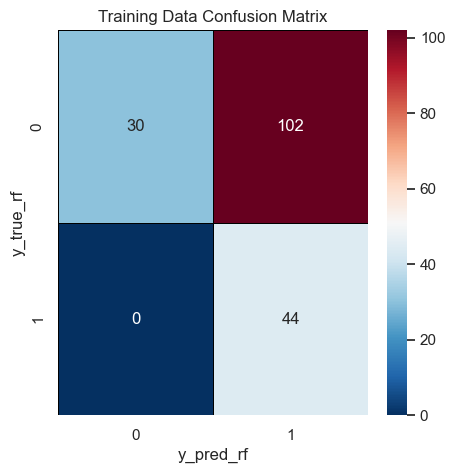

__________________________________________________
--------------------------------------------------
Results for: 0.15
              precision    recall  f1-score   support

           0       1.00      0.48      0.65       132
           1       0.39      1.00      0.56        44

    accuracy                           0.61       176
   macro avg       0.69      0.74      0.60       176
weighted avg       0.85      0.61      0.62       176

Training Accuracy: 0.608
Training Recall: 1.0


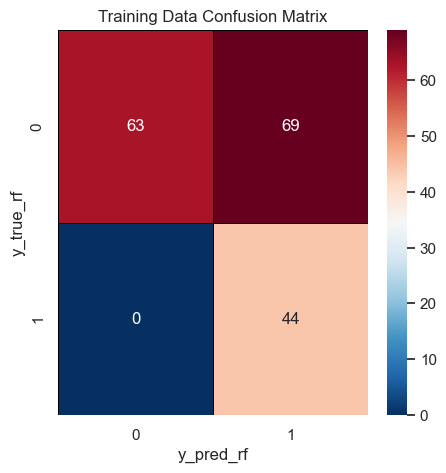

__________________________________________________
--------------------------------------------------
Results for: 0.2
              precision    recall  f1-score   support

           0       0.99      0.70      0.82       132
           1       0.52      0.98      0.68        44

    accuracy                           0.77       176
   macro avg       0.76      0.84      0.75       176
weighted avg       0.87      0.77      0.79       176

Training Accuracy: 0.7727
Training Recall: 0.9773


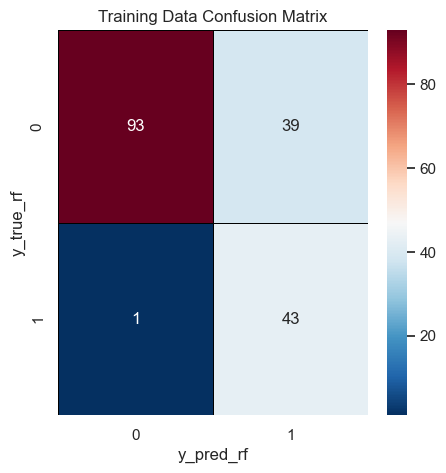

__________________________________________________
--------------------------------------------------
Results for: 0.25
              precision    recall  f1-score   support

           0       0.92      0.82      0.87       132
           1       0.59      0.80      0.68        44

    accuracy                           0.81       176
   macro avg       0.76      0.81      0.77       176
weighted avg       0.84      0.81      0.82       176

Training Accuracy: 0.8125
Training Recall: 0.7955


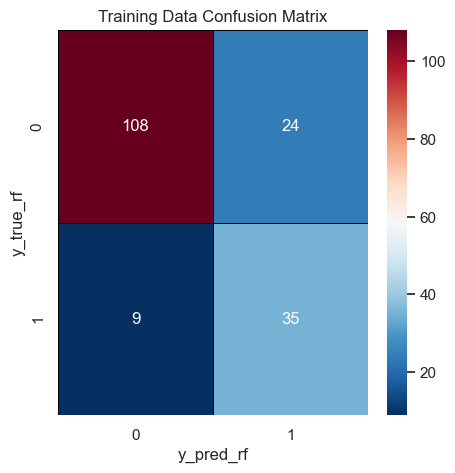

__________________________________________________
--------------------------------------------------
Results for: 0.3
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       132
           1       0.68      0.68      0.68        44

    accuracy                           0.84       176
   macro avg       0.79      0.79      0.79       176
weighted avg       0.84      0.84      0.84       176

Training Accuracy: 0.8409
Training Recall: 0.6818


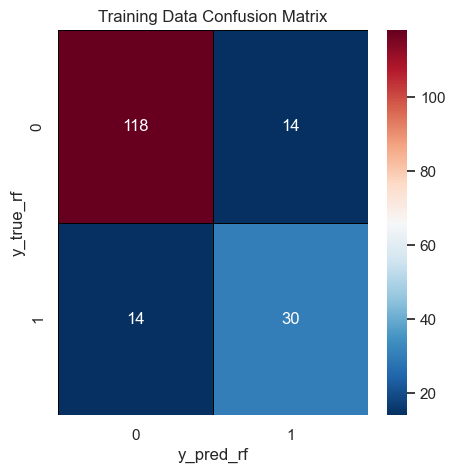

__________________________________________________
--------------------------------------------------
Results for: 0.35
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       132
           1       0.89      0.57      0.69        44

    accuracy                           0.88       176
   macro avg       0.88      0.77      0.81       176
weighted avg       0.88      0.88      0.86       176

Training Accuracy: 0.875
Training Recall: 0.5682


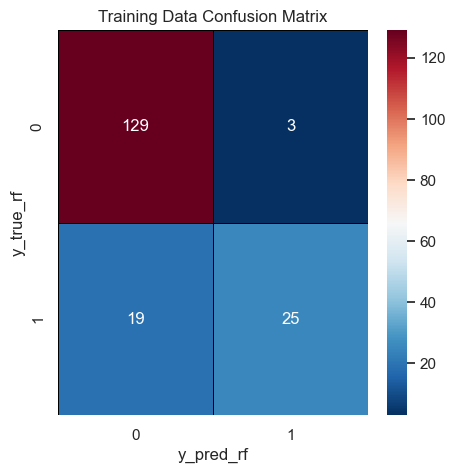

__________________________________________________
--------------------------------------------------
Results for: 0.4
              precision    recall  f1-score   support

           0       0.84      0.98      0.91       132
           1       0.87      0.45      0.60        44

    accuracy                           0.85       176
   macro avg       0.86      0.72      0.75       176
weighted avg       0.85      0.85      0.83       176

Training Accuracy: 0.8466
Training Recall: 0.4545


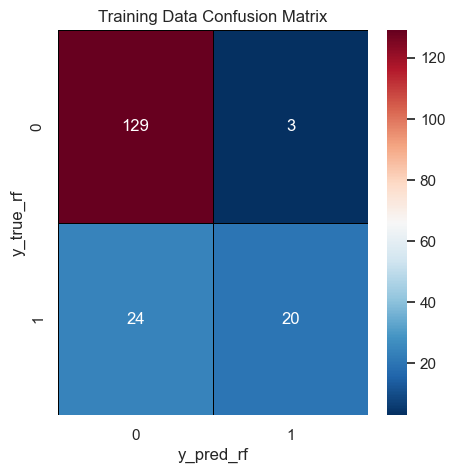

__________________________________________________
--------------------------------------------------
Results for: 0.45
              precision    recall  f1-score   support

           0       0.83      0.98      0.90       132
           1       0.89      0.39      0.54        44

    accuracy                           0.84       176
   macro avg       0.86      0.69      0.72       176
weighted avg       0.84      0.84      0.81       176

Training Accuracy: 0.8352
Training Recall: 0.3864


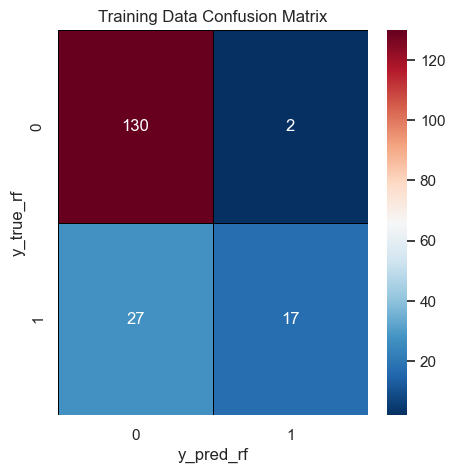

__________________________________________________
--------------------------------------------------
Results for: 0.5
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       132
           1       1.00      0.39      0.56        44

    accuracy                           0.85       176
   macro avg       0.92      0.69      0.73       176
weighted avg       0.87      0.85      0.82       176

Training Accuracy: 0.8466
Training Recall: 0.3864


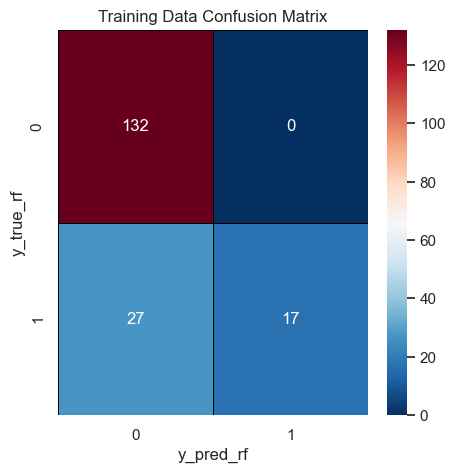

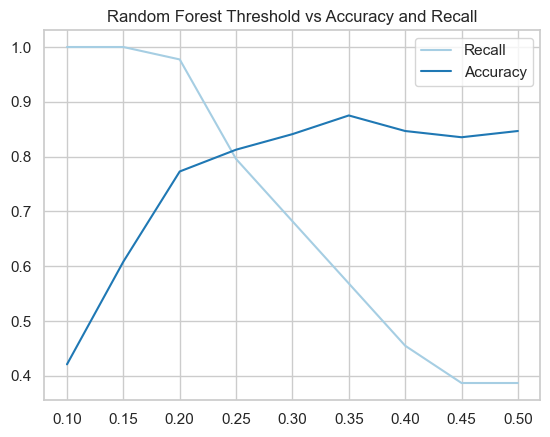

In [318]:
thresh = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]

accuracy=[]
recall=[]

# Using the LogReg GSCV Accuracy Optimized Model
for t in thresh:
    print('_' * 50)
    print('-' * 50)
    y_pred_thresh = (gscv_Log_accuracy.predict_proba(X_train_tda_tael)[:,1] >= t).astype(bool)
    classification_results(X_train_tda_tael,y_train_tael["mortalité à un an"],y_pred_thresh,gscv_Log_accuracy, title=t)
    
    accuracy.append(round(classification_report(y_train_tael["mortalité à un an"], y_pred_thresh, output_dict=True)['accuracy'],4))
    recall.append(round(classification_report(y_train_tael["mortalité à un an"], y_pred_thresh, output_dict=True)['1']['recall'],4))
    
    
plt.plot(thresh,recall, label="Recall")
plt.plot(thresh,accuracy, label = 'Accuracy')
plt.title("Random Forest Threshold vs Accuracy and Recall")
plt.legend()
plt.show()   

A threshold of 0.2 maximized accuracy while minimizing recall 

Results for: Random Forest
              precision    recall  f1-score   support

           0       0.85      0.72      0.78        57
           1       0.43      0.63      0.51        19

    accuracy                           0.70        76
   macro avg       0.64      0.68      0.65        76
weighted avg       0.75      0.70      0.71        76

Training Accuracy: 0.6974
Training Recall: 0.6316


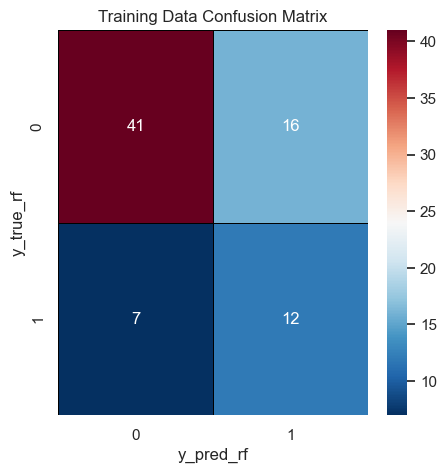

In [329]:
my_thresh = 0.2

y_pred_test_thresh = (gscv_Log_accuracy.predict_proba(X_test_tda_tael)[:,1] >= my_thresh).astype(bool)

final_log=classification_results(X_test_tda_tael,y_test_tael["mortalité à un an"],y_pred_test_thresh,gscv_Log_accuracy, title="Random Forest")


# Model Tunning - MLP

In [251]:
params = {
    'hidden_layer_sizes': [(100,), (50,50), (50,50,50),
                           (50,100,50), (100,100,50)],
    'activation': ['relu', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.0005, 0.005, 0.01, 0.05, 0.1],
    'learning_rate': ['constant','adaptive'],
    'max_iter': [100,200,400]
}

In [253]:
gscv_MLP_accuracy = GridSearchCV(estimator=MLPClassifier(),param_grid=params,
                                 n_jobs=3, scoring = 'accuracy')
gscv_MLP_accuracy.fit(X_train_tda_tael,y_train_tael)

print(gscv_MLP_accuracy.best_estimator_)
print(gscv_MLP_accuracy.best_params_)

MLPClassifier(max_iter=400, solver='sgd')
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 400, 'solver': 'sgd'}


Results for Accuracy Optimized Multi-Layer Perceptron GSCV
              precision    recall  f1-score   support

           0       0.78      1.00      0.87       132
           1       0.50      0.12      0.20        16
           2       0.00      0.00      0.00        13
           3       1.00      0.13      0.24        15

    accuracy                           0.77       176
   macro avg       0.57      0.31      0.33       176
weighted avg       0.71      0.77      0.69       176

Training Accuracy: 0.7727
Training Recall: 0.125


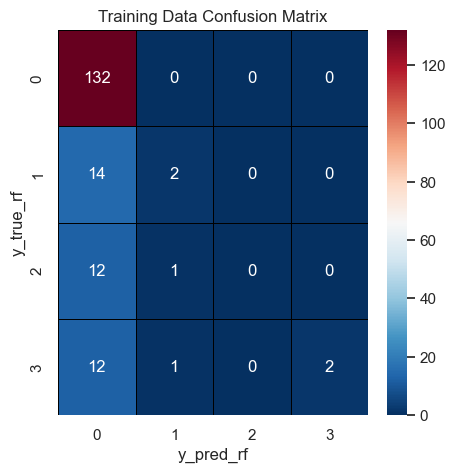

In [256]:
y_pred_accuracy = gscv_MLP_accuracy.predict(X_train_tda_tael)

print("Results for Accuracy Optimized Multi-Layer Perceptron GSCV")
classification_results(X_train_tda_tael,y_train_tael,y_pred_accuracy,gscv_MLP_accuracy)

In [262]:
thresh = [0.3,0.35,0.4,0.45,0.5]

accuracy=[]
recall=[]

# Using the MLP GSCV Recall Optimized Model
for t in thresh:
    print('_' * 50)
    print('-' * 50)
    y_pred_thresh = (gscv_MLP_recall.predict_proba(x_train_pca)[:,1] >= t).astype(bool)
    classification_results(x_train_pca,y_train_tael,y_pred_thresh,gscv_MLP_recall, title=t)

    accuracy.append(round(classification_report(y_train_tael, y_pred_thresh, output_dict=True)['accuracy'],4))
    recall.append(round(classification_report(y_train_tael, y_pred_thresh, output_dict=True)['1']['recall'],4))
    

plt.plot(thresh,recall, label="Recall")
plt.plot(thresh,accuracy, label = 'Accuracy')
plt.title("MLP Threshold vs Accuracy and Recall")
plt.legend()
plt.show()   

__________________________________________________
--------------------------------------------------


NameError: name 'gscv_MLP_recall' is not defined

### using graph

In [195]:
#pip install igraph

In [ ]:
from igraph import Graph

In [185]:
x_scaled.shape

(252, 40)

In [186]:
correlation_matrix = x_scaled.corr()

In [187]:
g = Graph()
g.add_vertices(len(x_scaled))

In [188]:
g = Graph(directed=False)  # Using undirected graph for correlation matrix
g.add_vertices(len(correlation_matrix))
g.vs["name"] = correlation_matrix.columns


In [189]:
for i in range(len(correlation_matrix)):
    for j in range(i+1, len(correlation_matrix)):
        correlation = correlation_matrix.iloc[i, j]
        if not np.isnan(correlation):
            g.add_edge(i, j, weight=correlation)


In [194]:
from igraph import plot

#plot(g, layout="fr", vertex_label=g.vs["name"], edge_label=g.es["weight"])